# Project Description

Prepare a prototype machine learning model for Zifra. The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery factor for gold from gold ore. You have data with extraction and cleaning parameters at your disposal.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

# 1. Data preparation

In [9]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [10]:
data_train = pd.read_csv('/datasets/gold_recovery_test.csv/gold_recovery_train.csv')#Reading dataset

In [3]:
data_train.info()#See general information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Compare the calculation of enrichment efficiency final.output.recovery.

In [4]:
#I create a new column in which I do the calculation of enrichment efficiency
data_train['recovery_rashetniy'] = ((data_train['rougher.output.concentrate_au']*
                                     (data_train['rougher.input.feed_au']-data_train['rougher.output.tail_au']))/
                                    (data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au']
                                                                          -data_train['rougher.output.tail_au'])))*100

In [5]:
print('MAE enrichment efficiency (calculated and given in the table) is equal to:',abs(data_train['rougher.output.recovery']- data_train['recovery_rashetniy']).mean())

MAE эффективности обогащения (рассчитанного и данного в таблице) равно: 9.444891926100695e-15


As you can see: the enrichment efficiency is calculated correctly, the MAE for the efficiency value I calculated and this one is close to 0.

In [6]:
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [7]:
data_test.info()#See general information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Let's look at the columns that are not in the test set.

In [8]:
data_train.columns[~data_train.columns.isin(data_test.columns)]#I look at the names of the columns that do not match the existing columns in the datasets

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Apparently, the test sample contains features that the model will build its predictions on, but there are no predictable values ​​themselves, that is, there are no output parameters of the raw material from each stage of processing, since these parameters depend only on the parameters of the stage itself and the initial parameters of the raw material, i.e. Removed extra columns that have correlations with other columns. Also, there are no calculated values ​​in the test sample, most likely because they are so strongly correlated with the data and can only confuse the model, although the model is most likely also able to predict / calculate them, but I think it would be easier not to take them into account in the model and then calculate them separately on the results of the model.

In [9]:
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [10]:
data_full.info()#See general information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Data preprocessing. Further down the text, all dataframe information outputs have been commented out as this loads the cache, but rest assured, when I did, I looked at the result.

In [11]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')#Converting dates to a convenient format
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')#Converting dates to a convenient format
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')#Converting dates to a convenient format

In [12]:
#data_train.info()

Next, I will replace gaps in datasets. I believe that all the calculated values ​​obtained from the data do not need to replace the gaps, as they will introduce redundancy into the model, but they can play a role in this very replacement. Therefore, in the future, I will not process them, later, before building the model, I will delete (columns such as calculation, ratio, recovery)

In [13]:
pd = data_train.loc[data_train['rougher.output.tail_au'].isnull()==True]#I create a dataset consisting of gaps in a column
pd[['rougher.output.tail_au', 'rougher.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_au', 'final.output.tail_au']]#I look at the values ​​in adjacent columns that are dependent on the original column with gaps

,rougher.output.tail_au,rougher.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.output.concentrate_au,final.output.tail_au
99,NaN,NaN,0.000000,0.000000,0.000000
100,NaN,NaN,0.000000,0.000000,0.000000
101,NaN,NaN,0.000000,0.000000,0.000000
102,NaN,NaN,0.000000,0.000000,0.000000
103,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...
16609,NaN,NaN,0.000000,0.010000,0.000000
16610,NaN,NaN,0.000000,0.010000,0.000000
16611,NaN,NaN,0.000000,0.010000,0.000000
16612,NaN,NaN,0.000000,0.010000,0.000000


As you can see: the gaps in the values ​​of tailings with gold match the value 0 in the column with the concentration of gold or the total number of tailings, so you can replace the gaps with 0.

In [14]:
index = data_train.loc[(data_train['final.output.tail_au'] == 0) & (data_train['rougher.output.tail_au'].isnull() == True)].index#Store indexes of rows whose column gaps correspond to null values ​​in the associated column
data_train.loc[index,['rougher.output.tail_au']] = data_train.loc[index,['rougher.output.tail_au']].fillna(0)#Fill in gaps corresponding to stored indexes with zeros
data_train.info()#checking

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant     

We will also look at and, if necessary, process the gaps in the column rougher.output.tail_au

In [15]:
#Looking for gaps in a column rougher.output.tail_au
pd = data_train.loc[data_train['rougher.output.tail_au'].isnull()==True]
pd[['rougher.output.tail_au', 'rougher.input.feed_au', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_au', 'final.output.tail_au']]

,rougher.output.tail_au,rougher.input.feed_au,primary_cleaner.output.tail_au,primary_cleaner.output.concentrate_au,final.output.tail_au
130,NaN,3.818488,4.772252,20.667211,2.994379
131,NaN,3.331731,5.732256,35.966027,3.325165
132,NaN,6.203655,7.428741,37.838173,3.947475
133,NaN,7.372952,5.249434,28.706613,3.430151
134,NaN,8.032530,4.148305,33.053443,2.149392
...,...,...,...,...,...
16601,NaN,3.883820,7.667772,0.010000,1.400647
16602,NaN,9.809395,15.049434,23.488845,7.318399
16603,NaN,9.844695,12.088570,38.968842,6.609894
16604,NaN,11.057542,7.526179,34.508828,5.468250


There are no zero values ​​that match the total residual readings (I checked), but if the concentration at the entrance is equal to the concentration at the exit, then there are no residues and they are 0.

In [16]:
index = data_train.loc[(data_train['primary_cleaner.output.concentrate_au'] == data_train['rougher.input.feed_au']) & (data_train['rougher.output.tail_au'].isnull() == True)].index#Checking for leftovers
data_train.loc[index,['rougher.output.tail_au']] = data_train.loc[index,['rougher.output.tail_au']].fillna(0)#I replace the gaps
#data_train.info()#I display information on the screen for verification

In [17]:
#I look for gaps in a column and for potentially codependent columns
pd = data_train.loc[data_train['rougher.output.tail_sol'].isnull()==True]
pd[['rougher.output.tail_sol', 'primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_sol','final.output.tail_sol']]

,rougher.output.tail_sol,primary_cleaner.output.tail_sol,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_sol,final.output.tail_sol
99,NaN,0.000000,0.000000,0.000000,0.000000
100,NaN,0.000000,0.000000,0.000000,0.000000
101,NaN,0.000000,0.000000,0.000000,0.000000
102,NaN,0.000000,0.000000,0.000000,0.000000
103,NaN,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
16609,NaN,0.000000,0.000000,0.000000,0.000000
16610,NaN,0.000000,0.000000,0.000000,0.000000
16611,NaN,0.000000,0.000000,0.000000,0.000000
16612,NaN,0.000000,0.000000,0.000000,0.000000


In [18]:
#Replacing column gaps rougher.output.tail_sol to 0 according to column logic final.output.tail_sol
index = data_train.loc[(data_train['final.output.tail_sol'] == 0) & (data_train['rougher.output.tail_sol'].isnull() == True)]['rougher.output.tail_sol'].index#
data_train.loc[index,['rougher.output.tail_sol']] = data_train.loc[index,['rougher.output.tail_sol']].fillna(0)
#data_train.info()

In [19]:
#I follow the same steps as before.
index = data_train.loc[(data_train['final.output.tail_sol'] == 0) & (data_train['secondary_cleaner.output.tail_sol'].isnull() == True)]['secondary_cleaner.output.tail_sol'].index#
data_train.loc[index,['secondary_cleaner.output.tail_sol']] = data_train.loc[index,['secondary_cleaner.output.tail_sol']].fillna(0)
#data_train.info()

Looking for column gaps secondary_cleaner.output.tail_sol

In [20]:
#Looking for column gaps secondary_cleaner.output.tail_sol
pd = data_train.loc[data_train['secondary_cleaner.output.tail_sol'].isnull()==True]
pd[['primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'rougher.output.tail_sol','final.output.tail_sol']].head(30)

,primary_cleaner.output.tail_sol,secondary_cleaner.output.tail_sol,rougher.output.tail_sol,final.output.tail_sol
130,NaN,NaN,NaN,NaN
131,NaN,NaN,NaN,NaN
132,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,1.024506
134,NaN,NaN,NaN,1.859845
359,1.394822,NaN,NaN,1.790799
382,NaN,NaN,NaN,NaN
383,NaN,NaN,NaN,1.666695
388,NaN,NaN,NaN,2.452573
389,NaN,NaN,NaN,3.261628


Since the yield of residues for impurities from secondary processing is functionally related to other residues and the total value of residues for all stages of processing, the gaps can be restored from the available values ​​using a regression model.

In [21]:
#I look at the number of rows in the table corresponding to the gaps in the column secondary_cleaner.output.tail_sol and filled
# columns of functionally related parameters
pd = data_train.loc[(data_train['secondary_cleaner.output.tail_sol'].isnull()==True)&(data_train['rougher.output.tail_sol'].isnull()==False)&(data_train['final.output.tail_sol'].isnull()==False)&(data_train['primary_cleaner.output.tail_sol'].isnull()==False)]
pd[['primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'rougher.output.tail_sol','final.output.tail_sol']]

,primary_cleaner.output.tail_sol,secondary_cleaner.output.tail_sol,rougher.output.tail_sol,final.output.tail_sol
1855,0.949216,NaN,10.842097,3.129768
1856,1.689113,NaN,12.227496,4.265981
1857,1.715481,NaN,13.050464,5.198314
1858,2.699547,NaN,12.297166,6.867096
1859,2.474277,NaN,10.838579,5.163369
...,...,...,...,...
16846,3.015982,NaN,16.950894,9.421421
16847,3.051909,NaN,17.189575,9.838458
16848,3.134771,NaN,16.974401,9.737694
16849,3.657784,NaN,16.480686,9.792629


In [22]:
#creating and validating a table for training linear regression
data_train_nan = data_train[['primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'rougher.output.tail_sol','final.output.tail_sol']].dropna()
data_train_nan

,primary_cleaner.output.tail_sol,secondary_cleaner.output.tail_sol,rougher.output.tail_sol,final.output.tail_sol
0,7.476074,8.764648,19.154297,16.904297
1,6.733907,9.001494,18.965234,16.634514
2,6.471768,8.842896,18.808533,16.208849
3,6.843791,9.122857,19.330200,16.532835
4,6.550154,8.871028,19.267422,16.525686
...,...,...,...,...
16855,3.934320,0.000000,16.666590,10.403181
16856,4.089124,0.000000,16.960649,10.549470
16857,4.457457,0.000000,18.323080,11.115147
16858,3.557121,0.000000,19.423740,10.463847


As you can see: we can theoretically (depending on the quality of the model) replace 1613 gaps with the secondary_cleaner.output.tail_sol column, build the model, check its MAE and compare this value with the usual sample average.

In [26]:
#I share the sample
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['secondary_cleaner.output.tail_sol'], axis=1)
target_train = df_train['secondary_cleaner.output.tail_sol']
features_test = df_valid.drop(['secondary_cleaner.output.tail_sol'], axis=1)
target_test = df_valid['secondary_cleaner.output.tail_sol']

In [27]:
#Train the model and record the model's predictions in a table
import pandas as pd
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])#Зписываю подсчитанные моделью значения
#This is followed by a procedure for replacing negative values, since the model itself can give this, but in reality
# remainders cannot be negative !
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0


In [1]:
print('МАЕ gap replacement model in column secondary_cleaner.output.tail_sol is equal to',mean_absolute_error(predskaz,target_test))

NameError: name 'mean_absolute_error' is not defined

In [29]:
print('МАЕ replacing gaps with the average value in the secondary_cleaner.output.tail_sol column is',abs(target_test - target_test.mean()).mean())

МАЕ замены пропусков средним значением в столбце secondary_cleaner.output.tail_sol равно 3.977969903493221


Since the MAE of the model turned out to be better than a simple replacement with the average, I replace the gaps according to the performance of the model.

In [30]:
#I allocate indices corresponding to the necessary replacement according to the created model
index = data_train.loc[(data_train['secondary_cleaner.output.tail_sol'].isnull() == True)&(data_train['rougher.output.tail_sol'].isnull()==False)&(data_train['final.output.tail_sol'].isnull()==False)&(data_train['primary_cleaner.output.tail_sol'].isnull()==False)]['secondary_cleaner.output.tail_sol'].index
ddd = data_train.loc[:,['primary_cleaner.output.tail_sol', 'rougher.output.tail_sol','final.output.tail_sol']]#I select a dataset from which I will take a replacement 
for i in index:
    zam = mod_nan_1.predict(ddd.loc[ddd.index==i])#replacement value corresponding to the predictor string
    if zam < 0:
        zam = 0#zeroing out any negative results, since there are either leftovers or they are not
    data_train.loc[i,['secondary_cleaner.output.tail_sol']] = zam#I make a replacement

In [31]:
#data_train.info()#I look at the result of the cycle

In [32]:
#Visual inspection of column gaps rougher.output.tail_ag
pd = data_train.loc[(data_train['rougher.output.tail_ag'].isnull()==True)]
pd[['rougher.output.tail_ag', 'rougher.input.feed_ag', 'final.output.tail_ag','rougher.output.concentrate_ag']]

,rougher.output.tail_ag,rougher.input.feed_ag,final.output.tail_ag,rougher.output.concentrate_ag
99,NaN,0.000000,0.000000,0.000000
100,NaN,0.000000,0.000000,0.000000
101,NaN,0.000000,0.000000,0.000000
102,NaN,0.000000,0.000000,0.000000
103,NaN,0.000000,0.000000,0.000000
...,...,...,...,...
16609,NaN,0.010000,0.000000,0.010000
16610,NaN,0.010000,0.000000,0.010000
16611,NaN,0.010000,0.000000,0.010000
16612,NaN,6.121900,0.000000,1.206747


In [33]:
#I replace the corresponding values ​​with 0, as I did earlier
index = data_train.loc[(data_train['final.output.tail_ag'] == 0) & (data_train['rougher.output.tail_ag'].isnull() == True)].index#
data_train.loc[index,['rougher.output.tail_ag']] = data_train.loc[index,['rougher.output.tail_ag']].fillna(0)
#data_train.info()

In [34]:
#Looking for passes rougher.input.floatbank11_xanthate and potentially related columns
pd = data_train.loc[data_train['rougher.input.floatbank11_xanthate'].isnull()==True]
pd[['rougher.input.floatbank11_xanthate', 'rougher.input.feed_au', 'rougher.output.tail_au','rougher.input.floatbank10_xanthate']]

,rougher.input.floatbank11_xanthate,rougher.input.feed_au,rougher.output.tail_au,rougher.input.floatbank10_xanthate
98,NaN,3.3311,2.774298,0.002655
99,NaN,0.0000,0.000000,0.005591
100,NaN,0.0000,0.000000,0.001380
101,NaN,0.0000,0.000000,0.000214
102,NaN,0.0000,0.000000,0.001809
...,...,...,...,...
16598,NaN,0.0100,0.000000,0.013239
16599,NaN,0.0100,0.000000,0.016972
16600,NaN,0.0100,0.000000,0.019132
16608,NaN,0.0100,0.000000,0.004885


At first glance, the dependence is incomprehensible, I’ll look at the situation from the other side, gaps rougher.input.floatbank11_xanthate with not missing rows in the column rougher.input.floatbank10_xanthate

In [35]:
pd = data_train.loc[(data_train['rougher.input.floatbank11_xanthate'].isnull()==True)&(data_train['rougher.input.floatbank10_xanthate'].isnull()==False)]
pd[['rougher.input.floatbank11_xanthate', 'rougher.input.feed_au', 'rougher.output.tail_au','rougher.input.floatbank10_xanthate']]

,rougher.input.floatbank11_xanthate,rougher.input.feed_au,rougher.output.tail_au,rougher.input.floatbank10_xanthate
98,NaN,3.3311,2.774298,0.002655
99,NaN,0.0000,0.000000,0.005591
100,NaN,0.0000,0.000000,0.001380
101,NaN,0.0000,0.000000,0.000214
102,NaN,0.0000,0.000000,0.001809
...,...,...,...,...
16502,NaN,0.0100,0.000000,0.004817
16598,NaN,0.0100,0.000000,0.013239
16599,NaN,0.0100,0.000000,0.016972
16600,NaN,0.0100,0.000000,0.019132


Since the columns are similar in name, we will test the hypothesis that the values ​​in them are approximately the same.

In [36]:
print('МАЕ rougher.input.floatbank10_xanthate relative to rougher.input.floatbank11_xanthate',abs(data_train['rougher.input.floatbank10_xanthate'] - data_train['rougher.input.floatbank11_xanthate']).mean())

МАЕ rougher.input.floatbank10_xanthate по отношению к rougher.input.floatbank11_xanthate 0.08458250662629077


In [37]:
print('МАЕ rougher.input.floatbank10_xanthate relative to the column average',abs(data_train['rougher.input.floatbank11_xanthate'] - data_train['rougher.input.floatbank11_xanthate'].mean()).mean())

МАЕ rougher.input.floatbank10_xanthate по отношению среднему по столбцу 0.9597540245623157


As you can see, the MAE of two columns is significantly less than the MAE to the average; this indicates that my hypothesis justified its hopes and you can start replacing.

In [38]:
#Replace function
index = data_train.loc[(data_train['rougher.input.floatbank11_xanthate'].isnull()==True)].index
for i in index:
    zam = float(data_train.loc[i, ['rougher.input.floatbank10_xanthate']])#By indexes, I replace adjacent elements of two columns
    data_train.loc[i, ['rougher.input.floatbank11_xanthate']] = zam

#data_train.info()#checking

By the same principle, I replace the values ​​​​of the column rougher.input.floatbank10_sulfate

In [39]:
#Column Visual Evaluation
pd = data_train.loc[(data_train['rougher.input.floatbank10_sulfate'].isnull()==True)&(data_train['rougher.input.floatbank11_sulfate'].isnull()==False)]
pd[['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank11_sulfate']]

,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate
100,NaN,0.000254
102,NaN,0.012934
104,NaN,0.008841
747,NaN,0.052944
748,NaN,0.004930
...,...,...
16607,NaN,0.328736
16608,NaN,0.297620
16609,NaN,0.273166
16610,NaN,0.259913


In [40]:
print('МАЕ between rougher.input.floatbank10_sulfate and rougher.input.floatbank11_sulfate column values',abs(data_train['rougher.input.floatbank10_sulfate'] - data_train['rougher.input.floatbank11_sulfate']).mean())

МАЕ между значениями столбцов rougher.input.floatbank10_sulfate и rougher.input.floatbank11_sulfate 0.38475617033092224


In [41]:
print('МАЕ between the values ​​of the rougher.input.floatbank10_sulfate column and its mean',abs(data_train['rougher.input.floatbank10_sulfate'] - data_train['rougher.input.floatbank10_sulfate'].mean()).mean())

МАЕ между значениями столбца rougher.input.floatbank10_sulfate и его средним 2.8575687979519744


As you can see, here, too, a simple copy will be much more accurate than a simple replacement with an average.

In [42]:
#Replace function
index = data_train.loc[(data_train['rougher.input.floatbank10_sulfate'].isnull()==True)].index
for i in index:
    zam = float(data_train.loc[i, ['rougher.input.floatbank11_sulfate']])
    data_train.loc[i, ['rougher.input.floatbank10_sulfate']] = zam

#data_train.info()

Next, I want to replace the gaps in the primary_cleaner.input.xanthate column using linear regression with a logically defined set of learning features (columns). Why am I not training the model on the entire sample? Because there are a lot of gaps in the data, they can intersect with ours, and in order to replace as many lines as possible, I select features for the model using my own logic, for example: primary_cleaner.input.xanthate - input parameter of the processing stage, which, accordingly, somehow affects the processing process itself, which in turn affects the output balances.

In [43]:
#I define data for training
data_train_nan = data_train[['primary_cleaner.input.xanthate', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb','primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au']].dropna()
data_train_nan

,primary_cleaner.input.xanthate,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au
0,0.988759,14.936526,2.534912,7.476074,2.106679
1,1.002663,16.250511,3.049646,6.733907,2.353017
2,0.991265,16.491823,3.124664,6.471768,2.416800
3,0.996739,16.024359,2.960362,6.843791,2.262051
4,1.009869,16.480185,3.112100,6.550154,2.277073
...,...,...,...,...,...
16855,1.304232,22.854592,6.531541,3.934320,2.314352
16856,1.302419,23.002490,6.629725,4.089124,2.462890
16857,1.315926,22.298149,6.278250,4.457457,2.612231
16858,1.241969,22.714656,6.253145,3.557121,2.800648


In [47]:
#Divide the sample into training and test
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['primary_cleaner.input.xanthate'], axis=1)
target_train = df_train['primary_cleaner.input.xanthate']
features_test = df_valid.drop(['primary_cleaner.input.xanthate'], axis=1)
target_test = df_valid['primary_cleaner.input.xanthate']

In [48]:
#I train the model
import pandas as pd
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index#exclude negative or so values
predskaz.loc[index,:] = 0
predskaz#checking

,predskaz
0,0.862951
1,0.986921
2,0.857825
3,0.959082
4,0.990955
...,...
3906,1.004407
3907,0.884893
3908,1.040130
3909,1.042790


In [49]:
print('МАЕ models equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.28330039791387696


In [50]:
print('МАЕ for the mean is',abs(data_train['primary_cleaner.input.xanthate'] - data_train['primary_cleaner.input.xanthate'].mean()).mean())

МАЕ для среднего равно 0.3268596287989236


In [51]:
#Here I am trying to reduce the MAE by introducing an additional feature
data_train_nan = data_train[['primary_cleaner.input.xanthate', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb','primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.state.floatbank8_a_air']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['primary_cleaner.input.xanthate'], axis=1)
target_train = df_train['primary_cleaner.input.xanthate']
features_test = df_valid.drop(['primary_cleaner.input.xanthate'], axis=1)
target_test = df_valid['primary_cleaner.input.xanthate']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ модели после увеличения фичей для обучения равно',mean_absolute_error(predskaz,target_test))

МАЕ модели после увеличения фичей для обучения равно 0.28207081929663047


Since the MAE model is not much better than a simple replacement with the average, I will replace the gaps with values ​​close in time, based on the date / time column.

In [52]:
index = data_train.loc[(data_train['primary_cleaner.input.xanthate'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.input.xanthate'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.input.xanthate'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.input.xanthate'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['primary_cleaner.input.xanthate']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


As you can see, we managed to remove a certain number of gaps in this way, but there are still many of them, and since the model is not much better than a simple replacement with the average, I will replace the remaining ones with the average.

In [53]:
#I replace the middle gaps in the column primary_cleaner.input.xanthate
data_train['primary_cleaner.input.xanthate'] = data_train['primary_cleaner.input.xanthate'].fillna(data_train['primary_cleaner.input.xanthate'].mean())
#data_train.info()

Most likely, the situation is similar in the columns primary_cleaner.input.sulfate and primary_cleaner.input.depressant, so I act in the same order.

In [54]:
index = data_train.loc[(data_train['primary_cleaner.input.sulfate'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.input.sulfate'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.input.sulfate'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.input.sulfate'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['primary_cleaner.input.sulfate']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [55]:
index = data_train.loc[(data_train['primary_cleaner.input.depressant'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.input.depressant'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.input.depressant'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.input.depressant'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['primary_cleaner.input.depressant']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


I replace the rest with the middle columns.

In [56]:
data_train['primary_cleaner.input.sulfate'] = data_train['primary_cleaner.input.sulfate'].fillna(data_train['primary_cleaner.input.sulfate'].mean())
data_train['primary_cleaner.input.depressant'] = data_train['primary_cleaner.input.depressant'].fillna(data_train['primary_cleaner.input.depressant'].mean())
#data_train.info()

Since there are a lot of gaps and it will take a lot of time to process them all, I will periodically check the sample size without calculated columns, which I will do now.

In [57]:
#I remove the columns that I will not use to build the model and check the sample size.
data_train_1 = data_train.drop(['recovery_rashetniy', 'rougher.output.recovery', 'rougher.calculation.au_pb_ratio', 'final.output.recovery', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed'], axis=1).dropna()
#data_train_1.info()

In [58]:
print('The sample was reduced by',100-(100*len(data_train_1))/len(data_train), '%')

Выборка уменьшилась на 21.07947805456702 %


As you can see, 21%, which is unacceptably high, so I continue pre-processing.

Next, I will try to replace the final.output.concentrate_sol column with model predictions

In [59]:
print('I assume that there is a linear dependence final.output.concentrate_sol and columns: final.output.concentrate_sol, primary_cleaner.output.concentrate_sol, rougher.output.concentrate_sol, secondary_cleaner.output.tail_sol')
print('Number of final.output.concentrate_sol lines skipped when columns listed',len(data_train.loc[(data_train['final.output.concentrate_sol'].isnull() ==True) & (data_train['primary_cleaner.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_sol'].isnull() ==False)]))

Предполагаю что есть линейная зависимость final.output.concentrate_sol и столбцами: final.output.concentrate_sol, primary_cleaner.output.concentrate_sol, rougher.output.concentrate_sol, secondary_cleaner.output.tail_sol
Количество пропущенных строк final.output.concentrate_sol при перечисленных столбцах 238


In [60]:
#I do the same steps as before with linear regression for the final.output.concentrate_sol column
data_train_nan = data_train[['final.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_sol','primary_cleaner.output.tail_sol']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['final.output.concentrate_sol'], axis=1)
target_train = df_train['final.output.concentrate_sol']
features_test = df_valid.drop(['final.output.concentrate_sol'], axis=1)
target_test = df_valid['final.output.concentrate_sol']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ models for passes equals',mean_absolute_error(predskaz,target_test))

МАЕ модели для пропусков равно 1.7864632446345854


In [61]:
print('MAE models for mean equals',abs(data_train['final.output.concentrate_sol'] - data_train['final.output.concentrate_sol'].mean()).mean())

МАЕ модели для среднего равно 2.7451032315292


In this case, the model is better than the average, but not by much, so from the beginning we will replace the gaps with values ​​close in time using the previously written script.

In [62]:
index = data_train.loc[(data_train['final.output.concentrate_sol'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['final.output.concentrate_sol'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['final.output.concentrate_sol'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['final.output.concentrate_sol'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['final.output.concentrate_sol']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Next, I replace the gaps with the help of the model.

In [63]:
#Here I will replace the gaps with model predictors
index = data_train.loc[(data_train['final.output.concentrate_sol'].isnull() ==True) & (data_train['primary_cleaner.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_sol'].isnull() ==False)].index
#Gap indexes matching the filled feature columns of the model
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == 48,['primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_sol', 'secondary_cleaner.output.tail_sol']])
    #I pull out the prediction of the model into the zam variable
    if zam<0:
        zam=0#Concentration cannot be negative
    data_train.loc[i, ['final.output.concentrate_sol']] = zam

#data_train.info()

I process the rest of the gaps in the same way.

In [64]:
print('I assume that there is a linear dependence on primary_cleaner.output.concentrate_pb and columns: secondary_cleaner.output.tail_pb, rougher.output.concentrate_pb, final.output.concentrate_pb')
print('Number of missing rows of primary_cleaner.output.concentrate_pb when columns are listed',len(data_train.loc[(data_train['primary_cleaner.output.concentrate_pb'].isnull() ==True) & (data_train['final.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_pb'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_pb и столбцами: secondary_cleaner.output.tail_pb, rougher.output.concentrate_pb, final.output.concentrate_pb
Количество пропущенных строк primary_cleaner.output.concentrate_pb при перечисленных столбцах 271


In [65]:
#Building a Model
data_train_nan = data_train[['primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'secondary_cleaner.output.tail_pb']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['primary_cleaner.output.concentrate_pb'], axis=1)
target_train = df_train['primary_cleaner.output.concentrate_pb']
features_test = df_valid.drop(['primary_cleaner.output.concentrate_pb'], axis=1)
target_test = df_valid['primary_cleaner.output.concentrate_pb']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ models equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 1.6715819052394605


In [66]:
print('МАЕ mean equals',abs(data_train['primary_cleaner.output.concentrate_pb'] - data_train['primary_cleaner.output.concentrate_pb'].mean()).mean())

МАЕ среднего равно 2.910455900652009


The model works but not quite correctly, so we apply the replacement in time, and we also know our model.

In [67]:
index = data_train.loc[(data_train['primary_cleaner.output.concentrate_pb'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.output.concentrate_pb'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.output.concentrate_pb'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.output.concentrate_pb'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['primary_cleaner.output.concentrate_pb']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [68]:
#I replace the rest with model predictions
index = data_train.loc[(data_train['primary_cleaner.output.concentrate_pb'].isnull() ==True) & (data_train['final.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_pb'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'secondary_cleaner.output.tail_pb']])
    if zam<0:
        zam=0
    data_train.loc[i, ['primary_cleaner.output.concentrate_pb']] = zam

#data_train.info()

And so on for other columns.

In [69]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: secondary_cleaner.output.tail_sol, rougher.output.concentrate_sol, final.output.concentrate_sol')
print('Number of missing rows of primary_cleaner.output.concentrate_sol when columns are listed',len(data_train.loc[(data_train['primary_cleaner.output.concentrate_sol'].isnull() ==True) & (data_train['final.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_sol'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: secondary_cleaner.output.tail_sol, rougher.output.concentrate_sol, final.output.concentrate_sol
Количество пропущенных строк primary_cleaner.output.concentrate_sol при перечисленных столбцах 385


In [70]:
data_train_nan = data_train[['primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol', 'rougher.output.concentrate_sol', 'secondary_cleaner.output.tail_sol']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['primary_cleaner.output.concentrate_sol'], axis=1)
target_train = df_train['primary_cleaner.output.concentrate_sol']
features_test = df_valid.drop(['primary_cleaner.output.concentrate_sol'], axis=1)
target_test = df_valid['primary_cleaner.output.concentrate_sol']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 3.1317699920406517


In [71]:
print('MAE mean is',abs(data_train['primary_cleaner.output.concentrate_sol'] - data_train['primary_cleaner.output.concentrate_sol'].mean()).mean())

МАЕ среднего равно 3.8782228992611847


As you can see here the model is not much better than the average.

In [72]:
index = data_train.loc[(data_train['primary_cleaner.output.concentrate_sol'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.output.concentrate_sol'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.output.concentrate_sol'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.output.concentrate_sol'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['primary_cleaner.output.concentrate_sol']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [73]:
#I replace the rest with the average
data_train['primary_cleaner.output.concentrate_sol'] = data_train['primary_cleaner.output.concentrate_sol'].fillna(data_train['primary_cleaner.output.concentrate_sol'].mean())
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16739 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         16860 non-null float64
primary_cleaner.input.depressant     

In [74]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: final.output.tail_sol, secondary_cleaner.output.tail_sol, final.output.tail_sol, final.output.tail_sol, rougher.output.concentrate_sol, rougher.input.feed_sol')
print('Number of rougher.output.tail_sol rows skipped when columns listed',len(data_train.loc[(data_train['rougher.output.tail_sol'].isnull() ==True) & (data_train['final.output.tail_sol'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_sol'].isnull() ==False) & (data_train['final.output.tail_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.input.feed_sol'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: final.output.tail_sol, secondary_cleaner.output.tail_sol, final.output.tail_sol, final.output.tail_sol, rougher.output.concentrate_sol, rougher.input.feed_sol
Количество пропущенных строк rougher.output.tail_sol при перечисленных столбцах 436


In [75]:
data_train_nan = data_train[['rougher.output.tail_sol', 'final.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'final.output.tail_sol', 'rougher.output.concentrate_sol', 'rougher.input.feed_sol']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.output.tail_sol'], axis=1)
target_train = df_train['rougher.output.tail_sol']
features_test = df_valid.drop(['rougher.output.tail_sol'], axis=1)
target_test = df_valid['rougher.output.tail_sol']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ модели равно',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 2.1387713990632657


In [76]:
print('MAE mean is',abs(data_train['rougher.output.tail_sol'] - data_train['rougher.output.tail_sol'].mean()).mean())

МАЕ среднего равно 4.228805563045292


MAE models are 2 times better than the average, so the model is applicable.

In [77]:
index = data_train.loc[(data_train['rougher.output.tail_sol'].isnull() ==True) & (data_train['final.output.tail_sol'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_sol'].isnull() ==False) & (data_train['final.output.tail_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.input.feed_sol'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['final.output.tail_sol', 'secondary_cleaner.output.tail_sol', 'final.output.tail_sol', 'rougher.output.concentrate_sol', 'rougher.input.feed_sol']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.output.tail_sol']] = zam

#data_train.info()

In [78]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: final.output.tail_au, secondary_cleaner.output.tail_au, primary_cleaner.output.tail_au, rougher.output.concentrate_au, primary_cleaner.output.concentrate_au, final.output.concentrate_au')
print('Number of rougher.output.tail_au lines skipped when columns listed',len(data_train.loc[(data_train['rougher.output.tail_au'].isnull() ==True) & (data_train['final.output.tail_au'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_au'].isnull() ==False) & (data_train['primary_cleaner.output.tail_au'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_au'].isnull() ==False) & (data_train['final.output.concentrate_au'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: final.output.tail_au, secondary_cleaner.output.tail_au, primary_cleaner.output.tail_au, rougher.output.concentrate_au, primary_cleaner.output.concentrate_au, final.output.concentrate_au
Количество пропущенных строк rougher.output.tail_au при перечисленных столбцах 646


In [79]:
data_train_nan = data_train[['rougher.output.tail_au', 'final.output.tail_au', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_au']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.output.tail_au'], axis=1)
target_train = df_train['rougher.output.tail_au']
features_test = df_valid.drop(['rougher.output.tail_au'], axis=1)
target_test = df_valid['rougher.output.tail_au']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ модели равно',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.37792648500410014


In [80]:
print('MAE mean is',abs(data_train['rougher.output.tail_au'] - data_train['rougher.output.tail_au'].mean()).mean())

МАЕ среднего равно 0.6664712875369464


In [81]:
index = data_train.loc[(data_train['rougher.output.tail_au'].isnull() ==True) & (data_train['final.output.tail_au'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_au'].isnull() ==False) & (data_train['primary_cleaner.output.tail_au'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['final.output.tail_au', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_au']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.output.tail_au']] = zam

#data_train.info()

I will check once again how much the sample will decrease when the gaps are removed.

In [82]:
data_train_1 = data_train.drop(['recovery_rashetniy', 'rougher.output.recovery', 'rougher.calculation.au_pb_ratio', 'final.output.recovery', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed'], axis=1).dropna()
data_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13720 entries, 0 to 16859
Data columns (total 81 columns):
date                                          13720 non-null datetime64[ns]
final.output.concentrate_ag                   13720 non-null float64
final.output.concentrate_pb                   13720 non-null float64
final.output.concentrate_sol                  13720 non-null float64
final.output.concentrate_au                   13720 non-null float64
final.output.tail_ag                          13720 non-null float64
final.output.tail_pb                          13720 non-null float64
final.output.tail_sol                         13720 non-null float64
final.output.tail_au                          13720 non-null float64
primary_cleaner.input.sulfate                 13720 non-null float64
primary_cleaner.input.depressant              13720 non-null float64
primary_cleaner.input.feed_size               13720 non-null float64
primary_cleaner.input.xanthate                13720 non-

As you can see, not enough, so we eliminate the gaps further.

In [83]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: rougher.calculation.floatbank10_sulfate_to_au_feed, rougher.input.feed_au, rougher.input.feed_au, rougher.calculation.sulfate_to_au_concentrate, rougher.output.concentrate_au, rougher.output.tail_au')
print('Number of rougher.input.floatbank10_sulfate rows skipped when columns are listed', len(data_train.loc[(data_train['rougher.input.floatbank10_sulfate'].isnull() ==True) & (data_train['rougher.calculation.floatbank10_sulfate_to_au_feed'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['rougher.calculation.sulfate_to_au_concentrate'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.tail_au'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: rougher.calculation.floatbank10_sulfate_to_au_feed, rougher.input.feed_au, rougher.input.feed_au, rougher.calculation.sulfate_to_au_concentrate, rougher.output.concentrate_au, rougher.output.tail_au
Количество пропущенных строк rougher.input.floatbank10_sulfate при перечисленных столбцах 472


In [84]:
data_train_nan = data_train[['rougher.input.floatbank10_sulfate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.input.feed_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_au', 'rougher.output.tail_au']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.floatbank10_sulfate'], axis=1)
target_train = df_train['rougher.input.floatbank10_sulfate']
features_test = df_valid.drop(['rougher.input.floatbank10_sulfate'], axis=1)
target_test = df_valid['rougher.input.floatbank10_sulfate']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ модели равно',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 2.4535400780651315


In [85]:
print('MAE mean is',abs(data_train['rougher.input.floatbank10_sulfate'] - data_train['rougher.input.floatbank10_sulfate'].mean()).mean())

МАЕ среднего равно 3.1264295234612574


In [86]:
#Replacement by timing match
index = data_train.loc[(data_train['rougher.input.floatbank10_sulfate'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.input.floatbank10_sulfate'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.input.floatbank10_sulfate'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.input.floatbank10_sulfate'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.input.floatbank10_sulfate']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [87]:
#Model replacement
index = data_train.loc[(data_train['rougher.input.floatbank10_sulfate'].isnull() ==True) & (data_train['rougher.calculation.floatbank10_sulfate_to_au_feed'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['rougher.calculation.sulfate_to_au_concentrate'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.tail_au'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.input.feed_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_au', 'rougher.output.tail_au']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.input.floatbank10_sulfate']] = zam

#data_train.info()

In [88]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: rougher.calculation.floatbank11_sulfate_to_au_feed, rougher.input.feed_au, rougher.input.feed_au, rougher.calculation.sulfate_to_au_concentrate, rougher.output.concentrate_au, rougher.output.tail_au')
print('Number of rougher.input.floatbank11_sulfate rows skipped when columns listed',len(data_train.loc[(data_train['rougher.input.floatbank11_sulfate'].isnull() ==True) & (data_train['rougher.calculation.floatbank11_sulfate_to_au_feed'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['rougher.calculation.sulfate_to_au_concentrate'].isnull() ==False) & (data_train['rougher.calculation.sulfate_to_au_concentrate'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.tail_au'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: rougher.calculation.floatbank11_sulfate_to_au_feed, rougher.input.feed_au, rougher.input.feed_au, rougher.calculation.sulfate_to_au_concentrate, rougher.output.concentrate_au, rougher.output.tail_au
Количество пропущенных строк rougher.input.floatbank11_sulfate при перечисленных столбцах 592


In [89]:
data_train_nan = data_train[['rougher.input.floatbank11_sulfate', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.input.feed_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_au', 'rougher.output.tail_au']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.floatbank11_sulfate'], axis=1)
target_train = df_train['rougher.input.floatbank11_sulfate']
features_test = df_valid.drop(['rougher.input.floatbank11_sulfate'], axis=1)
target_test = df_valid['rougher.input.floatbank11_sulfate']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('МАЕ модели равно',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 2.6010018806933144


In [90]:
print('MAE mean is',abs(data_train['rougher.input.floatbank11_sulfate'] - data_train['rougher.input.floatbank11_sulfate'].mean()).mean())

МАЕ среднего равно 3.3232767070148252


In [91]:
#Replacement by timing match
index = data_train.loc[(data_train['rougher.input.floatbank11_sulfate'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.input.floatbank11_sulfate'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.input.floatbank11_sulfate'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.input.floatbank11_sulfate'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.input.floatbank11_sulfate']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [92]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: rougher.state.floatbank10_e_level, rougher.state.floatbank10_f_air, rougher.state.floatbank10_d_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_b_air, rougher.state.floatbank10_a_air')
print('Number of rougher.state.floatbank10_e_air missing rows when columns listed',len(data_train.loc[(data_train['rougher.state.floatbank10_e_air'].isnull() ==True) & (data_train['rougher.state.floatbank10_e_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_d_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_air'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: rougher.state.floatbank10_e_level, rougher.state.floatbank10_f_air, rougher.state.floatbank10_d_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_b_air, rougher.state.floatbank10_a_air
Количество пропущенных строк rougher.state.floatbank10_e_air при перечисленных столбцах 545


Here the co-dependent columns for the model are determined by logic and selection, I added and removed looking at the MAE, as well as in other cases before. I check if there can be negative numbers here:

In [93]:
data_train['rougher.state.floatbank10_e_air'].describe()

count    16257.000000
mean      1033.886871
std        293.456164
min         -2.163619
25%        949.615568
50%       1049.693712
75%       1199.711798
max       2330.310425
Name: rougher.state.floatbank10_e_air, dtype: float64

Since there can be negative values ​​in the column, I will not null out the negative predictions of the model and this part of the code is removed in the further script.

In [94]:
#creation and verification of model operation without zeroing out negative values
data_train_nan = data_train[['rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_a_air']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.state.floatbank10_e_air'], axis=1)
target_train = df_train['rougher.state.floatbank10_e_air']
features_test = df_valid.drop(['rougher.state.floatbank10_e_air'], axis=1)
target_test = df_valid['rougher.state.floatbank10_e_air']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 42.65182992747662


In [95]:
print('MAE mean is',abs(data_train['rougher.state.floatbank10_e_air'] - data_train['rougher.state.floatbank10_e_air'].mean()).mean())

МАЕ среднего равно 186.07111002007898


In [96]:
#Replacement by timing match
index = data_train.loc[(data_train['rougher.state.floatbank10_e_air'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.state.floatbank10_e_air'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.state.floatbank10_e_air'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.state.floatbank10_e_air'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.state.floatbank10_e_air']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [97]:
index = data_train.loc[(data_train['rougher.state.floatbank10_e_air'].isnull() ==True) & (data_train['rougher.state.floatbank10_e_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_d_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_air'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_a_air']])

    data_train.loc[i, ['rougher.state.floatbank10_e_air']] = zam

#data_train.info()

In [98]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: secondary_cleaner.state.floatbank2_a_level, secondary_cleaner.state.floatbank2_b_air, secondary_cleaner.state.floatbank3_a_air, secondary_cleaner.state.floatbank3_b_air, secondary_cleaner.state.floatbank4_a_air, secondary_cleaner.state.floatbank4_b_air, secondary_cleaner.state.floatbank4_a_air, secondary_cleaner.state.floatbank4_b_air, secondary_cleaner.state.floatbank5_a_air, secondary_cleaner.state.floatbank6_a_air')
print('Number of rows skipped secondary_cleaner.state.floatbank2_a_air when columns listed',len(data_train.loc[(data_train['secondary_cleaner.state.floatbank2_a_air'].isnull() ==True) & (data_train['secondary_cleaner.state.floatbank2_a_level'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank2_b_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank3_a_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank3_b_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank4_a_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank4_b_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank5_a_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank6_a_air'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: secondary_cleaner.state.floatbank2_a_level, secondary_cleaner.state.floatbank2_b_air, secondary_cleaner.state.floatbank3_a_air, secondary_cleaner.state.floatbank3_b_air, secondary_cleaner.state.floatbank4_a_air, secondary_cleaner.state.floatbank4_b_air, secondary_cleaner.state.floatbank4_a_air, secondary_cleaner.state.floatbank4_b_air, secondary_cleaner.state.floatbank5_a_air, secondary_cleaner.state.floatbank6_a_air
Количество пропущенных строк secondary_cleaner.state.floatbank2_a_air при перечисленных столбцах 263


In [99]:
#Check if there are negative numbers
data_train['secondary_cleaner.state.floatbank2_a_air'].describe()

count    16497.000000
mean        28.134535
std          8.320744
min          0.000000
25%         25.045244
50%         29.988519
75%         34.771800
max         60.000000
Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64

In [100]:
data_train_nan = data_train[['secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank6_a_air']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['secondary_cleaner.state.floatbank2_a_air'], axis=1)
target_train = df_train['secondary_cleaner.state.floatbank2_a_air']
features_test = df_valid.drop(['secondary_cleaner.state.floatbank2_a_air'], axis=1)
target_test = df_valid['secondary_cleaner.state.floatbank2_a_air']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0#Since there were no negative numbers, I null out the negative results of the model
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 1.4977343943318413


In [101]:
print('MAE Model Equals',abs(data_train['secondary_cleaner.state.floatbank2_a_air'] - data_train['secondary_cleaner.state.floatbank2_a_air'].mean()).mean())

МАЕ среднего равно 5.739830363424243


In [102]:
#Replacement by timing match
index = data_train.loc[(data_train['secondary_cleaner.state.floatbank2_a_air'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['secondary_cleaner.state.floatbank2_a_air'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['secondary_cleaner.state.floatbank2_a_air'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['secondary_cleaner.state.floatbank2_a_air'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['secondary_cleaner.state.floatbank2_a_air']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [103]:
index = data_train.loc[(data_train['secondary_cleaner.state.floatbank2_a_air'].isnull() ==True) & (data_train['secondary_cleaner.state.floatbank2_a_level'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank2_b_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank3_a_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank3_b_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank4_a_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank4_b_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank5_a_air'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank6_a_air'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank6_a_air']])
    if zam<0:
        zam=0
    data_train.loc[i, ['secondary_cleaner.state.floatbank2_a_air']] = zam

#data_train.info()

In [104]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: primary_cleaner.output.tail_pb, rougher.output.tail_pb, rougher.output.tail_pb, secondary_cleaner.output.tail_pb, final.output.concentrate_pb, rougher.output.concentrate_pb, rougher.output.concentrate_pb, primary_cleaner.output.concentrate_pb')
print('Number of missing final.output.tail_pb rows when columns listed',len(data_train.loc[(data_train['final.output.tail_pb'].isnull() ==True) & (data_train['primary_cleaner.output.tail_pb'].isnull() ==False) & (data_train['rougher.output.tail_pb'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_pb'].isnull() ==False) & (data_train['final.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_pb'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: primary_cleaner.output.tail_pb, rougher.output.tail_pb, rougher.output.tail_pb, secondary_cleaner.output.tail_pb, final.output.concentrate_pb, rougher.output.concentrate_pb, rougher.output.concentrate_pb, primary_cleaner.output.concentrate_pb
Количество пропущенных строк final.output.tail_pb при перечисленных столбцах 117


In [105]:
data_train_nan = data_train[['final.output.tail_pb', 'primary_cleaner.output.tail_pb', 'rougher.output.tail_pb', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['final.output.tail_pb'], axis=1)
target_train = df_train['final.output.tail_pb']
features_test = df_valid.drop(['final.output.tail_pb'], axis=1)
target_test = df_valid['final.output.tail_pb']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.6169143023156888


In [106]:
print('MAE mean is',abs(data_train['final.output.tail_pb'] - data_train['final.output.tail_pb'].mean()).mean())

МАЕ среднего равно 0.9697984367760626


In [107]:
#Replacement by timing match
index = data_train.loc[(data_train['final.output.tail_pb'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['final.output.tail_pb'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['final.output.tail_pb'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['final.output.tail_pb'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['final.output.tail_pb']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [108]:
index = data_train.loc[(data_train['final.output.tail_pb'].isnull() ==True) & (data_train['primary_cleaner.output.tail_pb'].isnull() ==False) & (data_train['rougher.output.tail_pb'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_pb'].isnull() ==False) & (data_train['final.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_pb'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['primary_cleaner.output.tail_pb', 'rougher.output.tail_pb', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb']])
    if zam<0:
        zam=0
    data_train.loc[i, ['final.output.tail_pb']] = zam

#data_train.info()

In [109]:
print('I assume that there is a linear dependence primary_cleaner.output.concentrate_sol and columns: rougher.input.feed_ag, rougher.input.feed_au, rougher.input.feed_size, rougher.input.floatbank10_sulfate, rougher.input.floatbank10_xanthate, rougher.state.floatbank10_a_air, rougher.output.concentrate_pb, primary_cleaner.output.concentrate_pb')
print('Number of skipped rougher.input.feed_rate rows when columns are listed',len(data_train.loc[(data_train['rougher.input.feed_rate'].isnull() ==True) & (data_train['rougher.input.feed_ag'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['rougher.input.feed_size'].isnull() ==False) & (data_train['rougher.input.floatbank10_sulfate'].isnull() ==False) & (data_train['rougher.input.floatbank10_xanthate'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_level'].isnull() ==False)]))

Предполагаю что есть линейная зависимость primary_cleaner.output.concentrate_sol и столбцами: rougher.input.feed_ag, rougher.input.feed_au, rougher.input.feed_size, rougher.input.floatbank10_sulfate, rougher.input.floatbank10_xanthate, rougher.state.floatbank10_a_air, rougher.output.concentrate_pb, primary_cleaner.output.concentrate_pb
Количество пропущенных строк rougher.input.feed_rate при перечисленных столбцах 354


In [110]:
data_train_nan = data_train[['rougher.input.feed_rate', 'rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_size', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.feed_rate'], axis=1)
target_train = df_train['rougher.input.feed_rate']
features_test = df_valid.drop(['rougher.input.feed_rate'], axis=1)
target_test = df_valid['rougher.input.feed_rate']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 57.760849965221844


In [111]:
print('MAE mean is',abs(data_train['rougher.input.feed_rate'] - data_train['rougher.input.feed_rate'].mean()).mean())

МАЕ среднего равно 116.3049962107997


In [112]:
#Replacement by timing match
index = data_train.loc[(data_train['rougher.input.feed_rate'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.input.feed_rate'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.input.feed_rate'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.input.feed_rate'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.input.feed_rate']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [113]:
index = data_train.loc[(data_train['rougher.input.feed_rate'].isnull() ==True) & (data_train['rougher.input.feed_ag'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['rougher.input.feed_size'].isnull() ==False) & (data_train['rougher.input.floatbank10_sulfate'].isnull() ==False) & (data_train['rougher.input.floatbank10_xanthate'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_level'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_size', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.input.feed_rate']] = zam

#data_train.info()

In [114]:
print('I assume that there is a linear dependence on rougher.input.feed_pb and columns: rougher.output.concentrate_pb, rougher.calculation.au_pb_ratio, rougher.output.concentrate_au, rougher.input.feed_au, primary_cleaner.output.concentrate_pb, secondary_cleaner.output.tail_pb, final.output.concentrate_pb')
print('Number of rougher.input.feed_pb rows skipped when columns listed',len(data_train.loc[(data_train['rougher.input.feed_pb'].isnull() ==True) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.calculation.au_pb_ratio'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_pb'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_pb'].isnull() ==False) & (data_train['final.output.concentrate_pb'].isnull() ==False)]))

Предполагаю что есть линейная зависимость rougher.input.feed_pb и столбцами: rougher.output.concentrate_pb, rougher.calculation.au_pb_ratio, rougher.output.concentrate_au, rougher.input.feed_au, primary_cleaner.output.concentrate_pb, secondary_cleaner.output.tail_pb, final.output.concentrate_pb
Количество пропущенных строк rougher.input.feed_pb при перечисленных столбцах 146


In [115]:
data_train_nan = data_train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'rougher.input.feed_au', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.feed_pb'], axis=1)
target_train = df_train['rougher.input.feed_pb']
features_test = df_valid.drop(['rougher.input.feed_pb'], axis=1)
target_test = df_valid['rougher.input.feed_pb']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.27260639078413196


In [116]:
print('MAE mean is',abs(data_train['rougher.input.feed_pb'] - data_train['rougher.input.feed_pb'].mean()).mean())

МАЕ среднего равно 1.1203756381703445


In [117]:
#Replacement by timing match
index = data_train.loc[(data_train['rougher.input.feed_pb'].isnull() ==True)].index#Indexes of elements with gaps
for i in index:
    #The code below pulls out the required value in the line with the hour +1
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.input.feed_pb'])
    if zam == 'Nan':#Since a close time may not always exist, let's go over the options in the + -12 hour interval
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.input.feed_pb'])
            if zam != 'Nan':#Loop exit condition
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.input.feed_pb'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.input.feed_pb']] = zam#Replacement

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [118]:
index = data_train.loc[(data_train['rougher.input.feed_pb'].isnull() ==True) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.calculation.au_pb_ratio'].isnull() ==False) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_pb'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_pb'].isnull() ==False) & (data_train['final.output.concentrate_pb'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.output.concentrate_pb', 'rougher.input.feed_au', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.input.feed_pb']] = zam

#data_train.info()

In [119]:
print('I assume that there is a linear dependence rougher.output.tail_ag and columns: rougher.input.feed_ag, rougher.output.concentrate_ag, rougher.output.concentrate_au, secondary_cleaner.output.tail_ag, primary_cleaner.output.concentrate_ag, primary_cleaner.output.tail_ag, final .output.concentrate_ag, final.output.tail_ag, rougher.input.floatbank10_sulfate, rougher.state.floatbank10_a_level, rougher.state.floatbank10_b_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_d_air, rougher.state .floatbank10_e_air, rougher.state.floatbank10_f_air, rougher.state.floatbank10_f_level')
print('Number of rougher.output.tail_ag rows skipped when columns listed',len(data_train.loc[(data_train['rougher.output.tail_ag'].isnull() ==True) & (data_train['rougher.input.feed_ag'].isnull() ==False) & (data_train['rougher.output.concentrate_ag'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_ag'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_ag'].isnull() ==False) & (data_train['primary_cleaner.output.tail_ag'].isnull() ==False) & (data_train['final.output.concentrate_ag'].isnull() ==False) & (data_train['final.output.tail_ag'].isnull() ==False) & (data_train['rougher.input.floatbank10_sulfate'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_d_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_e_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_level'].isnull() ==False)]))

Предполагаю что есть линейная зависимость rougher.output.tail_ag и столбцами: rougher.input.feed_ag, rougher.output.concentrate_ag, rougher.output.concentrate_au, secondary_cleaner.output.tail_ag, primary_cleaner.output.concentrate_ag, primary_cleaner.output.tail_ag, final.output.concentrate_ag, final.output.tail_ag, rougher.input.floatbank10_sulfate, rougher.state.floatbank10_a_level, rougher.state.floatbank10_b_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_d_air, rougher.state.floatbank10_e_air, rougher.state.floatbank10_f_air, rougher.state.floatbank10_f_level
Количество пропущенных строк rougher.output.tail_ag при перечисленных столбцах 654


In [120]:
data_train_nan = data_train[['rougher.output.tail_ag', 'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'final.output.concentrate_ag', 'final.output.tail_ag', 'rougher.input.floatbank10_sulfate', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.output.tail_ag'], axis=1)
target_train = df_train['rougher.output.tail_ag']
features_test = df_valid.drop(['rougher.output.tail_ag'], axis=1)
target_test = df_valid['rougher.output.tail_ag']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.6453302973886219


In [121]:
print('MAE mean is',abs(data_train['rougher.output.tail_ag'] - data_train['rougher.output.tail_ag'].mean()).mean())

МАЕ среднего равно 1.3705094820798724


In [122]:
index = data_train.loc[(data_train['rougher.output.tail_ag'].isnull() ==True) & (data_train['rougher.input.feed_ag'].isnull() ==False) & (data_train['rougher.output.concentrate_ag'].isnull() ==False) & (data_train['secondary_cleaner.output.tail_ag'].isnull() ==False) & (data_train['primary_cleaner.output.concentrate_ag'].isnull() ==False) & (data_train['primary_cleaner.output.tail_ag'].isnull() ==False) & (data_train['final.output.concentrate_ag'].isnull() ==False) & (data_train['final.output.tail_ag'].isnull() ==False) & (data_train['rougher.input.floatbank10_sulfate'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_d_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_e_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_level'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'final.output.concentrate_ag', 'final.output.tail_ag', 'rougher.input.floatbank10_sulfate', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.output.tail_ag']] = zam

#data_train.info()

In [123]:
print('I assume that there is a linear dependence on rougher.input.feed_size and columns: final.output.tail_ag, final.output.tail_pb, final.output.tail_sol, final.output.tail_au, rougher.input.floatbank10_xanthate, rougher.state.floatbank10_a_level, secondary_cleaner.state.floatbank2_b_air')
print('Number of skipped rougher.input.feed_size rows when columns are listed',len(data_train.loc[(data_train['rougher.input.feed_size'].isnull() ==True) & (data_train['final.output.tail_ag'].isnull() ==False) & (data_train['final.output.tail_pb'].isnull() ==False) & (data_train['final.output.tail_sol'].isnull() ==False) & (data_train['final.output.tail_au'].isnull() ==False) & (data_train['rougher.input.floatbank10_xanthate'].isnull() ==False) & (data_train['rougher.state.floatbank10_a_level'].isnull() ==False) & (data_train['secondary_cleaner.state.floatbank2_b_air'].isnull() ==False)]))

Предполагаю что есть линейная зависимость rougher.input.feed_size и столбцами: final.output.tail_ag, final.output.tail_pb, final.output.tail_sol, final.output.tail_au, rougher.input.floatbank10_xanthate, rougher.state.floatbank10_a_level, secondary_cleaner.state.floatbank2_b_air
Количество пропущенных строк rougher.input.feed_size при перечисленных столбцах 307


In [124]:
data_train_nan = data_train[['rougher.input.feed_size', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au','rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank2_b_air']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.feed_size'], axis=1)
target_train = df_train['rougher.input.feed_size']
features_test = df_valid.drop(['rougher.input.feed_size'], axis=1)
target_test = df_valid['rougher.input.feed_size']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 10.876648098515227


In [125]:
print('MAE mean is',abs(data_train['rougher.input.feed_size'] - data_train['rougher.input.feed_size'].mean()).mean())

МАЕ среднего равно 13.227487602687882


Since the MAE of the model is not much better than the average MAE, I replace it only with values ​​close in time.

In [126]:
index = data_train.loc[(data_train['rougher.input.feed_size'].isnull() ==True)].index
for i in index:
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.input.feed_size'])
    if zam == 'Nan':
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.input.feed_size'])
            if zam != 'Nan':
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.input.feed_size'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.input.feed_size']] = zam

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


Same with the rougher.input.feed_sol column

In [127]:
index = data_train.loc[(data_train['rougher.input.feed_sol'].isnull() ==True)].index
for i in index:
    zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=1))]['rougher.input.feed_sol'])
    if zam == 'Nan':
        for h in range(12):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['rougher.input.feed_sol'])
            if zam != 'Nan':
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_train.loc[data_train['date']==(data_train.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['rougher.input.feed_sol'])
            if zam != 'Nan':
                break
    data_train.loc[i, ['rougher.input.feed_sol']] = zam

#data_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
print('I assume that there is a linear dependence rougher.input.floatbank10_xanthate and columns: rougher.output.concentrate_au, rougher.output.concentrate_ag, rougher.output.concentrate_sol, rougher.output.concentrate_pb, rougher.state.floatbank10_b_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_e_air, rougher.state.floatbank10_f_air, rougher.input.feed_rate, rougher.input.feed_au')
print('Number of rougher.input.floatbank10_xanthate rows skipped when columns listed',len(data_train.loc[(data_train['rougher.input.floatbank10_xanthate'].isnull() ==True) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.concentrate_ag'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_e_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.input.feed_rate'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False)]))

Предполагаю что есть линейная зависимость rougher.input.floatbank10_xanthate и столбцами: rougher.output.concentrate_au, rougher.output.concentrate_ag, rougher.output.concentrate_sol, rougher.output.concentrate_pb, rougher.state.floatbank10_b_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_e_air, rougher.state.floatbank10_f_air, rougher.input.feed_rate, rougher.input.feed_au
Количество пропущенных строк rougher.input.floatbank10_xanthate при перечисленных столбцах 203


In [129]:
data_train_nan = data_train[['rougher.input.floatbank10_xanthate', 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.input.feed_rate', 'rougher.input.feed_au']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.floatbank10_xanthate'], axis=1)
target_train = df_train['rougher.input.floatbank10_xanthate']
features_test = df_valid.drop(['rougher.input.floatbank10_xanthate'], axis=1)
target_test = df_valid['rougher.input.floatbank10_xanthate']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.6056240868777818


In [130]:
print('MAE Model Equals',abs(data_train['rougher.input.floatbank10_xanthate'] - data_train['rougher.input.floatbank10_xanthate'].mean()).mean())

МАЕ модели равно 1.3239857167871856


In [131]:
index = data_train.loc[(data_train['rougher.input.floatbank10_xanthate'].isnull() ==True) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.concentrate_ag'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_e_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.input.feed_rate'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.input.feed_rate', 'rougher.input.feed_au']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.input.floatbank10_xanthate']] = zam

#data_train.info()

In [132]:
print('I assume that there is a linear dependence rougher.input.floatbank11_xanthate and columns: rougher.output.concentrate_au, rougher.output.concentrate_ag, rougher.output.concentrate_sol, rougher.output.concentrate_pb, rougher.state.floatbank10_b_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_e_air, rougher.state.floatbank10_f_air, rougher.input.feed_rate, rougher.input.feed_au')
print('Number of rougher.input.floatbank11_xanthate rows skipped when columns listed',len(data_train.loc[(data_train['rougher.input.floatbank11_xanthate'].isnull() ==True) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.concentrate_ag'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_e_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.input.feed_rate'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False)]))

Предполагаю что есть линейная зависимость rougher.input.floatbank11_xanthate и столбцами: rougher.output.concentrate_au, rougher.output.concentrate_ag, rougher.output.concentrate_sol, rougher.output.concentrate_pb, rougher.state.floatbank10_b_air, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_e_air, rougher.state.floatbank10_f_air, rougher.input.feed_rate, rougher.input.feed_au
Количество пропущенных строк rougher.input.floatbank11_xanthate при перечисленных столбцах 186


In [133]:
data_train_nan = data_train[['rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.input.feed_rate', 'rougher.input.feed_au']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.input.floatbank11_xanthate'], axis=1)
target_train = df_train['rougher.input.floatbank11_xanthate']
features_test = df_valid.drop(['rougher.input.floatbank11_xanthate'], axis=1)
target_test = df_valid['rougher.input.floatbank11_xanthate']
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0
print('MAE Model Equals',mean_absolute_error(predskaz,target_test))

МАЕ модели равно 0.6173901031378376


In [134]:
print('MAE mean is',abs(data_train['rougher.input.floatbank11_xanthate'] - data_train['rougher.input.floatbank11_xanthate'].mean()).mean())

МАЕ среднего равно 1.3394306966242178


In [135]:
index = data_train.loc[(data_train['rougher.input.floatbank11_xanthate'].isnull() ==True) & (data_train['rougher.output.concentrate_au'].isnull() ==False) & (data_train['rougher.output.concentrate_ag'].isnull() ==False) & (data_train['rougher.output.concentrate_sol'].isnull() ==False) & (data_train['rougher.output.concentrate_pb'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_b_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_c_level'].isnull() ==False) & (data_train['rougher.state.floatbank10_e_air'].isnull() ==False) & (data_train['rougher.state.floatbank10_f_air'].isnull() ==False) & (data_train['rougher.input.feed_rate'].isnull() ==False) & (data_train['rougher.input.feed_au'].isnull() ==False)].index
for i in index:
    zam = mod_nan_1.predict(data_train.loc[data_train.index == i,['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 'rougher.input.feed_rate', 'rougher.input.feed_au']])
    if zam<0:
        zam=0
    data_train.loc[i, ['rougher.input.floatbank11_xanthate']] = zam

#data_train.info()

In [136]:
print('MAE between rougher.input.floatbank11_sulfate and rougher.input.floatbank10_sulfate',abs(data_train['rougher.input.floatbank10_sulfate'] - data_train['rougher.input.floatbank11_sulfate']).mean())

МАЕ между rougher.input.floatbank11_sulfate и rougher.input.floatbank10_sulfate 0.3776239456556608


In [137]:
print('MAE between rougher.input.floatbank11_sulfate and middle',abs(data_train['rougher.input.floatbank11_sulfate'] - data_train['rougher.input.floatbank11_sulfate'].mean()).mean())

МАЕ между rougher.input.floatbank11_sulfate и средним 3.364102324851749


Since rougher.input.floatbank11_sulfate and rougher.input.floatbank10_sulfate are close in value and the MAE between the columns is much less than the MAE of the model, I will fill the gaps in rougher.input.floatbank11_sulfate with the same values ​​from the adjacent column rougher.input.floatbank10_sulfate

In [138]:
index = data_train.loc[(data_train['rougher.input.floatbank11_sulfate'].isnull() ==True) & (data_train['rougher.input.floatbank10_sulfate'].isnull() ==False)].index
for i in index:
    zam = float(data_train.loc[i,['rougher.input.floatbank10_sulfate']])
    data_train.loc[i, ['rougher.input.floatbank11_sulfate']] = zam

#data_train.info()

Since there are no more gaps in the rougher.input.feed_size column, I will fill them with an average.

In [139]:
data_train['rougher.input.feed_size'] = data_train['rougher.input.feed_size'].fillna(data_train['rougher.input.feed_size'].mean())
data_train['secondary_cleaner.output.tail_sol'] = data_train['secondary_cleaner.output.tail_sol'].fillna(data_train['secondary_cleaner.output.tail_sol'].mean())
data_train['rougher.output.tail_sol'] = data_train['rougher.output.tail_sol'].fillna(data_train['rougher.output.tail_sol'].mean())
#data_train.info()

In [140]:
data_train_1 = data_train.drop(['recovery_rashetniy', 'rougher.output.recovery', 'rougher.calculation.au_pb_ratio', 'final.output.recovery', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed'], axis=1).dropna()
data_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16131 entries, 0 to 16859
Data columns (total 81 columns):
date                                          16131 non-null datetime64[ns]
final.output.concentrate_ag                   16131 non-null float64
final.output.concentrate_pb                   16131 non-null float64
final.output.concentrate_sol                  16131 non-null float64
final.output.concentrate_au                   16131 non-null float64
final.output.tail_ag                          16131 non-null float64
final.output.tail_pb                          16131 non-null float64
final.output.tail_sol                         16131 non-null float64
final.output.tail_au                          16131 non-null float64
primary_cleaner.input.sulfate                 16131 non-null float64
primary_cleaner.input.depressant              16131 non-null float64
primary_cleaner.input.feed_size               16131 non-null float64
primary_cleaner.input.xanthate                16131 non-

In [141]:
print('Percentage of data that had to be deleted due to omissions',100-(len(data_train_1)*100)/len(data_train), '%')

Процентное содержание данных, которые пришлось удалить из-за пропусков 4.32384341637011 %


Gaps have been processed and removed from data_train. Part of the gaps was filled with an average value, part of the gaps was filled using a linear model, part of the data was taken from columns adjacent in time. Gaps in the calculated parameters were not processed.

I'm starting to process gaps in the data_test table.

In [142]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
ro

In [143]:
data_test_1 = data_test.dropna()#I check whether it is possible to simply remove gaps and whether the sample will critically decrease
print('When deleting missing rows, the selection will decrease by',100-(len(data_test_1)*100)/len(data_test), '%')

При удалении пропущенных строк выборка уменьшится на 8.077185792349724 %


8% is unacceptably high, so gaps will have to be processed.

In [144]:
index = data_test.loc[(data_test['primary_cleaner.input.sulfate'].isnull() ==True)].index
for i in index:
    zam = float(data_test.loc[data_test['date']==(data_test.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.input.sulfate'])
    if zam == 'Nan':
        for h in range(12):
            zam = float(data_test.loc[data_test['date']==(data_test.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.input.sulfate'])
            if zam != 'Nan':
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_test.loc[data_test['date']==(data_test.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.input.sulfate'])
            if zam != 'Nan':
                break
    data_test.loc[i, ['primary_cleaner.input.sulfate']] = zam

#data_test.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
index = data_test.loc[(data_test['primary_cleaner.input.depressant'].isnull() ==True)].index
for i in index:
    zam = float(data_test.loc[data_test['date']==(data_test.ix[i,'date']+pd.Timedelta(hours=1))]['primary_cleaner.input.depressant'])
    if zam == 'Nan':
        for h in range(12):
            zam = float(data_test.loc[data_test['date']==(data_test.ix[i,'date']-pd.Timedelta(hours=(h+1)))]['primary_cleaner.input.depressant'])
            if zam != 'Nan':
                break
    if zam == 'Nan':
        for h in range(11):
            zam = float(data_test.loc[data_test['date']==(data_test.ix[i,'date']+pd.Timedelta(hours=(h+2)))]['primary_cleaner.input.depressant'])
            if zam != 'Nan':
                break
    data_test.loc[i, ['primary_cleaner.input.depressant']] = zam

#data_test.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
index = data_test.loc[(data_test['rougher.input.floatbank10_sulfate'].isnull() ==True) & (data_test['rougher.input.floatbank11_sulfate'].isnull() ==False)].index
for i in index:
    zam = float(data_test.loc[i,['rougher.input.floatbank11_sulfate']])
    data_test.loc[i, ['rougher.input.floatbank10_sulfate']] = zam

#data_test.info()

In [147]:
index = data_test.loc[(data_test['rougher.input.floatbank11_xanthate'].isnull() ==True) & (data_test['rougher.input.floatbank10_xanthate'].isnull() ==False)].index
for i in index:
    zam = float(data_test.loc[i,['rougher.input.floatbank10_xanthate']])
    data_test.loc[i, ['rougher.input.floatbank11_xanthate']] = zam

#data_test.info()

In [148]:
#I replace the gaps in the columns primary_cleaner.input. (depressant, sulfate, xanthate) with the average, since judging by the train dataset, the model is not better
data_test['primary_cleaner.input.depressant'] = data_test['primary_cleaner.input.depressant'].fillna(data_test['primary_cleaner.input.depressant'].mean())
data_test['primary_cleaner.input.sulfate'] = data_test['primary_cleaner.input.sulfate'].fillna(data_test['primary_cleaner.input.sulfate'].mean())
data_test['primary_cleaner.input.xanthate'] = data_test['primary_cleaner.input.xanthate'].fillna(data_test['primary_cleaner.input.xanthate'].mean())

In [149]:
data_test_1 = data_test.dropna()#I check whether it is possible to simply remove gaps and whether the sample will critically decrease
print('When deleting missing rows, the selection will decrease by',100-(len(data_test_1)*100)/len(data_test), '%')

При удалении пропущенных строк выборка уменьшится на 4.252049180327873 %


We can afford this reduction in the sample, so we leave such data.

We will check and, if necessary, correct the data for outliers. In statistics, the data range is within 3 standard deviations, so I'll write a function that will show us the distribution of the column and the values ​​that are outside 3 standard deviations.

final.output.concentrate_ag
< min, len: 0
Series([], Name: final.output.concentrate_ag, dtype: float64)
> max, len: 76
320      11.525055
376      13.673506
377      12.057372
406      11.557897
407      11.023427
           ...    
9119     10.903107
11597    12.098616
11598    12.082290
11599    10.894846
14840    11.551304
Name: final.output.concentrate_ag, Length: 76, dtype: float64


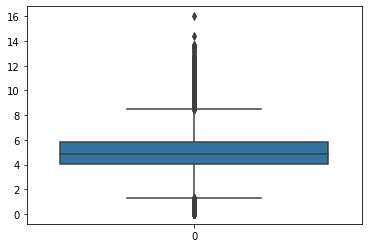

-------------------------------------------------------------------------------
final.output.concentrate_pb
< min, len: 0
Series([], Name: final.output.concentrate_pb, dtype: float64)
> max, len: 0
Series([], Name: final.output.concentrate_pb, dtype: float64)


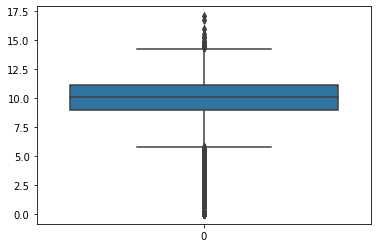

-------------------------------------------------------------------------------
final.output.concentrate_sol
< min, len: 0
Series([], Name: final.output.concentrate_sol, dtype: float64)
> max, len: 0
Series([], Name: final.output.concentrate_sol, dtype: float64)


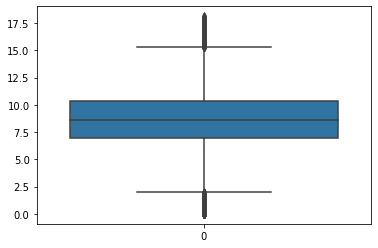

-------------------------------------------------------------------------------
final.output.concentrate_au
< min, len: 1359
99       0.00
100      0.00
101      0.00
102      0.00
103      0.00
         ... 
16610    0.01
16611    0.01
16612    0.01
16665    0.01
16666    0.01
Name: final.output.concentrate_au, Length: 1359, dtype: float64
> max, len: 0
Series([], Name: final.output.concentrate_au, dtype: float64)


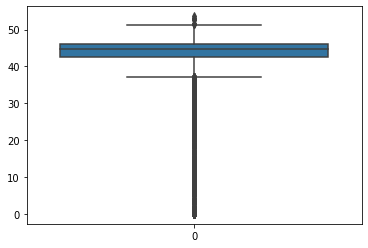

-------------------------------------------------------------------------------
final.output.tail_ag
< min, len: 0
Series([], Name: final.output.tail_ag, dtype: float64)
> max, len: 1
16485    19.552149
Name: final.output.tail_ag, dtype: float64


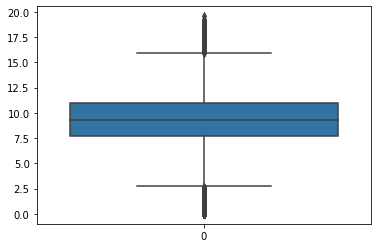

-------------------------------------------------------------------------------
final.output.tail_pb
< min, len: 0
Series([], Name: final.output.tail_pb, dtype: float64)
> max, len: 1
6194    6.086532
Name: final.output.tail_pb, dtype: float64


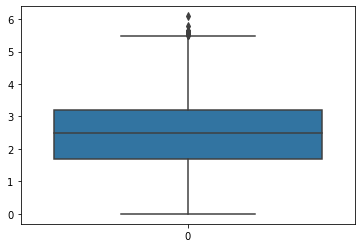

-------------------------------------------------------------------------------
final.output.tail_sol
< min, len: 0
Series([], Name: final.output.tail_sol, dtype: float64)
> max, len: 4
365     22.272019
376     22.317730
1200    22.194637
1218    21.913474
Name: final.output.tail_sol, dtype: float64


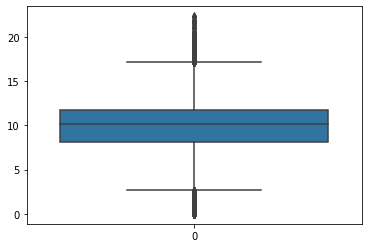

-------------------------------------------------------------------------------
final.output.tail_au
< min, len: 0
Series([], Name: final.output.tail_au, dtype: float64)
> max, len: 77
376      8.197408
377      7.723369
433      6.693746
849      7.207967
2512     6.689938
           ...   
16309    6.993324
16436    7.379391
16437    6.635321
16438    6.571874
16603    6.609894
Name: final.output.tail_au, Length: 77, dtype: float64


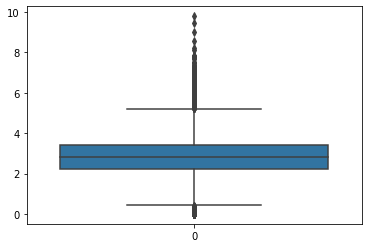

-------------------------------------------------------------------------------
primary_cleaner.input.sulfate
< min, len: 252
106      0.030815
107      0.030815
108      0.122067
109      0.089080
110      0.050144
           ...   
15622    0.229590
16501    0.179616
16598    0.089524
16599    0.017954
16600    0.042164
Name: primary_cleaner.input.sulfate, Length: 252, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.input.sulfate, dtype: float64)


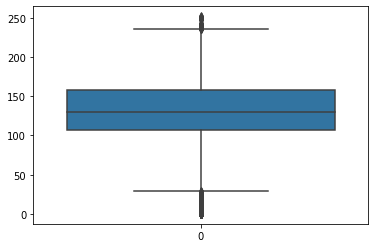

-------------------------------------------------------------------------------
primary_cleaner.input.depressant
< min, len: 0
Series([], Name: primary_cleaner.input.depressant, dtype: float64)
> max, len: 23
2385    19.825462
2386    19.965928
2387    19.987054
2441    20.673152
3022    19.529694
3023    19.981592
3024    19.959763
3025    19.965500
3026    20.014036
3027    19.996295
3028    19.996685
3029    20.052255
3030    20.022786
3031    20.007945
3032    19.952429
3033    20.021290
3034    20.036965
3035    20.000731
3036    20.014703
3037    19.988641
3038    19.639606
3057    40.000000
3058    30.473690
Name: primary_cleaner.input.depressant, dtype: float64


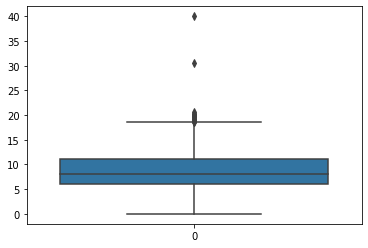

-------------------------------------------------------------------------------
primary_cleaner.input.feed_size
< min, len: 39
399      5.410000
400      5.410000
6932     5.463333
6933     5.410000
7308     5.201667
7309     4.970000
7312     4.970000
7313     4.970000
7314     4.970000
7315     4.970000
7316     4.970000
7317     4.970000
7318     4.970000
7319     4.970000
7320     4.970000
7321     4.970000
7322     4.970000
9692     5.410000
9693     5.410000
9694     5.410000
9695     5.410000
10172    5.310000
10173    5.310000
10174    5.310000
10175    5.310000
10176    5.310000
10177    5.310000
10178    5.310000
10179    5.310000
10180    5.310000
15689    1.080007
15690    1.080000
15691    1.080000
15692    1.080000
15693    1.080000
15694    1.080000
15695    1.080000
15696    1.080000
15697    4.184992
Name: primary_cleaner.input.feed_size, dtype: float64
> max, len: 28
1552     10.470000
1553     10.470000
2553      9.430000
2554      9.445000
2555      9.471333
2556   

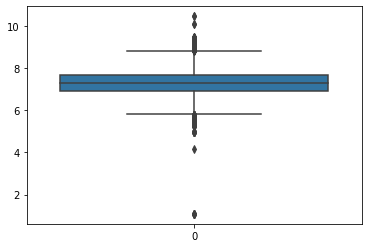

-------------------------------------------------------------------------------
primary_cleaner.input.xanthate
< min, len: 0
Series([], Name: primary_cleaner.input.xanthate, dtype: float64)
> max, len: 39
1250     2.091129
1251     2.089600
1252     2.105497
1928     3.492976
2429     2.109655
2430     2.106473
2431     2.099782
2433     2.114306
2576     2.684886
2577     2.684886
3054     2.874698
3055     2.874698
3056     2.101869
5387     2.741276
5936     2.369553
5937     2.369553
8660     6.027907
8661     3.873286
8921     4.031293
11231    3.350483
11808    2.200418
11809    2.197320
11810    2.181500
11811    2.215767
11812    2.199859
11813    2.184549
11814    2.097477
13559    2.196872
13560    2.514338
13561    2.332645
13562    2.316092
13563    2.317417
13564    2.492439
13565    2.506891
13566    2.512968
13586    2.095448
13587    2.115877
13588    2.093650
13589    2.094134
Name: primary_cleaner.input.xanthate, dtype: float64


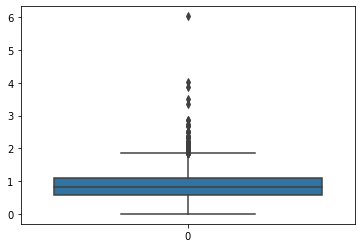

-------------------------------------------------------------------------------
primary_cleaner.output.concentrate_ag
< min, len: 0
Series([], Name: primary_cleaner.output.concentrate_ag, dtype: float64)
> max, len: 0
Series([], Name: primary_cleaner.output.concentrate_ag, dtype: float64)


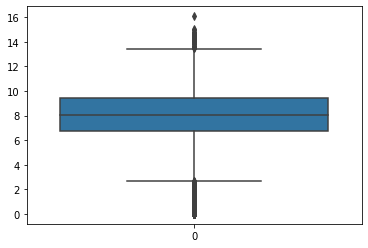

-------------------------------------------------------------------------------
primary_cleaner.output.concentrate_pb
< min, len: 0
Series([], Name: primary_cleaner.output.concentrate_pb, dtype: float64)
> max, len: 0
Series([], Name: primary_cleaner.output.concentrate_pb, dtype: float64)


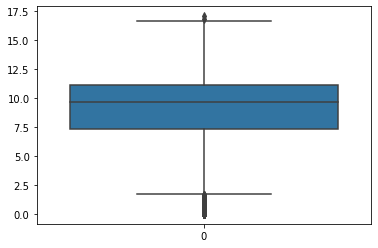

-------------------------------------------------------------------------------
primary_cleaner.output.concentrate_sol
< min, len: 0
Series([], Name: primary_cleaner.output.concentrate_sol, dtype: float64)
> max, len: 0
Series([], Name: primary_cleaner.output.concentrate_sol, dtype: float64)


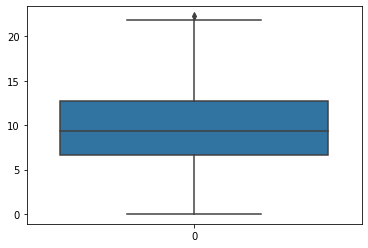

-------------------------------------------------------------------------------
primary_cleaner.output.concentrate_au
< min, len: 0
Series([], Name: primary_cleaner.output.concentrate_au, dtype: float64)
> max, len: 0
Series([], Name: primary_cleaner.output.concentrate_au, dtype: float64)


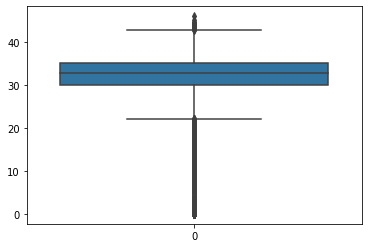

-------------------------------------------------------------------------------
primary_cleaner.output.tail_ag
< min, len: 0
Series([], Name: primary_cleaner.output.tail_ag, dtype: float64)
> max, len: 0
Series([], Name: primary_cleaner.output.tail_ag, dtype: float64)


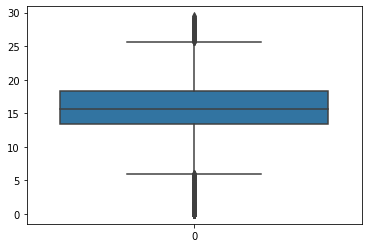

-------------------------------------------------------------------------------
primary_cleaner.output.tail_pb
< min, len: 0
Series([], Name: primary_cleaner.output.tail_pb, dtype: float64)
> max, len: 99
16437    8.727208
16438    8.940834
16439    8.820737
16440    8.465849
16453    8.350386
           ...   
16727    9.086758
16728    8.902401
16729    8.944330
16730    8.882556
16731    8.665583
Name: primary_cleaner.output.tail_pb, Length: 99, dtype: float64


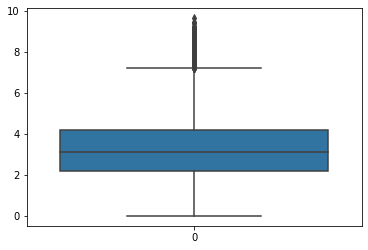

-------------------------------------------------------------------------------
primary_cleaner.output.tail_sol
< min, len: 0
Series([], Name: primary_cleaner.output.tail_sol, dtype: float64)
> max, len: 2
3539    16.270193
6733    16.827989
Name: primary_cleaner.output.tail_sol, dtype: float64


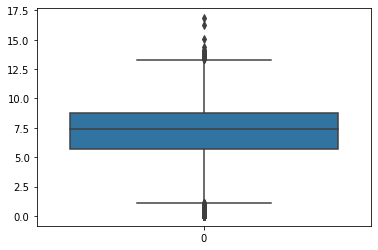

-------------------------------------------------------------------------------
primary_cleaner.output.tail_au
< min, len: 0
Series([], Name: primary_cleaner.output.tail_au, dtype: float64)
> max, len: 213
319      14.158231
320      16.637763
377      18.528821
433      10.414239
503      10.751382
           ...    
16291    10.684878
16309     9.850000
16436    10.084420
16603    12.088570
16666    10.171709
Name: primary_cleaner.output.tail_au, Length: 213, dtype: float64


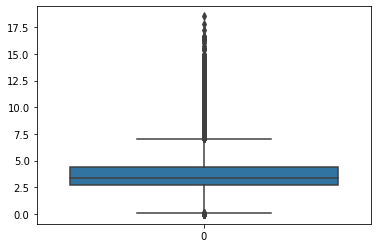

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_a_air
< min, len: 706
1264       2.271851
1794       0.000016
1795       0.000013
1796       0.000011
1797       0.000009
            ...    
16257      0.000000
16258      0.000000
16259      0.000000
16260      0.000000
16261    145.549695
Name: primary_cleaner.state.floatbank8_a_air, Length: 706, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_a_air, dtype: float64)


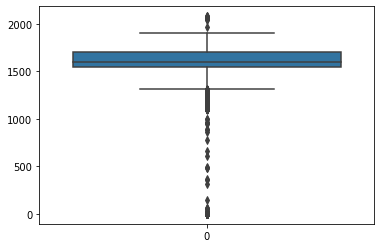

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_a_level
< min, len: 761
385     -792.211057
747     -793.679670
748     -746.869492
1236    -783.423259
1264    -796.049275
            ...    
16260   -778.945520
16261   -781.392047
16499   -764.261732
16500   -772.261188
16598   -763.169284
Name: primary_cleaner.state.floatbank8_a_level, Length: 761, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_a_level, dtype: float64)


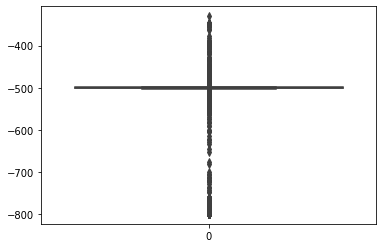

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_b_air
< min, len: 704
1236     481.026769
1264       2.324445
1794       0.000021
1795       0.000018
1796       0.000015
            ...    
16257      0.000000
16258      0.000000
16259      0.000000
16260      0.000000
16261      0.000000
Name: primary_cleaner.state.floatbank8_b_air, Length: 704, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_b_air, dtype: float64)


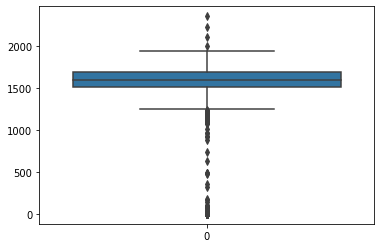

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_b_level
< min, len: 782
385     -799.970682
386     -780.677931
747     -798.981157
748     -780.245633
1236    -777.277573
            ...    
16261   -799.999258
16499   -799.925332
16500   -799.967507
16501   -730.393397
16598   -799.562139
Name: primary_cleaner.state.floatbank8_b_level, Length: 782, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_b_level, dtype: float64)


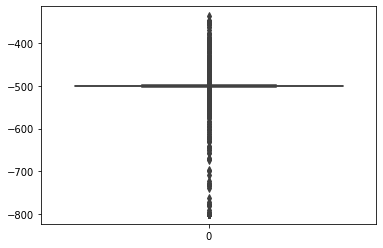

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_c_air
< min, len: 786
1264     0.781485
1794     0.000013
1795     0.000011
1796     0.000009
1797     0.000007
           ...   
16258    0.000000
16259    0.000000
16260    0.000000
16261    0.000000
16598    0.000000
Name: primary_cleaner.state.floatbank8_c_air, Length: 786, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_c_air, dtype: float64)


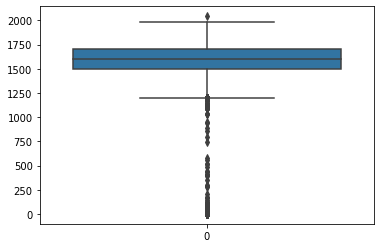

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_c_level
< min, len: 692
385     -799.835175
386     -797.002242
747     -799.908680
748     -799.932238
1236    -756.914721
            ...    
14609   -799.934269
14610   -799.938174
14616   -799.952199
14617   -799.946227
16262   -760.671427
Name: primary_cleaner.state.floatbank8_c_level, Length: 692, dtype: float64
> max, len: 1
12567   -221.857683
Name: primary_cleaner.state.floatbank8_c_level, dtype: float64


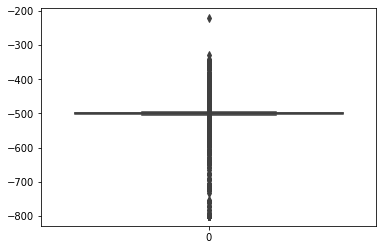

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_d_air
< min, len: 696
1150     126.316856
1236     142.059546
1264       0.655719
1794       1.251214
1795       1.076041
            ...    
16257      0.000000
16258      0.000000
16259      0.000000
16260      0.000000
16261      0.000000
Name: primary_cleaner.state.floatbank8_d_air, Length: 696, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_d_air, dtype: float64)


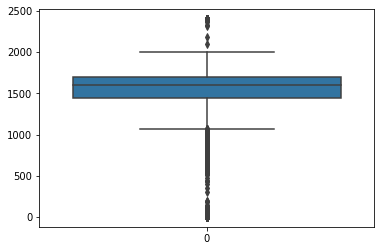

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_d_level
< min, len: 735
385     -799.763636
747     -799.755188
748     -799.775791
1236    -757.869682
1237    -776.044048
            ...    
14609   -799.790621
14610   -799.786366
14616   -799.777670
14617   -786.892203
16499   -797.984439
Name: primary_cleaner.state.floatbank8_d_level, Length: 735, dtype: float64
> max, len: 68
1185    -250.211046
2084    -156.039052
2085    -199.781354
2086    -200.492609
2087    -179.343190
            ...    
12568    -51.678249
12569   -115.966012
14620   -221.008685
16501    -20.654343
16612   -108.083537
Name: primary_cleaner.state.floatbank8_d_level, Length: 68, dtype: float64


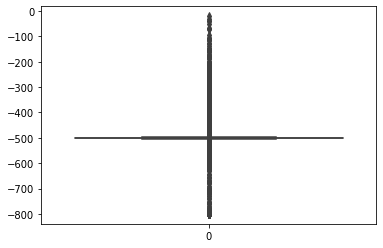

-------------------------------------------------------------------------------
rougher.input.feed_ag
< min, len: 0
Series([], Name: rougher.input.feed_ag, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.feed_ag, dtype: float64)


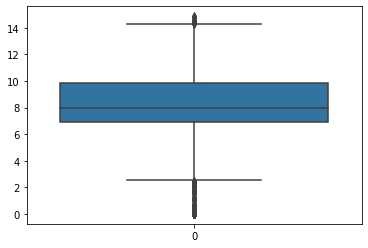

-------------------------------------------------------------------------------
rougher.input.feed_pb
< min, len: 0
Series([], Name: rougher.input.feed_pb, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.feed_pb, dtype: float64)


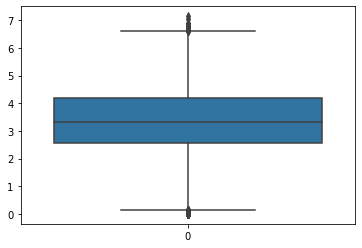

-------------------------------------------------------------------------------
rougher.input.feed_rate
< min, len: 0
Series([], Name: rougher.input.feed_rate, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.feed_rate, dtype: float64)


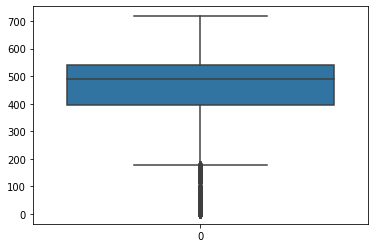

-------------------------------------------------------------------------------
rougher.input.feed_size
< min, len: 0
Series([], Name: rougher.input.feed_size, dtype: float64)
> max, len: 151
4090     255.996704
4604     148.337364
4605     201.009933
4606     201.009720
4607     201.009506
            ...    
11615    309.469856
11616    204.828110
12291    135.131411
12292    150.002096
12638    130.593551
Name: rougher.input.feed_size, Length: 151, dtype: float64


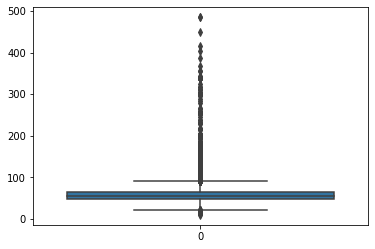

-------------------------------------------------------------------------------
rougher.input.feed_sol
< min, len: 0
Series([], Name: rougher.input.feed_sol, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.feed_sol, dtype: float64)


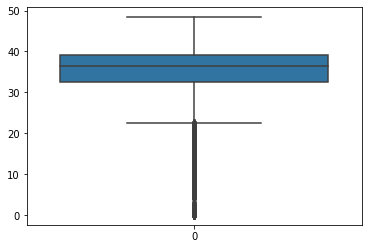

-------------------------------------------------------------------------------
rougher.input.feed_au
< min, len: 0
Series([], Name: rougher.input.feed_au, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.feed_au, dtype: float64)


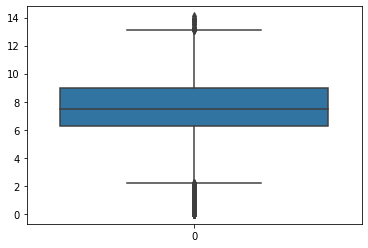

-------------------------------------------------------------------------------
rougher.input.floatbank10_sulfate
< min, len: 0
Series([], Name: rougher.input.floatbank10_sulfate, dtype: float64)
> max, len: 61
9179     30.010759
9180     29.989781
9181     29.994168
9182     29.792026
9183     29.459705
           ...    
9238     25.000968
9239     24.081406
10256    25.000927
10719    36.118275
10720    31.393045
Name: rougher.input.floatbank10_sulfate, Length: 61, dtype: float64


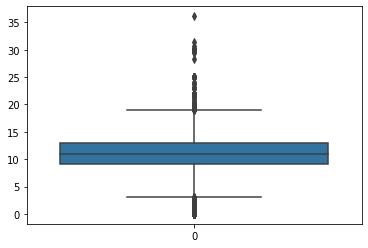

-------------------------------------------------------------------------------
rougher.input.floatbank10_xanthate
< min, len: 0
Series([], Name: rougher.input.floatbank10_xanthate, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.floatbank10_xanthate, dtype: float64)


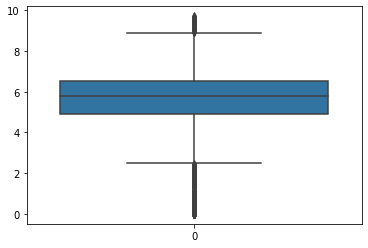

-------------------------------------------------------------------------------
rougher.input.floatbank11_sulfate
< min, len: 0
Series([], Name: rougher.input.floatbank11_sulfate, dtype: float64)
> max, len: 59
9179     28.147300
9180     28.868810
9181     28.355668
9182     28.805167
9183     30.011666
9184     30.007714
9185     30.000021
9186     29.999737
9187     30.004859
9189     29.983783
9191     29.999956
9192     30.007997
9193     30.000297
9194     29.996532
9195     29.997819
9196     30.003764
9197     29.999056
9198     30.003685
9199     29.996807
9200     30.002280
9201     30.003309
9202     30.001328
9203     31.849375
9204     31.849375
9205     29.293596
9206     29.999986
9207     29.995719
9208     30.007855
9209     30.000541
9210     30.006511
9211     29.983985
9212     30.001171
9213     29.999000
9214     30.003168
9215     29.996532
9216     30.002056
9217     30.002701
9218     29.994460
9219     29.992266
9220     30.006327
9222     25.001377
9223     2

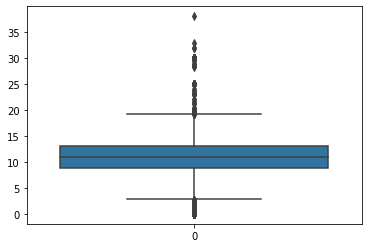

-------------------------------------------------------------------------------
rougher.input.floatbank11_xanthate
< min, len: 0
Series([], Name: rougher.input.floatbank11_xanthate, dtype: float64)
> max, len: 0
Series([], Name: rougher.input.floatbank11_xanthate, dtype: float64)


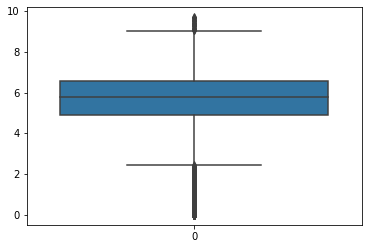

-------------------------------------------------------------------------------
rougher.output.concentrate_ag
< min, len: 0
Series([], Name: rougher.output.concentrate_ag, dtype: float64)
> max, len: 1
4571    23.899102
Name: rougher.output.concentrate_ag, dtype: float64


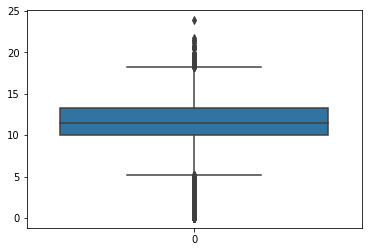

-------------------------------------------------------------------------------
rougher.output.concentrate_pb
< min, len: 0
Series([], Name: rougher.output.concentrate_pb, dtype: float64)
> max, len: 0
Series([], Name: rougher.output.concentrate_pb, dtype: float64)


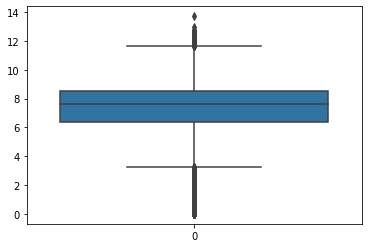

-------------------------------------------------------------------------------
rougher.output.concentrate_sol
< min, len: 0
Series([], Name: rougher.output.concentrate_sol, dtype: float64)
> max, len: 0
Series([], Name: rougher.output.concentrate_sol, dtype: float64)


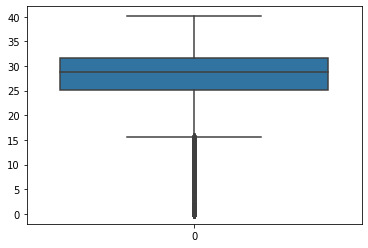

-------------------------------------------------------------------------------
rougher.output.concentrate_au
< min, len: 0
Series([], Name: rougher.output.concentrate_au, dtype: float64)
> max, len: 0
Series([], Name: rougher.output.concentrate_au, dtype: float64)


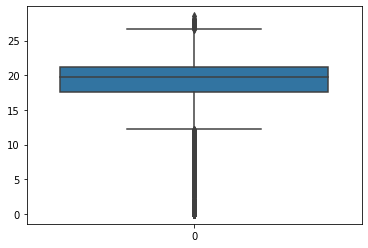

-------------------------------------------------------------------------------
rougher.output.tail_ag
< min, len: 0
Series([], Name: rougher.output.tail_ag, dtype: float64)
> max, len: 4
2918    11.331876
2919    12.719177
2920    11.420091
5037    10.662087
Name: rougher.output.tail_ag, dtype: float64


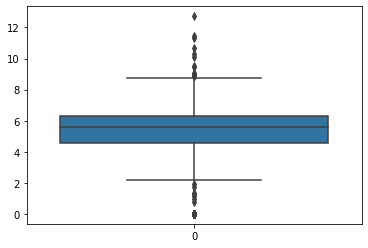

-------------------------------------------------------------------------------
rougher.output.tail_pb
< min, len: 0
Series([], Name: rougher.output.tail_pb, dtype: float64)
> max, len: 110
199      1.625890
377      2.428082
431      1.911709
432      1.840157
433      2.392019
           ...   
11587    2.333291
11604    1.638054
11605    1.628651
15493    2.607765
16478    2.890597
Name: rougher.output.tail_pb, Length: 110, dtype: float64


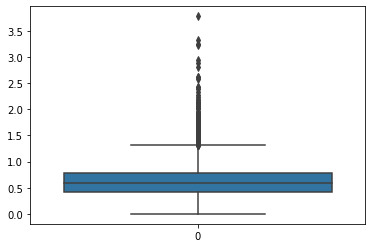

-------------------------------------------------------------------------------
rougher.output.tail_sol
< min, len: 0
Series([], Name: rougher.output.tail_sol, dtype: float64)
> max, len: 11
2508    65.617188
3446    66.117188
3447    57.744391
6464    36.225044
6475    55.722820
6476    61.328399
6489    65.617188
6505    49.234495
6510    65.617188
6511    41.015300
6523    60.353159
Name: rougher.output.tail_sol, dtype: float64


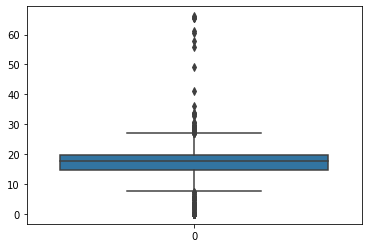

-------------------------------------------------------------------------------
rougher.output.tail_au
< min, len: 0
Series([], Name: rougher.output.tail_au, dtype: float64)
> max, len: 59
377      5.964024
431      4.427079
432      4.340098
433      5.397490
434      4.975921
1199     4.435621
1200     5.386502
1216     4.465724
1622     4.461669
2065     4.467554
2066     4.246704
2068     4.194776
2328     4.333786
2422     4.754550
2423     4.218205
2534     6.023451
2535     5.347254
2536     5.067461
2537     4.841832
2538     4.248815
2591     6.648954
2918     8.181486
2919     9.688980
2920     8.649598
2921     4.212855
2922     4.532655
2923     4.681578
4015     4.506115
4016     4.485173
4159     4.493417
4986     4.575762
4987     4.354918
4988     4.396795
4989     4.590352
4990     4.456486
5037     8.783082
5038     5.132317
5041     4.332711
5098     5.748298
5307     4.441709
5988     4.463010
6819     5.038761
7102     4.411759
7913     4.490564
8627     4.418794
8

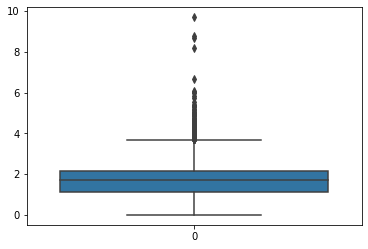

-------------------------------------------------------------------------------
rougher.state.floatbank10_a_air
< min, len: 625
1787     0.072682
1788     0.062954
1789     0.053226
1790     0.043498
1791     0.033770
           ...   
16256   -0.012364
16257   -0.009723
16258   -0.007082
16259   -0.004441
16260   -0.004522
Name: rougher.state.floatbank10_a_air, Length: 625, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_a_air, dtype: float64)


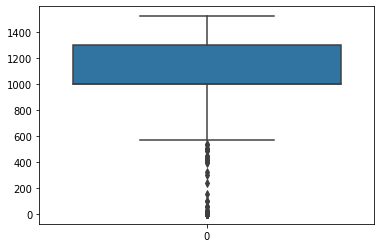

-------------------------------------------------------------------------------
rougher.state.floatbank10_a_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_a_level, dtype: float64)
> max, len: 10
8773   -33.401005
8774   -35.412711
8775   -43.921680
8778   -36.123171
8779   -33.293649
8780   -39.969291
8781   -33.853561
8782   -19.383282
8783   -24.577953
8784   -39.787245
Name: rougher.state.floatbank10_a_level, dtype: float64


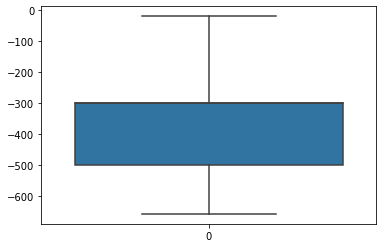

-------------------------------------------------------------------------------
rougher.state.floatbank10_b_air
< min, len: 625
1787    -0.547030
1788    -0.562369
1789    -0.577707
1790    -0.593046
1791    -0.608384
           ...   
16256   -0.392648
16257   -0.410847
16258   -0.468368
16259   -0.533134
16260   -0.597899
Name: rougher.state.floatbank10_b_air, Length: 625, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_b_air, dtype: float64)


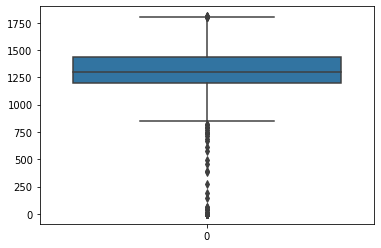

-------------------------------------------------------------------------------
rougher.state.floatbank10_b_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_b_level, dtype: float64)
> max, len: 22
6911   -259.785975
8770   -233.469633
8773      9.457822
8774      6.175685
8775      4.870115
8776      1.486704
8777     -4.847446
8778      6.088654
8779      6.054840
8780      6.454860
8781      5.755560
8782    -47.433991
8783     -7.784675
8784     -7.022328
8785     -5.642165
8786    -50.789688
8787   -167.363669
8788   -252.559847
8794    -83.628506
8795    -16.555761
8796    -23.377897
8797   -225.746634
Name: rougher.state.floatbank10_b_level, dtype: float64


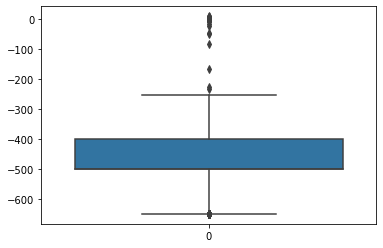

-------------------------------------------------------------------------------
rougher.state.floatbank10_c_air
< min, len: 632
1787    -0.023140
1788    -0.043579
1789    -0.064017
1790    -0.084456
1791    -0.104895
           ...   
16267   -0.086108
16268   -0.098202
16269   -0.110296
16270   -0.115301
16271   -0.091749
Name: rougher.state.floatbank10_c_air, Length: 632, dtype: float64
> max, len: 33
2710    2484.403720
2712    2409.061919
2713    2499.122390
2714    2499.123520
2715    2499.124651
2716    2499.125782
2717    2499.126913
2718    2499.128043
2719    2499.129174
2720    2499.122165
2721    2499.102116
2722    2499.081896
2723    2499.061676
2724    2499.041456
2725    2498.685829
3830    2498.756680
3831    2498.873242
3833    2251.801560
3834    2486.363729
3835    2453.453599
3836    2490.154871
3837    2396.144923
3838    2426.029124
3839    2361.189694
3840    2269.801917
3841    2257.018621
3843    2366.956450
3844    2429.701483
3845    2480.899004
3846    2482

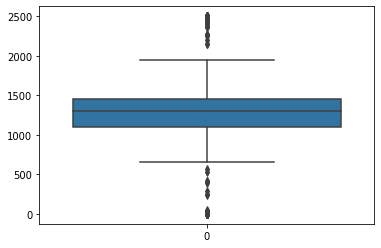

-------------------------------------------------------------------------------
rougher.state.floatbank10_c_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_c_level, dtype: float64)
> max, len: 25
8773    -17.134408
8774    -16.026689
8775    -19.016632
8776    -25.651923
8777    -19.807606
8778    -12.562026
8779    -10.242658
8780    -10.607360
8781    -11.294263
8782    -44.496091
8783    -40.340404
8784    -41.148249
8785    -45.394805
8786    -40.438956
8787    -41.781432
8788    -43.118109
8789    -45.122657
8790    -44.598190
8791    -41.774549
8792    -43.953493
8793    -45.499679
8794    -43.425443
8795    -45.989225
8796    -49.506443
8797   -212.524773
Name: rougher.state.floatbank10_c_level, dtype: float64


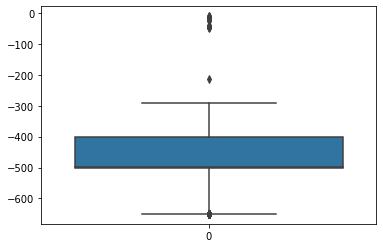

-------------------------------------------------------------------------------
rougher.state.floatbank10_d_air
< min, len: 621
1787    -0.753698
1788    -0.743475
1789    -0.733253
1790    -0.723030
1791    -0.712808
           ...   
16256   -0.655415
16257   -0.677996
16258   -0.712065
16259   -0.748285
16260   -0.784505
Name: rougher.state.floatbank10_d_air, Length: 621, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_d_air, dtype: float64)


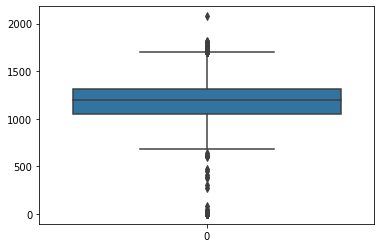

-------------------------------------------------------------------------------
rougher.state.floatbank10_d_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_d_level, dtype: float64)
> max, len: 3
4145     -79.338170
10194   -282.986203
10195   -208.330673
Name: rougher.state.floatbank10_d_level, dtype: float64


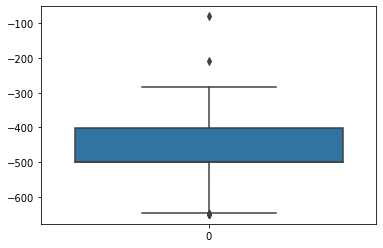

-------------------------------------------------------------------------------
rougher.state.floatbank10_e_air
< min, len: 621
1787     -1.934688
1788     -1.926384
1789     -1.918081
1790     -1.909777
1791     -1.901473
           ...    
16257    -0.616885
16258    -0.645612
16259    -0.678878
16260    -0.712143
16333    94.372023
Name: rougher.state.floatbank10_e_air, Length: 621, dtype: float64
> max, len: 4
372      2330.310425
12510    1922.636637
12511    1922.636637
16499    1940.662007
Name: rougher.state.floatbank10_e_air, dtype: float64


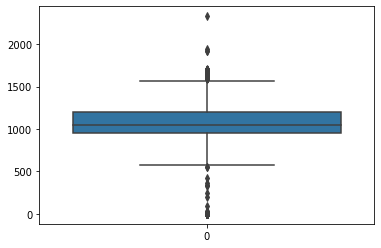

-------------------------------------------------------------------------------
rougher.state.floatbank10_e_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_e_level, dtype: float64)
> max, len: 30
8769    -235.094187
8770    -145.243847
8773      -2.406020
8774      -4.704893
8775      -8.448545
8776      -4.516494
8777      -3.369886
8778      -4.665905
8779      -3.952970
8780      -4.070709
8781      -6.723795
8782     -32.347412
8783     -45.485660
8784     -51.646332
8785     -56.068666
8786     -58.472335
8787     -59.031138
8788     -62.205173
8789     -66.498246
8790     -70.740399
8791     -74.285450
8792     -78.969967
8793     -83.204343
8794     -86.069015
8795     -86.546788
8796     -86.907815
8797    -243.487146
10144   -272.199598
10196   -241.150730
10808   -221.146015
Name: rougher.state.floatbank10_e_level, dtype: float64


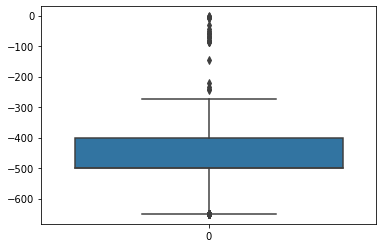

-------------------------------------------------------------------------------
rougher.state.floatbank10_f_air
< min, len: 620
1787    -1.488844
1788    -1.605532
1789    -1.722220
1790    -1.838908
1791    -1.955596
           ...   
16256   -2.356943
16257   -2.362606
16258   -2.388083
16259   -2.417269
16260   -2.446455
Name: rougher.state.floatbank10_f_air, Length: 620, dtype: float64
> max, len: 1
372    1950.493751
Name: rougher.state.floatbank10_f_air, dtype: float64


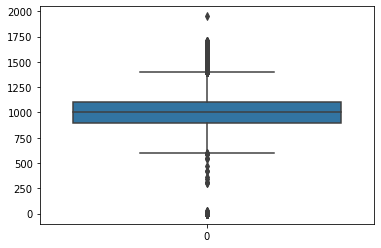

-------------------------------------------------------------------------------
rougher.state.floatbank10_f_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_f_level, dtype: float64)
> max, len: 38
3048     -54.295618
4143     -21.745268
4144     -22.092079
4145     -22.308541
8767     -31.747973
8768     -28.287244
8769     -28.935892
8770     -42.225584
8773     -88.590972
8774     -88.613815
8775     -88.656542
8776     -88.699270
8777     -88.741997
8778     -89.142793
8779     -99.187329
8780    -105.351287
8781    -106.031908
8787    -257.785094
8788    -231.514966
8789    -236.081614
8790    -239.847372
8791    -242.656266
8792    -244.771776
8793    -252.276965
8794    -256.161438
8795    -265.014863
8828    -191.718480
10281   -258.300939
10809   -229.872332
13188    -58.512307
13189   -181.791424
16217   -157.701120
16218   -267.009374
16242   -234.903869
16259   -252.078393
16264   -136.888631
16265   -122.308851
16266   -257.114818
Name: rougher.state.floatbank

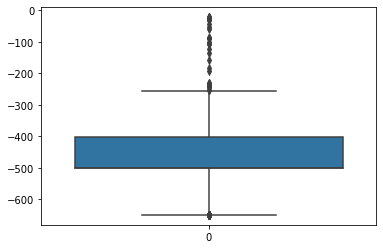

-------------------------------------------------------------------------------
secondary_cleaner.output.tail_ag
< min, len: 0
Series([], Name: secondary_cleaner.output.tail_ag, dtype: float64)
> max, len: 0
Series([], Name: secondary_cleaner.output.tail_ag, dtype: float64)


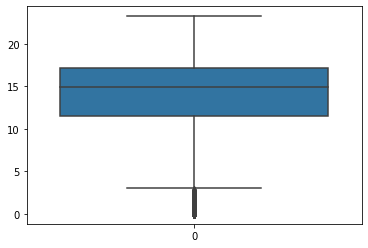

-------------------------------------------------------------------------------
secondary_cleaner.output.tail_pb
< min, len: 0
Series([], Name: secondary_cleaner.output.tail_pb, dtype: float64)
> max, len: 38
15957    14.931035
15958    15.000112
15959    15.267886
15960    15.574693
15961    15.665603
15962    15.780901
15963    15.454680
15964    15.469289
15965    16.094007
15966    16.310803
15967    16.432727
15968    16.788706
15969    16.784315
15970    16.707874
15971    16.421468
15972    16.783706
15973    17.028828
15974    17.042505
15975    16.656277
15976    15.851405
15977    15.417965
15978    15.726402
15979    15.741514
15980    15.406128
15981    15.189335
15983    15.583017
15984    15.347995
15985    15.453005
15986    15.796208
15987    16.027742
15988    16.052657
15989    15.752563
15990    15.725585
15991    15.748498
15992    15.485991
16092    15.600029
16093    15.333739
16094    15.118662
Name: secondary_cleaner.output.tail_pb, dtype: float64


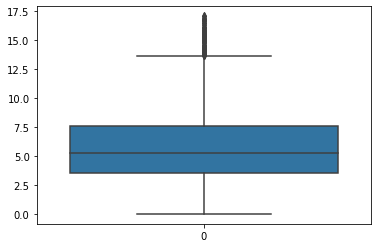

-------------------------------------------------------------------------------
secondary_cleaner.output.tail_sol
< min, len: 0
Series([], Name: secondary_cleaner.output.tail_sol, dtype: float64)
> max, len: 0
Series([], Name: secondary_cleaner.output.tail_sol, dtype: float64)


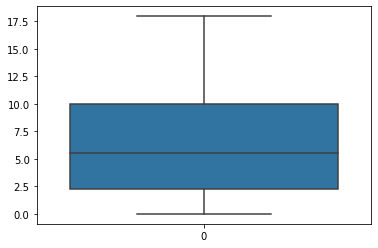

-------------------------------------------------------------------------------
secondary_cleaner.output.tail_au
< min, len: 0
Series([], Name: secondary_cleaner.output.tail_au, dtype: float64)
> max, len: 235
319      16.423059
320      15.612861
376      19.019103
377      17.761642
432      11.961608
           ...    
16700    13.935479
16701    14.822218
16702    13.031525
16703    12.127581
16804    12.409929
Name: secondary_cleaner.output.tail_au, Length: 235, dtype: float64


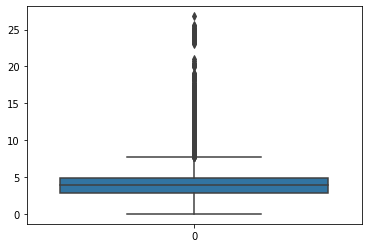

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_a_air
< min, len: 427
376      0.077503
377      0.731049
1253     3.983811
1254     3.859636
1255     3.671324
           ...   
14585    2.968066
14608    4.393438
14609    3.294449
16265    3.793007
16266    4.302620
Name: secondary_cleaner.state.floatbank2_a_air, Length: 427, dtype: float64
> max, len: 13
6915     53.846799
6916     58.194460
8651     60.000000
8652     60.000000
8653     60.000000
8654     60.000000
8655     60.000000
8656     60.000000
8657     60.000000
8658     60.000000
8659     60.000000
14434    52.651399
16501    60.000000
Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64


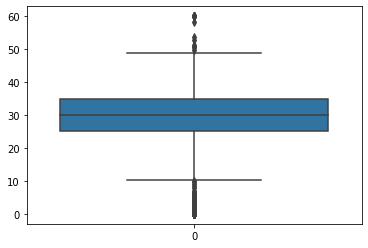

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_a_level
< min, len: 1195
747     -799.304422
1250    -799.335105
1251    -799.339959
1252    -799.344812
1253    -799.349666
            ...    
16259   -787.129728
16261   -780.938179
16262   -783.028236
16263   -784.166152
16264   -782.466753
Name: secondary_cleaner.state.floatbank2_a_level, Length: 1195, dtype: float64
> max, len: 21
1205   -238.030516
1207   -218.020163
1208   -194.455620
1209   -203.804751
1210   -208.552358
1236   -152.858179
1244   -127.875565
1245   -216.455289
1264   -238.885936
2217   -243.649823
3048   -136.614302
3049   -170.067266
3050   -159.651987
3051   -165.573260
3052   -188.865950
5740   -237.695960
5741   -166.933103
5742   -172.639078
5743   -179.583857
5744   -163.713850
5745   -207.068023
Name: secondary_cleaner.state.floatbank2_a_level, dtype: float64


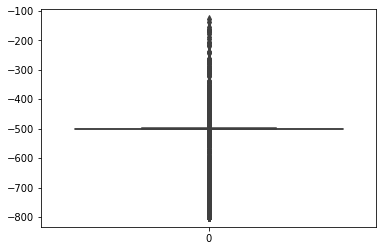

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_b_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64)
> max, len: 1
6916    51.093216
Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64


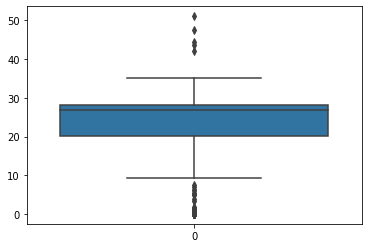

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_b_level
< min, len: 809
385     -777.921966
1250    -789.546033
1251    -789.397027
1252    -789.248021
1253    -789.099015
            ...    
16263   -798.431069
16264   -798.139104
16265   -796.844946
16499   -798.338307
16598   -799.667057
Name: secondary_cleaner.state.floatbank2_b_level, Length: 809, dtype: float64
> max, len: 14
8605   -253.629417
8606   -238.918764
8607   -216.660814
8610   -241.629454
8611   -255.332710
8612   -224.828326
8614   -251.702741
8621   -221.684802
8624   -212.064665
8627   -225.629857
8633   -223.045323
8634   -232.071549
8635   -235.583801
8644   -251.527018
Name: secondary_cleaner.state.floatbank2_b_level, dtype: float64


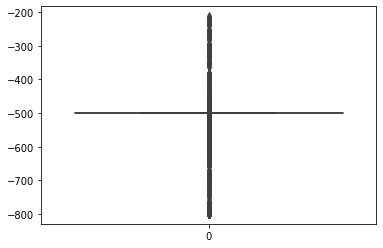

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_a_air
< min, len: 635
376      1.511458e-07
377      6.258401e-08
385      0.000000e+00
747      1.430474e-18
748      3.303329e-18
             ...     
16269    8.904035e-04
16270    5.975339e-04
16271    3.046643e-04
16272    1.273934e+00
16499    0.000000e+00
Name: secondary_cleaner.state.floatbank3_a_air, Length: 635, dtype: float64
> max, len: 2
6912    60.0
6913    60.0
Name: secondary_cleaner.state.floatbank3_a_air, dtype: float64


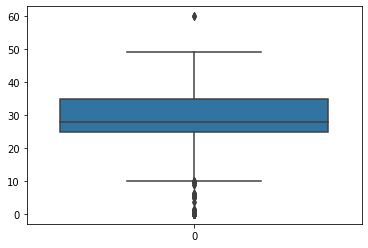

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_a_level
< min, len: 746
385     -799.208003
386     -795.326639
747     -799.434460
1313    -799.439133
1650    -742.844905
            ...    
16261   -798.494827
16262   -798.185577
16263   -739.847501
16499   -789.838905
16598   -758.515727
Name: secondary_cleaner.state.floatbank3_a_level, Length: 746, dtype: float64
> max, len: 3
834    -191.678810
837    -205.808042
3048   -241.912396
Name: secondary_cleaner.state.floatbank3_a_level, dtype: float64


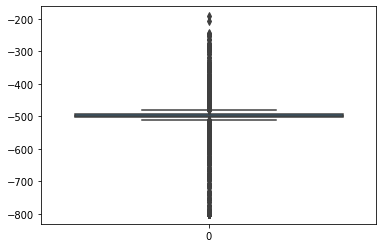

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_b_air
< min, len: 638
376      0.000078
377      0.000032
385      0.000000
747      0.000000
1790     0.000253
           ...   
16269    0.050763
16270    0.034051
16271    0.017339
16272    1.369083
16499    0.000000
Name: secondary_cleaner.state.floatbank3_b_air, Length: 638, dtype: float64
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64)


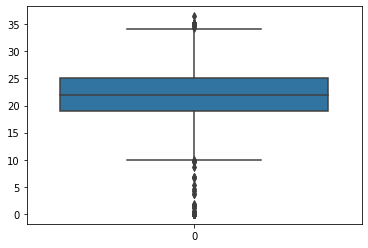

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_b_level
< min, len: 756
385     -786.930948
386     -776.585622
1313    -784.341162
1789    -787.742506
1790    -788.395388
            ...    
16258   -809.215601
16259   -809.012527
16260   -808.809454
16261   -808.606380
16262   -808.403307
Name: secondary_cleaner.state.floatbank3_b_level, Length: 756, dtype: float64
> max, len: 61
1237    -251.828603
1239    -281.629497
2241    -195.458545
2242    -276.800676
2379    -234.959854
            ...    
13467   -246.792224
13468   -245.394978
13469   -255.048889
13470   -268.969689
13471   -277.758481
Name: secondary_cleaner.state.floatbank3_b_level, Length: 61, dtype: float64


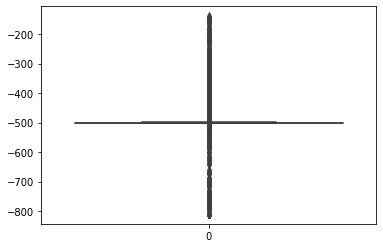

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_a_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64)
> max, len: 3
11536    57.554445
11537    57.998922
11538    58.016889
Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64


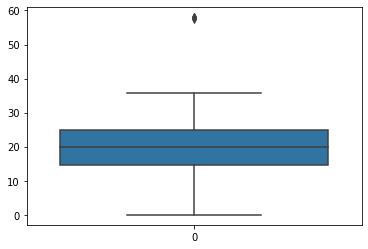

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_a_level
< min, len: 766
99      -799.601232
100     -799.600946
101     -799.600659
102     -799.600372
103     -799.600085
            ...    
16257   -799.653900
16258   -799.656551
16259   -799.666110
16271   -755.482454
16499   -799.708528
Name: secondary_cleaner.state.floatbank4_a_level, Length: 766, dtype: float64
> max, len: 3
14653   -245.239184
16600   -240.370737
16601   -153.451272
Name: secondary_cleaner.state.floatbank4_a_level, dtype: float64


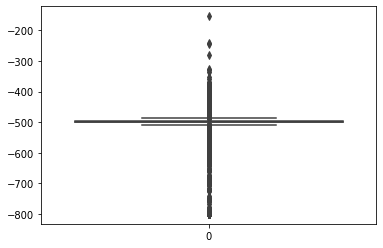

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_b_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64)
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64)


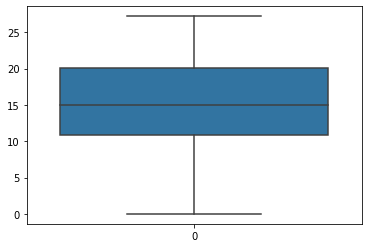

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_b_level
< min, len: 634
385     -799.718554
747     -799.706590
1313    -799.618543
1314    -776.891696
1929    -799.708107
            ...    
16255   -777.720592
16256   -776.995807
16257   -776.259918
16258   -775.337957
16259   -774.349622
Name: secondary_cleaner.state.floatbank4_b_level, Length: 634, dtype: float64
> max, len: 17
2044    -201.982291
2139    -202.126532
2140    -189.647989
8600    -163.742242
11629   -130.589441
11630   -126.182952
11631   -113.339067
11632   -172.029711
13734   -145.071088
14361   -176.411320
14576   -194.932531
14577   -181.264295
14653   -175.284772
15735   -193.112827
16525   -187.367496
16600   -161.049087
16601    -81.278995
Name: secondary_cleaner.state.floatbank4_b_level, dtype: float64


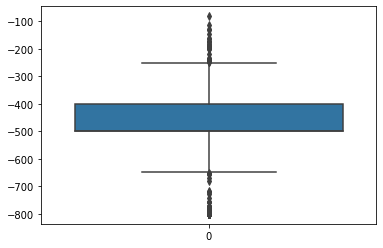

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_a_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64)
> max, len: 7
4358     40.527659
4359     41.442307
4360     42.077701
7840     43.709931
11536    63.113341
11537    63.114820
11538    63.116298
Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64


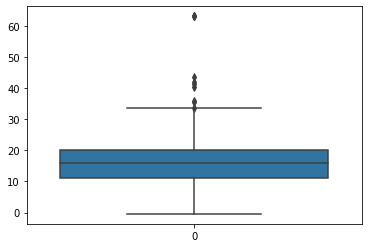

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_a_level
< min, len: 741
385     -794.230011
747     -770.246610
850     -797.142475
851     -795.690686
852     -796.246273
            ...    
16256   -771.598493
16257   -772.412587
16258   -774.481241
16259   -733.086133
16598   -752.526118
Name: secondary_cleaner.state.floatbank5_a_level, Length: 741, dtype: float64
> max, len: 1
4356   -275.073125
Name: secondary_cleaner.state.floatbank5_a_level, dtype: float64


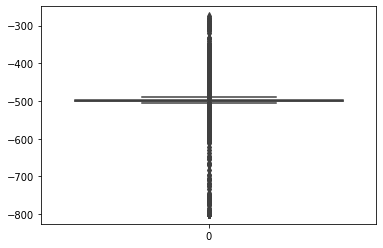

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_b_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64)
> max, len: 3
11536    35.302464
11537    35.738917
11538    35.729282
Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64


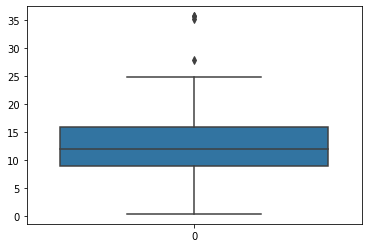

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_b_level
< min, len: 766
385     -799.939988
747     -796.419696
748     -761.162522
785     -743.113601
850     -799.947726
            ...    
16257   -799.993211
16258   -799.681900
16259   -799.150063
16499   -765.010210
16598   -799.649084
Name: secondary_cleaner.state.floatbank5_b_level, Length: 766, dtype: float64
> max, len: 71
1316    -134.124679
1782    -188.194032
1783    -133.596399
1784    -130.584142
1785    -131.268159
            ...    
13966   -241.233280
14575   -216.884144
14576   -120.405706
14577   -211.141489
16601   -192.606279
Name: secondary_cleaner.state.floatbank5_b_level, Length: 71, dtype: float64


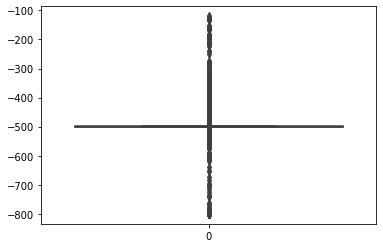

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank6_a_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64)
> max, len: 3
11536    54.649065
11537    54.850145
11538    54.876806
Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64


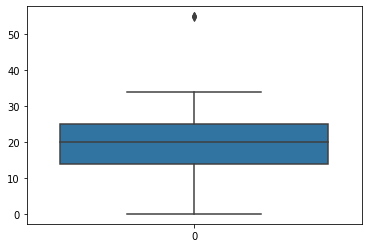

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank6_a_level
< min, len: 760
385     -799.734650
1313    -790.360185
1789    -769.069192
1790    -799.795454
1791    -799.790899
            ...    
16672   -799.865244
16673   -800.751466
16674   -801.091733
16676   -800.484224
16677   -795.549122
Name: secondary_cleaner.state.floatbank6_a_level, Length: 760, dtype: float64
> max, len: 36
852     -215.678581
1122    -294.814879
1316    -221.553886
1783    -215.948664
1784    -173.122711
1785    -177.840981
1786    -166.913588
1927    -260.799635
4028    -203.923380
4029    -220.238473
4035    -249.410318
4036    -206.816962
4037    -204.752479
4038    -196.679310
4039    -196.150358
4040    -196.022055
4041    -195.893751
4042    -195.765448
4043    -195.476414
4044    -194.492504
4045    -250.716732
5611    -273.022498
6913    -192.874107
6914    -178.628288
6915    -161.946507
6916    -177.036340
8179    -104.427459
13467   

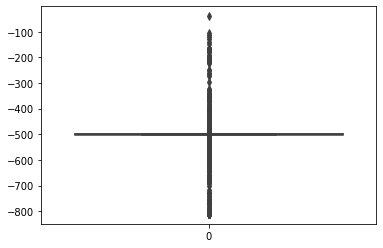

-------------------------------------------------------------------------------


In [150]:
#Outlier visualization and search function
vr = data_train_1.drop(['date'],axis=1)#I select the columns necessary for analysis
for i in vr.columns:
    meen = float(data_train_1[i].mean())#Column mean from loop
    maxx = meen + float(data_train_1[i].std())*3#maximum threshold
    minn = meen - float(data_train_1[i].std())*3#minimum threshold
    print(i)#Displaying information about the column in question
    print('< min, len:', len(data_train_1.loc[data_train_1[i]<minn][i]))#Displaying information about the column in question
    print(data_train_1.loc[data_train_1[i]<minn][i])#String output
    print('> max, len:', len(data_train_1.loc[data_train_1[i]>maxx][i]))#Displaying information about the column in question
    print(data_train_1.loc[data_train_1[i]>maxx][i])#String output
    ax = sns.boxplot(data=data_train_1[i])#Building a boxplot 
    plt.show()
    print('-------------------------------------------------------------------------------')#end of column information

By analyzing the output of the code above, I decide what to do with the outliers.

primary_cleaner.state.floatbank8_a_level and primary_cleaner.state.floatbank8_a_air have similar values ​​below 3x standard deviation - most likely these are not outliers (it is unlikely that both columns have the same outliers, although they are codependent), it is difficult to point specifically to outliers further, since gold - this is a natural raw material, and in nature there can be anything, this will already be prompted by a specialist who deals with all those. process. I did not find any obvious outliers.

I will do the same for the test dataset.

primary_cleaner.input.sulfate
< min, len: 81
30       5.039223
245     15.630879
250      0.006980
314      7.685543
315      7.685543
          ...    
5492     1.900473
5508    20.015311
5509    23.825205
5711    30.025294
5750    25.265934
Name: primary_cleaner.input.sulfate, Length: 81, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.input.sulfate, dtype: float64)


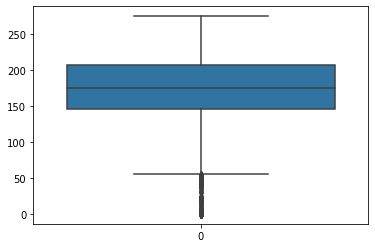

-------------------------------------------------------------------------------
primary_cleaner.input.depressant
< min, len: 0
Series([], Name: primary_cleaner.input.depressant, dtype: float64)
> max, len: 21
1095    19.404826
1096    19.992563
1097    20.038590
1098    20.028326
1099    19.966160
1100    19.998663
1101    19.984205
1102    20.030388
1103    20.012406
1104    20.045827
1105    20.009836
1106    19.966766
1107    20.006497
1108    20.046764
1109    19.989534
1110    19.982704
1111    20.016120
1112    20.001539
1113    20.012914
1114    20.024613
1115    18.576390
Name: primary_cleaner.input.depressant, dtype: float64


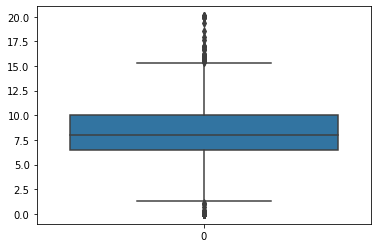

-------------------------------------------------------------------------------
primary_cleaner.input.feed_size
< min, len: 0
Series([], Name: primary_cleaner.input.feed_size, dtype: float64)
> max, len: 42
2453     9.580000
2454     9.580000
2455     9.580000
2456     9.580000
2457     9.580000
2458     9.580000
2459     9.580000
2460     9.580000
2461     9.580000
2462     9.580000
2463     9.580000
2464     9.580000
2465     9.580000
2466     9.580000
4583     9.620000
5045     9.630000
5046     9.630000
5047     9.630000
5048     9.630000
5049     9.630000
5050     9.630000
5328     9.769998
5329     9.770000
5383     9.340000
5384     9.340000
5385     9.340000
5386     9.340000
5387     9.340000
5388     9.340000
5389     9.340000
5390     9.340000
5391     9.340000
5392     9.340000
5393     9.340000
5394     9.340000
5511    15.500000
5512    11.470008
5561     9.160000
5693     9.300000
5694     9.300000
5695     9.300000
5696     9.300000
Name: primary_cleaner.input.feed_size

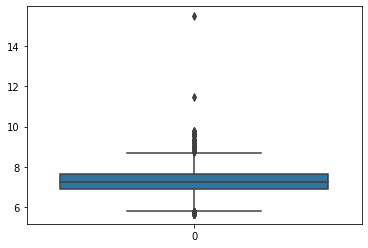

-------------------------------------------------------------------------------
primary_cleaner.input.xanthate
< min, len: 0
Series([], Name: primary_cleaner.input.xanthate, dtype: float64)
> max, len: 69
525     4.702909
4781    3.983345
4782    3.980995
4783    3.994607
4784    4.014188
          ...   
4854    3.878231
4855    3.799091
4856    3.815279
4857    3.751783
4858    3.505338
Name: primary_cleaner.input.xanthate, Length: 69, dtype: float64


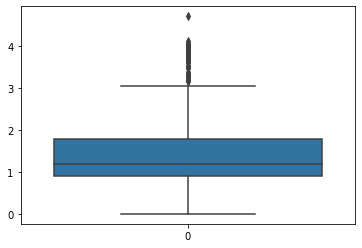

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_a_air
< min, len: 93
30      412.629243
531       0.000008
532       0.000007
536       0.000002
537       0.000001
           ...    
3082      0.000000
3083      0.000000
3084    212.393142
3922    302.077511
5479    745.179890
Name: primary_cleaner.state.floatbank8_a_air, Length: 93, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_a_air, dtype: float64)


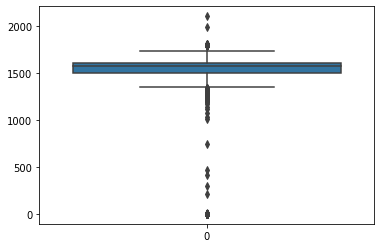

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_a_level
< min, len: 103
30     -795.316337
247    -752.693115
248    -794.938526
250    -795.788194
311    -720.502068
           ...    
3923   -793.065419
3924   -692.580910
3929   -783.448551
5085   -640.876622
5479   -758.237701
Name: primary_cleaner.state.floatbank8_a_level, Length: 103, dtype: float64
> max, len: 5
4521    -57.195404
4818   -282.988443
4951   -189.696878
5739   -201.716950
5751   -317.720272
Name: primary_cleaner.state.floatbank8_a_level, dtype: float64


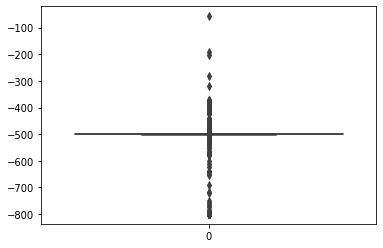

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_b_air
< min, len: 93
30      413.703253
531       0.020780
532       0.017875
536       0.006253
537       0.003347
           ...    
3082      0.000000
3083      0.000000
3084    184.484173
3922    120.405222
5479    744.276655
Name: primary_cleaner.state.floatbank8_b_air, Length: 93, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_b_air, dtype: float64)


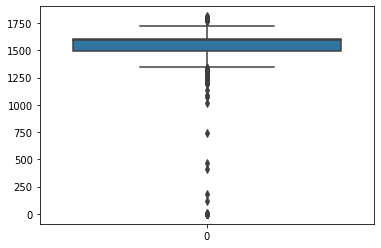

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_b_level
< min, len: 143
30     -787.396567
248    -798.079260
250    -798.922748
530    -692.384429
531    -799.977077
           ...    
5504   -746.967330
5507   -762.248446
5508   -762.546042
5509   -776.720042
5510   -794.643265
Name: primary_cleaner.state.floatbank8_b_level, Length: 143, dtype: float64
> max, len: 7
4165   -246.047833
4521   -142.527229
4818   -238.807102
5666   -341.660086
5739   -229.287302
5751   -322.798010
5801   -339.751525
Name: primary_cleaner.state.floatbank8_b_level, dtype: float64


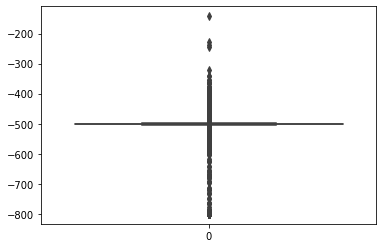

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_c_air
< min, len: 95
30      441.604260
530     753.173113
531       1.892042
532       1.624374
536       0.553702
           ...    
3083      0.000000
3084    146.675858
3922     82.544158
3929    212.035417
5479    744.975758
Name: primary_cleaner.state.floatbank8_c_air, Length: 95, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_c_air, dtype: float64)


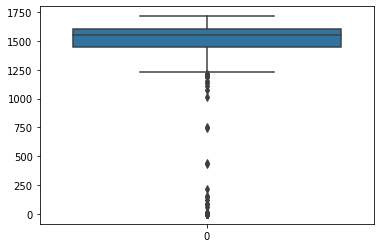

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_c_level
< min, len: 105
30     -799.942901
247    -798.693155
248    -798.870545
250    -799.225326
530    -680.266327
           ...    
4765   -644.603281
5085   -655.515859
5176   -677.060622
5177   -786.260257
5479   -749.357919
Name: primary_cleaner.state.floatbank8_c_level, Length: 105, dtype: float64
> max, len: 7
3792   -332.342350
4327   -290.845404
4521   -150.937035
4814   -350.230095
4818   -229.338520
5739   -356.032383
5751   -310.664624
Name: primary_cleaner.state.floatbank8_c_level, dtype: float64


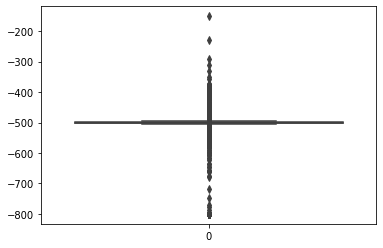

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_d_air
< min, len: 93
30      277.949611
531       0.009901
532       0.008500
536       0.002897
537       0.001497
           ...    
3082      0.000000
3083      0.000000
3084    108.375944
3922     76.816797
5479    742.908955
Name: primary_cleaner.state.floatbank8_d_air, Length: 93, dtype: float64
> max, len: 0
Series([], Name: primary_cleaner.state.floatbank8_d_air, dtype: float64)


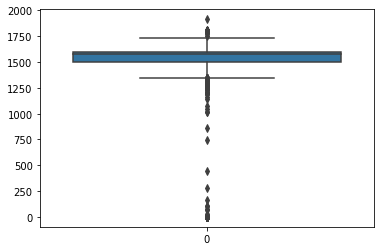

-------------------------------------------------------------------------------
primary_cleaner.state.floatbank8_d_level
< min, len: 137
30     -799.760111
247    -799.777217
248    -799.779800
250    -799.784965
531    -799.781385
           ...    
5177   -798.968467
5233   -742.959888
5757   -712.210065
5758   -797.805517
5759   -794.101875
Name: primary_cleaner.state.floatbank8_d_level, Length: 137, dtype: float64
> max, len: 14
2083   -350.573339
2953   -347.865121
3791   -318.832047
3792    -32.449456
3793    -63.808516
4796   -330.582017
4797   -346.943416
4814   -210.852347
4818   -158.950573
4819   -336.695147
5739   -191.457407
5751   -281.404802
5752   -341.597473
5754   -349.135768
Name: primary_cleaner.state.floatbank8_d_level, dtype: float64


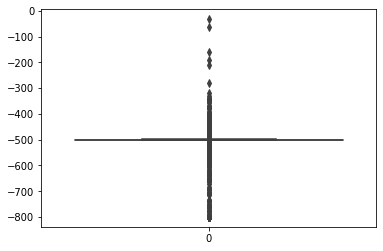

-------------------------------------------------------------------------------
rougher.input.feed_ag
< min, len: 222
30      0.568441
169     0.000000
170     0.000000
171     0.000000
245     0.000000
          ...   
5201    0.000000
5383    0.167397
5478    0.000000
5479    0.000000
5492    0.000000
Name: rougher.input.feed_ag, Length: 222, dtype: float64
> max, len: 0
Series([], Name: rougher.input.feed_ag, dtype: float64)


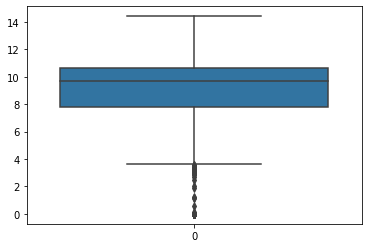

-------------------------------------------------------------------------------
rougher.input.feed_pb
< min, len: 221
169     0.000000
170     0.000000
171     0.000000
245     0.000000
246     0.000000
          ...   
5201    0.000000
5383    0.038416
5478    0.000000
5479    0.000000
5492    0.000000
Name: rougher.input.feed_pb, Length: 221, dtype: float64
> max, len: 0
Series([], Name: rougher.input.feed_pb, dtype: float64)


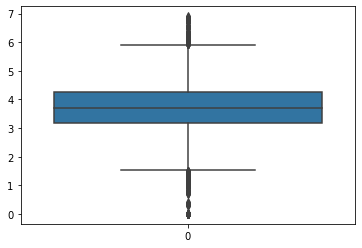

-------------------------------------------------------------------------------
rougher.input.feed_rate
< min, len: 215
30       0.185161
244      0.330646
245      0.314891
246      0.307816
247      0.308656
          ...    
5195    10.639383
5476    10.637461
5477     0.002986
5478     0.005359
5479     0.008875
Name: rougher.input.feed_rate, Length: 215, dtype: float64
> max, len: 0
Series([], Name: rougher.input.feed_rate, dtype: float64)


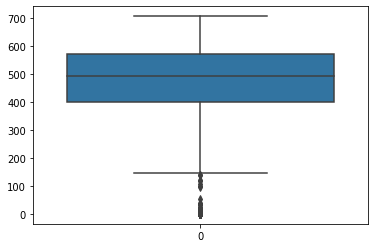

-------------------------------------------------------------------------------
rougher.input.feed_size
< min, len: 0
Series([], Name: rougher.input.feed_size, dtype: float64)
> max, len: 65
1598    133.860529
1599    137.484659
1600    255.254634
1601    136.252925
1602    363.989699
           ...    
4668    243.260257
4669    368.035882
4670    339.283861
4671    338.615688
4672    392.494040
Name: rougher.input.feed_size, Length: 65, dtype: float64


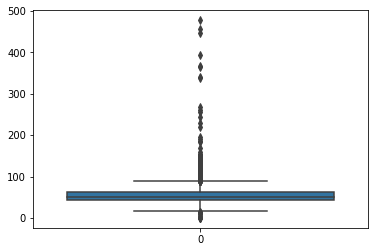

-------------------------------------------------------------------------------
rougher.input.feed_sol
< min, len: 228
30      3.091118
169     0.000000
170     0.000000
171     0.000000
245     0.000000
          ...   
5201    0.000000
5383    0.951007
5478    0.000000
5479    0.000000
5492    0.000000
Name: rougher.input.feed_sol, Length: 228, dtype: float64
> max, len: 0
Series([], Name: rougher.input.feed_sol, dtype: float64)


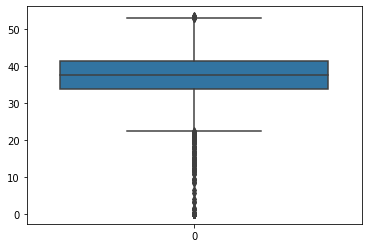

-------------------------------------------------------------------------------
rougher.input.feed_au
< min, len: 225
30      0.568632
169     0.000000
170     0.000000
171     0.000000
245     0.000000
          ...   
5201    0.000000
5383    0.172861
5478    0.000000
5479    0.000000
5492    0.000000
Name: rougher.input.feed_au, Length: 225, dtype: float64
> max, len: 0
Series([], Name: rougher.input.feed_au, dtype: float64)


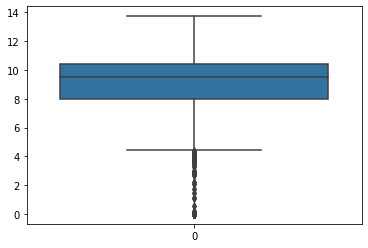

-------------------------------------------------------------------------------
rougher.input.floatbank10_sulfate
< min, len: 233
30      0.002121
245     0.012326
246     0.014865
247     0.014267
248     0.000986
          ...   
4553    0.011696
4554    0.013054
5087    0.002683
5478    0.357758
5479    0.210970
Name: rougher.input.floatbank10_sulfate, Length: 233, dtype: float64
> max, len: 0
Series([], Name: rougher.input.floatbank10_sulfate, dtype: float64)


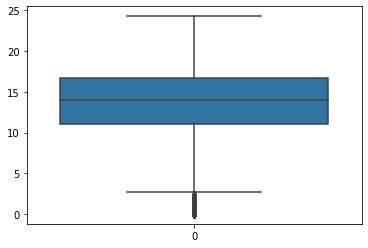

-------------------------------------------------------------------------------
rougher.input.floatbank10_xanthate
< min, len: 229
30      0.005559
245     0.011198
246     0.007230
247     0.012086
248     0.012771
          ...   
4554    0.002943
5087    0.001963
5201    0.742667
5478    0.001603
5479    0.003614
Name: rougher.input.floatbank10_xanthate, Length: 229, dtype: float64
> max, len: 4
556    12.971327
557    13.037750
559    12.030108
563    11.608586
Name: rougher.input.floatbank10_xanthate, dtype: float64


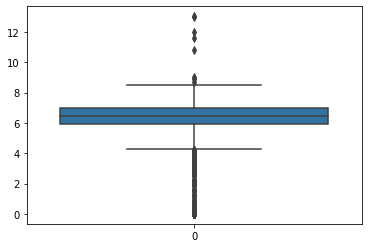

-------------------------------------------------------------------------------
rougher.input.floatbank11_sulfate
< min, len: 205
30      0.002121
245     0.040345
246     0.001385
247     0.006609
248     0.003417
          ...   
5725    0.188037
5726    0.183465
5727    0.180681
5728    0.167784
5729    0.166596
Name: rougher.input.floatbank11_sulfate, Length: 205, dtype: float64
> max, len: 1
526    28.949609
Name: rougher.input.floatbank11_sulfate, dtype: float64


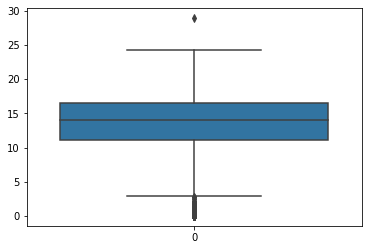

-------------------------------------------------------------------------------
rougher.input.floatbank11_xanthate
< min, len: 177
30      0.017055
244     1.873788
245     0.011198
246     0.007230
247     0.012086
          ...   
5478    0.125443
5479    0.003614
5492    0.060711
5504    2.045122
5711    1.057314
Name: rougher.input.floatbank11_xanthate, Length: 177, dtype: float64
> max, len: 6
556    12.971327
557    13.037750
558    10.836782
559    12.030108
563    11.608586
657    18.709478
Name: rougher.input.floatbank11_xanthate, dtype: float64


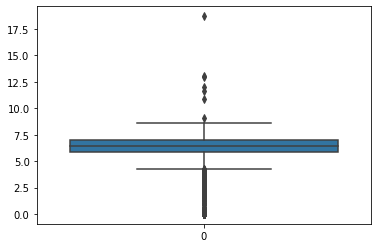

-------------------------------------------------------------------------------
rougher.state.floatbank10_a_air
< min, len: 97
528       0.055453
530       0.036857
531       0.027559
532       0.018261
536      -0.011353
           ...    
3082      0.012684
3083      0.023509
3084     49.765073
4122    498.976414
4124    500.435697
Name: rougher.state.floatbank10_a_air, Length: 97, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_a_air, dtype: float64)


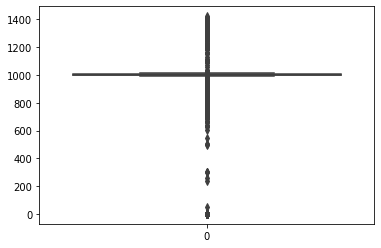

-------------------------------------------------------------------------------
rougher.state.floatbank10_a_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_a_level, dtype: float64)
> max, len: 0
Series([], Name: rougher.state.floatbank10_a_level, dtype: float64)


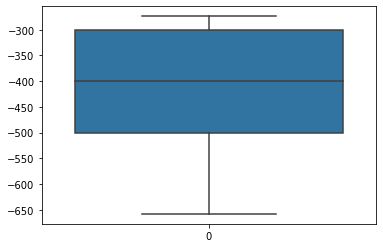

-------------------------------------------------------------------------------
rougher.state.floatbank10_b_air
< min, len: 92
528      -0.344483
530      -0.388149
531      -0.409982
532      -0.431815
536      -0.513933
           ...    
3081     -0.387416
3082     -0.417105
3083     -0.446794
3084    149.818272
3922    575.374033
Name: rougher.state.floatbank10_b_air, Length: 92, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_b_air, dtype: float64)


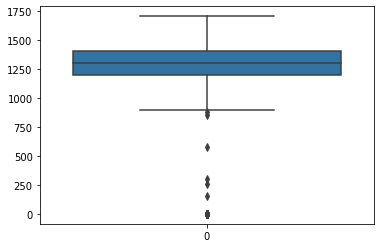

-------------------------------------------------------------------------------
rougher.state.floatbank10_b_level
< min, len: 103
30     -650.245277
247    -650.162694
248    -650.148977
250    -650.121542
527    -650.111619
           ...    
3082   -650.203308
3083   -650.184047
3084   -650.150077
3923   -639.663832
3924   -649.586479
Name: rougher.state.floatbank10_b_level, Length: 103, dtype: float64
> max, len: 64
1110   -300.203153
1111   -299.831167
1112   -299.435610
1113   -298.910603
1114   -301.007350
           ...    
4669   -299.260933
4670   -300.520720
4671   -299.640797
4672   -300.175507
4673   -301.886518
Name: rougher.state.floatbank10_b_level, Length: 64, dtype: float64


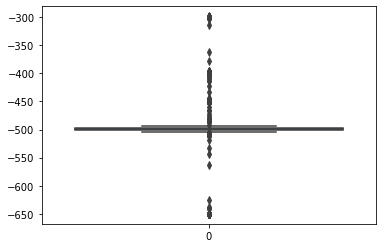

-------------------------------------------------------------------------------
rougher.state.floatbank10_c_air
< min, len: 91
528      -0.143333
530      -0.108782
531      -0.091506
532      -0.074230
536      -0.015478
           ...    
3080     -0.018378
3081     -0.014439
3082     -0.010500
3083     -0.006561
3084    149.237293
Name: rougher.state.floatbank10_c_air, Length: 91, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_c_air, dtype: float64)


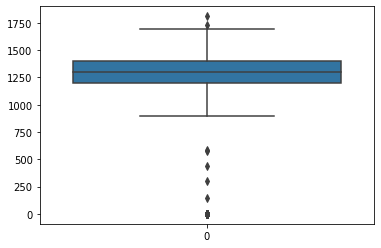

-------------------------------------------------------------------------------
rougher.state.floatbank10_c_level
< min, len: 78
528    -646.084690
530    -642.279355
531    -634.989081
532    -632.972180
536    -640.908120
           ...    
3084   -628.718044
3922   -644.111938
3923   -642.964278
3924   -627.866645
3929   -640.318473
Name: rougher.state.floatbank10_c_level, Length: 78, dtype: float64
> max, len: 75
1091   -299.387448
1092   -301.320539
1093   -300.103863
1094   -299.994594
1095   -300.814024
           ...    
4669   -300.598698
4670   -300.231548
4671   -299.370371
4672   -301.020300
4673   -300.574963
Name: rougher.state.floatbank10_c_level, Length: 75, dtype: float64


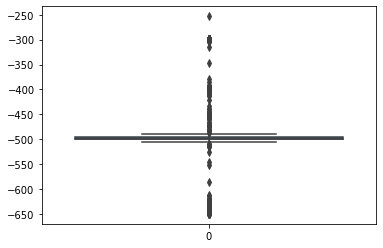

-------------------------------------------------------------------------------
rougher.state.floatbank10_d_air
< min, len: 91
528      -0.614256
530      -0.657395
531      -0.678964
532      -0.700534
536      -0.790982
           ...    
3080     -0.448718
3081     -0.495239
3082     -0.541760
3083     -0.588281
3084    106.103188
Name: rougher.state.floatbank10_d_air, Length: 91, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_d_air, dtype: float64)


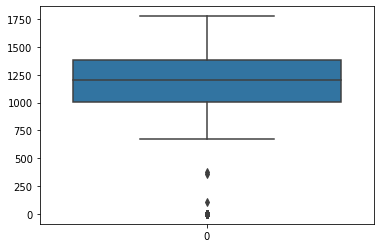

-------------------------------------------------------------------------------
rougher.state.floatbank10_d_level
< min, len: 8
184    -648.390665
185    -644.224677
311    -633.427549
312    -635.154250
544    -633.288454
2476   -640.118445
2477   -648.118446
2478   -646.787694
Name: rougher.state.floatbank10_d_level, dtype: float64
> max, len: 76
1091   -302.250987
1092   -298.742276
1093   -300.503459
1094   -298.678824
1095   -296.619013
           ...    
4669   -300.052592
4670   -299.929591
4671   -299.598589
4672   -299.819806
4673   -301.630598
Name: rougher.state.floatbank10_d_level, Length: 76, dtype: float64


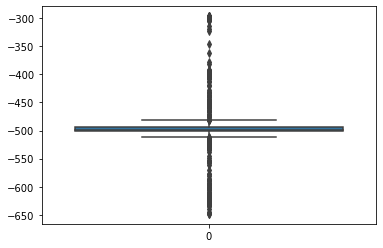

-------------------------------------------------------------------------------
rougher.state.floatbank10_e_air
< min, len: 91
528     -1.974584
530     -1.976100
531     -1.976858
532     -1.977616
536     -1.975464
          ...    
3080    -1.851382
3081    -1.855525
3082    -1.859667
3083    -1.863810
3084    93.352218
Name: rougher.state.floatbank10_e_air, Length: 91, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_e_air, dtype: float64)


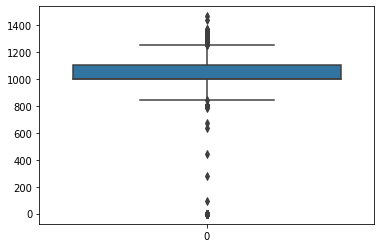

-------------------------------------------------------------------------------
rougher.state.floatbank10_e_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_e_level, dtype: float64)
> max, len: 0
Series([], Name: rougher.state.floatbank10_e_level, dtype: float64)


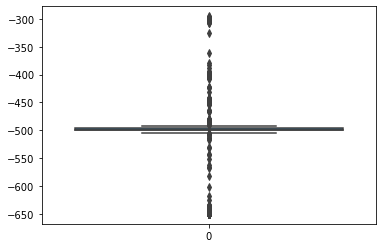

-------------------------------------------------------------------------------
rougher.state.floatbank10_f_air
< min, len: 91
528     -2.257716
530     -2.271922
531     -2.279024
532     -2.286127
536     -2.313642
          ...    
3080    -2.247606
3081    -2.294082
3082    -2.340558
3083    -2.387034
3084    41.802381
Name: rougher.state.floatbank10_f_air, Length: 91, dtype: float64
> max, len: 0
Series([], Name: rougher.state.floatbank10_f_air, dtype: float64)


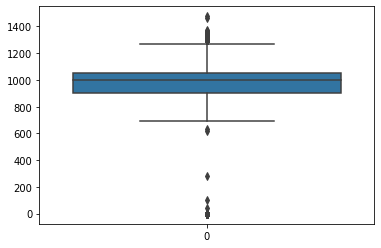

-------------------------------------------------------------------------------
rougher.state.floatbank10_f_level
< min, len: 0
Series([], Name: rougher.state.floatbank10_f_level, dtype: float64)
> max, len: 2
1291   -249.801043
1292   -254.174195
Name: rougher.state.floatbank10_f_level, dtype: float64


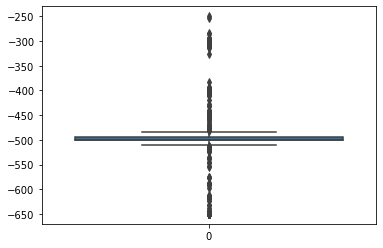

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_a_air
< min, len: 136
76       8.086810
532     11.762772
536      5.091613
537      4.870221
538      4.648829
          ...    
4249     5.488290
4250     5.636998
4546     6.540774
4547     3.177554
4550     2.066271
Name: secondary_cleaner.state.floatbank2_a_air, Length: 136, dtype: float64
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64)


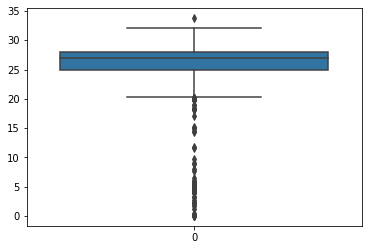

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_a_level
< min, len: 155
30     -725.426349
250    -677.933212
531    -799.492346
532    -799.489985
536    -799.480544
           ...    
4822   -772.231746
4823   -772.706047
4932   -698.135769
5740   -654.998994
5750   -681.171744
Name: secondary_cleaner.state.floatbank2_a_level, Length: 155, dtype: float64
> max, len: 1
2088   -300.34367
Name: secondary_cleaner.state.floatbank2_a_level, dtype: float64


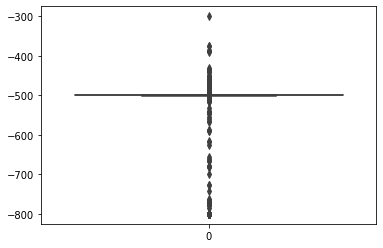

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_b_air
< min, len: 135
30      6.004391
532     4.629575
536     0.015738
537     0.011586
538     0.007435
          ...   
4249    4.972246
4250    4.990055
4546    3.956083
4547    0.008524
4550    0.759946
Name: secondary_cleaner.state.floatbank2_b_air, Length: 135, dtype: float64
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64)


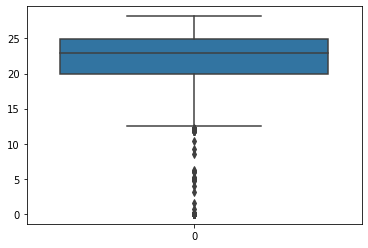

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank2_b_level
< min, len: 156
30     -788.919901
248    -709.801096
250    -790.544756
531    -788.790323
532    -789.494563
           ...    
4821   -784.175690
4822   -784.614062
4823   -784.874429
4824   -665.358879
5750   -715.982046
Name: secondary_cleaner.state.floatbank2_b_level, Length: 156, dtype: float64
> max, len: 27
1971   -327.934877
2019   -341.310988
2088   -211.999273
3386   -353.196061
3388   -353.115196
3389   -342.224720
3830   -349.608483
3869   -315.631360
3870   -298.599426
3871   -298.020941
3872   -325.264539
3873   -329.827859
3874   -271.984633
3875   -272.741591
3876   -285.406835
3877   -329.541763
3880   -349.136547
3881   -340.948511
3882   -323.837499
3883   -314.319523
3936   -281.121009
3937   -285.801365
3962   -302.452174
3965   -267.113953
3966   -336.672665
3999   -354.051556
4615   -310.803307
Name: secondary_cleaner.state.floatbank2_b_lev

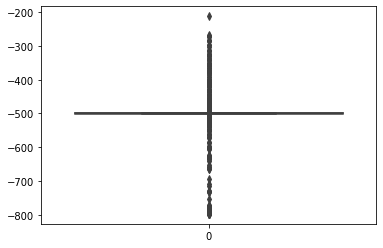

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_a_air
< min, len: 225
30      0.000000e+00
536     1.668920e-06
537     1.220452e-06
538     7.719847e-07
539     3.235172e-07
            ...     
3084    8.393336e-02
3922    0.000000e+00
3929    1.846023e+00
5503    2.855336e-02
5504    1.983003e-02
Name: secondary_cleaner.state.floatbank3_a_air, Length: 225, dtype: float64
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank3_a_air, dtype: float64)


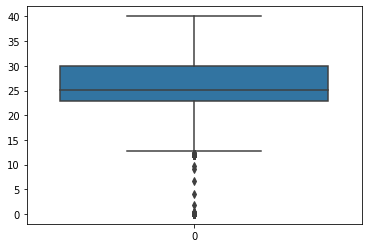

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_a_level
< min, len: 239
30     -796.177023
247    -797.092488
248    -799.430499
250    -799.448100
531    -799.177008
           ...    
3929   -702.673406
5201   -798.558166
5503   -799.086553
5504   -799.265787
5750   -796.906489
Name: secondary_cleaner.state.floatbank3_a_level, Length: 239, dtype: float64
> max, len: 1
3991   -313.866425
Name: secondary_cleaner.state.floatbank3_a_level, dtype: float64


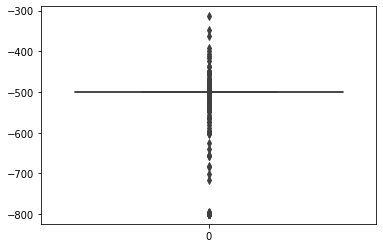

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_b_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64)
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64)


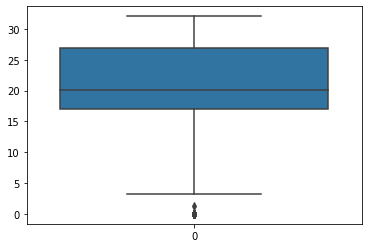

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank3_b_level
< min, len: 223
531    -715.952853
532    -717.015906
536    -717.320668
537    -717.057894
538    -718.275180
           ...    
5503   -809.049478
5504   -809.106914
5507   -703.295569
5750   -809.007398
5751   -666.340689
Name: secondary_cleaner.state.floatbank3_b_level, Length: 223, dtype: float64
> max, len: 14
42    -330.829233
76    -314.641194
114   -335.677127
115   -295.975226
116   -333.406479
117   -241.422430
118   -202.277366
119   -259.815170
120   -239.205903
121   -313.724835
256   -292.423757
257   -218.765454
364   -332.746416
400   -340.044463
Name: secondary_cleaner.state.floatbank3_b_level, dtype: float64


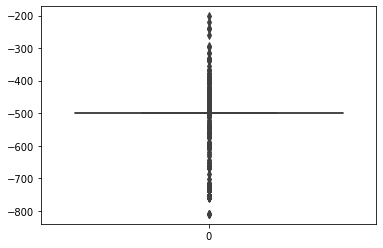

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_a_air
< min, len: 119
532     3.409854e+00
536     4.748971e-04
537     3.472841e-04
538     2.196710e-04
539     9.205798e-05
            ...     
5526    1.079872e-16
5527    1.079872e-16
5528    1.079872e-16
5529    1.079872e-16
5530    1.623572e+00
Name: secondary_cleaner.state.floatbank4_a_air, Length: 119, dtype: float64
> max, len: 2
5507    30.051797
5508    30.023506
Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64


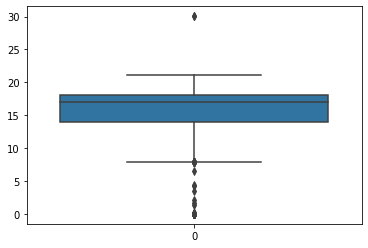

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_a_level
< min, len: 162
433    -662.385209
434    -799.637801
525    -701.131502
526    -703.487442
527    -703.466330
           ...    
5527   -798.067489
5528   -797.548944
5529   -797.030399
5530   -796.511854
5750   -796.602342
Name: secondary_cleaner.state.floatbank4_a_level, Length: 162, dtype: float64
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank4_a_level, dtype: float64)


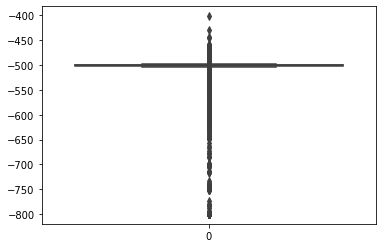

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_b_air
< min, len: 117
536     9.030118e-06
537     6.603570e-06
538     4.177021e-06
539     1.750473e-06
540     5.946347e-08
            ...     
5526    2.489718e-17
5527    2.489718e-17
5528    2.489718e-17
5529    2.489718e-17
5530    1.497222e+00
Name: secondary_cleaner.state.floatbank4_b_air, Length: 117, dtype: float64
> max, len: 1
5508    31.269706
Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64


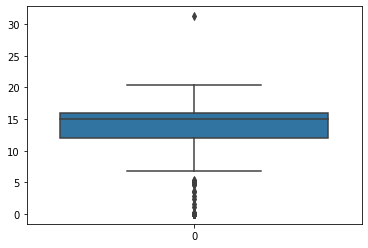

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank4_b_level
< min, len: 119
250    -763.757716
531    -799.639659
532    -799.659953
536    -799.741130
537    -799.761424
           ...    
5529   -798.645944
5530   -798.408777
5531   -772.381718
5750   -797.412056
5751   -792.847466
Name: secondary_cleaner.state.floatbank4_b_level, Length: 119, dtype: float64
> max, len: 173
3676   -176.603191
5203   -178.034034
5204   -152.135344
5205   -131.404406
5206   -136.270075
           ...    
5464   -150.862172
5465   -148.797368
5503    -29.652676
5504    -53.213101
5507    -77.907947
Name: secondary_cleaner.state.floatbank4_b_level, Length: 173, dtype: float64


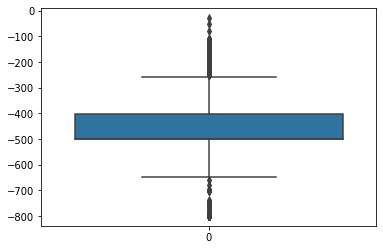

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_a_air
< min, len: 90
532     2.368603
536    -0.023750
537    -0.071061
538    -0.118373
539    -0.165684
          ...   
3080    0.513140
3081    0.518973
3082    0.524805
3083    0.530637
3084    1.719668
Name: secondary_cleaner.state.floatbank5_a_air, Length: 90, dtype: float64
> max, len: 1
1188    25.258848
Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64


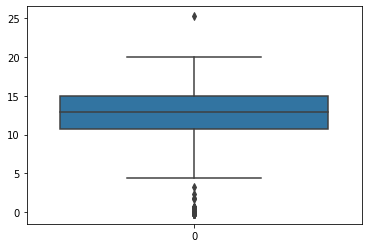

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_a_level
< min, len: 114
30     -795.337422
163    -641.467528
531    -794.982770
532    -795.206192
536    -797.286240
           ...    
3084   -795.736261
3922   -665.723439
3923   -705.378251
5750   -795.729203
5751   -639.785228
Name: secondary_cleaner.state.floatbank5_a_level, Length: 114, dtype: float64
> max, len: 12
255    -351.220868
427    -352.046176
528    -371.519101
660    -287.345405
1691   -321.047753
1692   -348.916844
3420   -377.726515
3537   -355.367743
3538   -347.112971
4393   -376.008041
4502   -327.355482
4893   -244.483566
Name: secondary_cleaner.state.floatbank5_a_level, dtype: float64


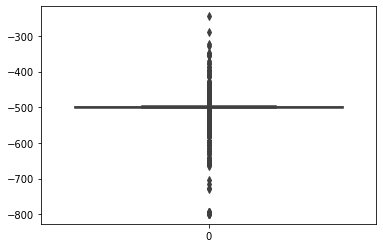

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_b_air
< min, len: 0
Series([], Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64)
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64)


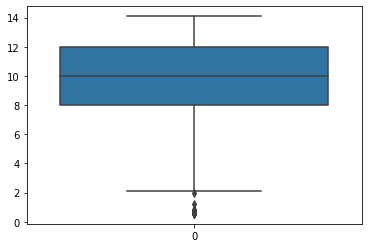

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank5_b_level
< min, len: 93
30     -800.024373
531    -799.984971
532    -799.990178
536    -800.011005
537    -800.016212
           ...    
3081   -800.043412
3082   -800.045907
3083   -800.048402
3084   -800.050896
5750   -800.036707
Name: secondary_cleaner.state.floatbank5_b_level, Length: 93, dtype: float64
> max, len: 86
255    -151.186554
330    -189.563378
371    -275.171720
426    -278.943896
427    -148.080088
           ...    
5227   -325.505177
5232   -280.476269
5233   -239.239057
5250   -254.782296
5492   -185.083868
Name: secondary_cleaner.state.floatbank5_b_level, Length: 86, dtype: float64


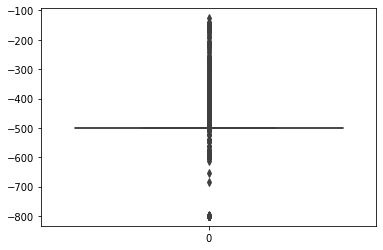

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank6_a_air
< min, len: 94
536     0.250619
537     0.231189
538     0.211760
539     0.192331
540     0.181569
          ...   
3081    0.302529
3082    0.306211
3083    0.309893
3084    0.496203
3922    0.366543
Name: secondary_cleaner.state.floatbank6_a_air, Length: 94, dtype: float64
> max, len: 0
Series([], Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64)


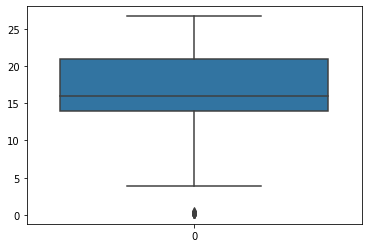

-------------------------------------------------------------------------------
secondary_cleaner.state.floatbank6_a_level
< min, len: 137
30     -799.501783
247    -734.132064
248    -749.453971
250    -799.103851
531    -799.830742
           ...    
3927   -719.626579
3929   -759.155694
5750   -804.516517
5751   -804.397881
5752   -694.144653
Name: secondary_cleaner.state.floatbank6_a_level, Length: 137, dtype: float64
> max, len: 45
1040   -283.034656
1041   -199.047356
1042   -203.582624
1043   -206.437595
1044   -202.095303
1045   -203.732629
1046   -202.241979
1047   -205.301719
1169   -302.647747
1170   -194.978411
1171   -199.123200
1177   -320.085062
1216   -283.781735
1217   -283.522350
1219   -315.928632
1220   -283.514459
1221   -250.505522
1222   -235.952246
1223   -212.922095
1224   -214.840130
1225   -204.694459
1226   -183.202019
1227   -199.815407
1228   -205.407749
1229   -289.276603
1230   -204.686520
1231   -229.677846
1272   -339.291217
1362   -271.038585
1459   -

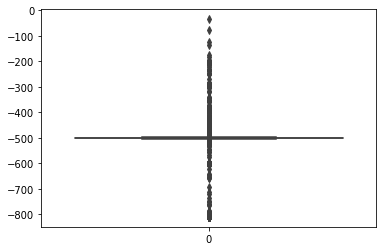

-------------------------------------------------------------------------------


In [151]:
#Outlier visualization and search function
vr = data_test_1.drop(['date'],axis=1)#I select the columns necessary for analysis
for i in vr.columns:
    meen = float(data_test_1[i].mean())#Column mean from loop
    maxx = meen + float(data_test_1[i].std())*3#maximum threshold
    minn = meen - float(data_test_1[i].std())*3#minimum threshold
    print(i)#Displaying information about the column in question
    print('< min, len:', len(data_test_1.loc[data_test_1[i]<minn][i]))#Displaying information about the column in question
    print(data_test_1.loc[data_test_1[i]<minn][i])#String output
    print('> max, len:', len(data_test_1.loc[data_test_1[i]>maxx][i]))#Displaying information about the column in question
    print(data_test_1.loc[data_test_1[i]>maxx][i])#String output
    ax = sns.boxplot(data=data_test_1[i])#Building a boxplot 
    plt.show()
    print('-------------------------------------------------------------------------------')#end of column information

rougher.input.feed_size is the only column of the two datasets that is suspicious of outliers. But again, the limiting numbers in it are distributed and do not have sharp jumps, well, that is, I personally do not understand what a granule size of 500 is, is it possible or not. No more clear outliers were found.

It remains to scale the features, but before I do that, I will count the target variables and save them in separate tables.

In [152]:
#I create a new column in which I do the calculation of enrichment efficiency
data_train_1['rougher.output.recovery_rashetniy'] = ((data_train_1['rougher.output.concentrate_au']*
                                     (data_train_1['rougher.input.feed_au']-data_train_1['rougher.output.tail_au']))/
                                    (data_train_1['rougher.input.feed_au']*(data_train_1['rougher.output.concentrate_au']
                                                                          -data_train_1['rougher.output.tail_au'])))*100
data_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16131 entries, 0 to 16859
Data columns (total 82 columns):
date                                          16131 non-null datetime64[ns]
final.output.concentrate_ag                   16131 non-null float64
final.output.concentrate_pb                   16131 non-null float64
final.output.concentrate_sol                  16131 non-null float64
final.output.concentrate_au                   16131 non-null float64
final.output.tail_ag                          16131 non-null float64
final.output.tail_pb                          16131 non-null float64
final.output.tail_sol                         16131 non-null float64
final.output.tail_au                          16131 non-null float64
primary_cleaner.input.sulfate                 16131 non-null float64
primary_cleaner.input.depressant              16131 non-null float64
primary_cleaner.input.feed_size               16131 non-null float64
primary_cleaner.input.xanthate                16131 non-

As you can see from the general information about the dataset, there are gaps in the rougher.output.recovery_rashetniy column, let's take a closer look at them.

In [153]:
#I display columns at which rougher.output.recovery_rashetniy- in gaps
data_train_1.loc[data_train_1['rougher.output.recovery_rashetniy'].isnull()==True][['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']].head(10)

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
99,0.0,0.0,0.0
100,0.0,0.0,0.0
101,0.0,0.0,0.0
102,0.0,0.0,0.0
103,0.0,0.0,0.0
104,0.0,0.0,0.0
105,0.0,0.0,0.0
106,0.0,0.0,0.0
107,0.0,0.0,0.0
108,0.0,0.0,0.0


As you can see, these are zero values ​​of variables, it turns out an uncertainty of the form 0/0, which can be equal to any number, so we will find in the limit what this fraction will be equal to, sorting through different values.

In [154]:
#Here I introduce additional variables used to calculate the limit of the fraction when the variables go to zero.
after_float = pd.DataFrame([0.1, 0.01,0.001,0.00007, 0.00003, 0.000007, 0.0000005, 0.0000000005, 0.000000000005, 0.000000000006])
before_float = pd.DataFrame([0.1, 0.009,0.001,0.00008, 0.00002, 0.000006, 0.0000006, 0.0000000004, 0.000000000006, 0.000000000005])
tail = pd.DataFrame([0.1, 0.011,0.0011,0.00009, 0.00001, 0.000004, 0.0000007, 0.0000000006, 0.000000000007, 0.000000000007])
recovery = (after_float*(before_float-tail))/(before_float*(after_float-tail))
print(recovery)

          0
0       NaN
1  2.222222
2  1.000000
3  0.437500
4  0.750000
5  0.777778
6  0.416667
7  2.500000
8  0.416667
9  2.400000


It is difficult to answer unequivocally, so I use logic to replace gaps. It turns out that since the processing stage did not change the concentration of gold in any way, then the value of 0 will be the most optimal, so I will replace the gaps with 0.

In [155]:
data_train_1['rougher.output.recovery_rashetniy'] = data_train_1['rougher.output.recovery_rashetniy'].fillna(0)
#data_train_1.info()

Create a column with calculated recovery for the final values.

In [156]:
#I create a new column in which I do the calculation of enrichment efficiency
data_train_1['final.output.recovery_rashetniy'] = ((data_train_1['final.output.concentrate_au']*
                                     (data_train_1['rougher.input.feed_au']-data_train_1['final.output.tail_au']))/
                                    (data_train_1['rougher.input.feed_au']*(data_train_1['final.output.concentrate_au']
                                                                          -data_train_1['final.output.tail_au'])))*100
#data_train_1.info()

In [157]:
#I display columns at which rougher.output.recovery_rashetniy- in gaps
data_train_1.loc[data_train_1['final.output.recovery_rashetniy'].isnull()==True][['final.output.concentrate_au', 'rougher.input.feed_au', 'final.output.tail_au']].head(10)

,final.output.concentrate_au,rougher.input.feed_au,final.output.tail_au
99,0.0,0.0,0.0
100,0.0,0.0,0.0
101,0.0,0.0,0.0
102,0.0,0.0,0.0
103,0.0,0.0,0.0
104,0.0,0.0,0.0
105,0.0,0.0,0.0
106,0.0,0.0,0.0
107,0.0,0.0,0.0
108,0.0,0.0,0.0


In [158]:
data_train_1['final.output.recovery_rashetniy'] = data_train_1['final.output.recovery_rashetniy'].fillna(0)
#data_train_1.info()

I will calculate the target parameters on the test sample.

In [159]:
feat_data_test = data_full.loc[data_full['date'].isin(data_test_1['date'])]
feat_data_test.info()#I look at the full table, coinciding in dates with the test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5607 entries, 5521 to 17208
Data columns (total 87 columns):
date                                                  5607 non-null datetime64[ns]
final.output.concentrate_ag                           5605 non-null float64
final.output.concentrate_pb                           5607 non-null float64
final.output.concentrate_sol                          5607 non-null float64
final.output.concentrate_au                           5607 non-null float64
final.output.recovery                                 5356 non-null float64
final.output.tail_ag                                  5605 non-null float64
final.output.tail_pb                                  5605 non-null float64
final.output.tail_sol                                 5561 non-null float64
final.output.tail_au                                  5607 non-null float64
primary_cleaner.input.sulfate                         5455 non-null float64
primary_cleaner.input.depressant              

As you can see, the rougher.output.tail_au- column has gaps, so I'll fill them in.

In [160]:
#Checking for null values
feat_data_test.loc[(feat_data_test['final.output.tail_au'] == 0) & (feat_data_test['rougher.output.tail_au'].isnull() == True)]#

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5767,2016-09-11 06:59:59,0.794213,1.172955,0.859285,4.873203,NaN,0.0,0.0,0.0,0.0,...,8.073119e+00,-501.810437,4.956902e+00,-499.412118,8.153360,-492.626261,3.081493,-476.885347,20.035238,-603.205354
5768,2016-09-11 07:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,8.022703e+00,-520.809679,4.954530e+00,-569.697771,7.900118,-513.604732,2.960581,-499.693953,19.998444,-734.132064
5769,2016-09-11 08:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,7.907092e+00,-509.244830,4.972887e+00,-580.824925,8.079996,-519.416398,2.948391,-499.492902,19.993156,-749.453971
5771,2016-09-11 10:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,7.957470e+00,-519.591718,5.066487e+00,-763.757716,7.921217,-578.262534,2.986725,-499.829549,20.030452,-799.103851
5783,2016-09-11 22:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,7.933847e+00,-501.670848,5.013327e+00,-499.986624,8.079205,-505.721069,2.873240,-500.875736,19.979899,-500.914508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15907,2017-11-07 18:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,2.108926e+01,-500.105725,1.893456e+01,-500.267698,15.011111,-500.357752,10.981647,-499.999423,16.007053,-499.527013
16732,2017-12-12 03:59:59,1.227173,6.919788,4.853086,36.726331,100.0,0.0,0.0,0.0,0.0,...,1.995278e+01,-498.732347,1.510819e+01,-495.229555,10.992123,-499.438136,7.954472,-499.987793,11.994510,-502.344999
16832,2017-12-16 07:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,7.120789e-03,-799.652459,8.048799e-03,-799.844736,11.012887,-494.532463,8.005725,-499.407419,11.993407,-493.466890
16845,2017-12-16 20:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,...,7.349942e-17,-799.661372,8.306354e-17,-799.847006,11.048118,-451.369552,8.185258,-185.083868,12.019801,-300.135527


I replace these gaps with 0.

In [161]:
index = feat_data_test.loc[(feat_data_test['final.output.tail_au'] == 0) & (feat_data_test['rougher.output.tail_au'].isnull() == True)].index
for i in index:
    feat_data_test.loc[i,['rougher.output.tail_au']] = 0
#feat_data_test.info()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Part was replaced by 0, the rest of the gaps will be replaced using a linear regression model.

In [162]:
#I share the sample
data_train_nan = feat_data_test[['rougher.output.tail_au', 'final.output.tail_au', 'primary_cleaner.output.tail_au','secondary_cleaner.output.tail_au']].dropna()
df_train, df_valid = train_test_split(data_train_nan, test_size=0.25, random_state = 1234)
features_train = df_train.drop(['rougher.output.tail_au'], axis=1)
target_train = df_train['rougher.output.tail_au']
features_test = df_valid.drop(['rougher.output.tail_au'], axis=1)
target_test = df_valid['rougher.output.tail_au']

In [163]:
#Train the model and record the model's predictions in a table
mod_nan_1 = LinearRegression().fit(features_train, target_train)
pr = mod_nan_1.predict(features_test)
predskaz = pd.DataFrame(pr, columns=['predskaz'])#I write the values calculated by the model
#This is followed by a procedure for replacing negative values, since the model itself can give this, but in reality 
# remainders cannot be negative!
index = predskaz.loc[predskaz['predskaz']<0].index
predskaz.loc[index,:] = 0


In [164]:
print('The MAE of the gap replacement model in the secondary_cleaner.output.tail_sol column is',mean_absolute_error(predskaz,target_test))

МАЕ модели замены пропусков в столбце secondary_cleaner.output.tail_sol равно 0.3451150591912017


In [165]:
print('The MAE of replacing gaps with the average value in the column secondary_cleaner.output.tail_sol is',abs(target_test - target_test.mean()).mean())

МАЕ замены пропусков средним значением в столбце secondary_cleaner.output.tail_sol равно 0.46852706500855135


I replace gaps with model predictions.

In [166]:
#I allocate indices corresponding to the necessary replacement according to the created model
index = feat_data_test.loc[(feat_data_test['rougher.output.tail_au'].isnull() == True)&(feat_data_test['final.output.tail_au'].isnull()==False)&(feat_data_test['primary_cleaner.output.tail_au'].isnull()==False)&(feat_data_test['secondary_cleaner.output.tail_au'].isnull()==False)].index
ddd = feat_data_test.loc[:,['final.output.tail_au', 'primary_cleaner.output.tail_au','secondary_cleaner.output.tail_au']]#Выделяю датасет из которого буду брать замену 
for i in index:
    zam = mod_nan_1.predict(ddd.loc[ddd.index==i])#replacement value corresponding to the predictor string
    if zam < 0:
        zam = 0#zeroing out any negative results, since there are either leftovers or they are not
    feat_data_test.loc[i,['rougher.output.tail_au']] = zam#I make a replacement

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [167]:
#I create a new column in which I do the calculation of enrichment efficiency
feat_data_test['rougher.output.recovery_rashetniy'] = ((feat_data_test['rougher.output.concentrate_au']*
                                     (feat_data_test['rougher.input.feed_au']-feat_data_test['rougher.output.tail_au']))/
                                    (feat_data_test['rougher.input.feed_au']*(feat_data_test['rougher.output.concentrate_au']
                                                                          -feat_data_test['rougher.output.tail_au'])))*100
#feat_data_test.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [168]:
feat_data_test['rougher.output.recovery_rashetniy'] = feat_data_test['rougher.output.recovery_rashetniy'].fillna(0)
#feat_data_test.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [169]:
#I create a new column in which I do the calculation of enrichment efficiency
feat_data_test['final.output.recovery_rashetniy'] = ((feat_data_test['final.output.concentrate_au']*
                                     (feat_data_test['rougher.input.feed_au']-feat_data_test['final.output.tail_au']))/
                                    (feat_data_test['rougher.input.feed_au']*(feat_data_test['final.output.concentrate_au']
                                                                          -feat_data_test['final.output.tail_au'])))*100
#feat_data_test.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [170]:
feat_data_test['final.output.recovery_rashetniy'] = feat_data_test['final.output.recovery_rashetniy'].fillna(0)
#feat_data_test.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The gaps have been processed, the required values ​​have been calculated, now I will create separate datasets for training, testing, and then I will scale the features.

In [171]:
#I create datasets for training and testing
features_train = data_train_1.drop(['date', 'rougher.output.recovery_rashetniy', 'final.output.recovery_rashetniy', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au'], axis=1)
target_train = pd.DataFrame(data_train_1[['rougher.output.recovery_rashetniy', 'final.output.recovery_rashetniy']])
features_test = data_test_1.drop(['date'], axis=1).reset_index(drop=True)
target_test = (feat_data_test[['rougher.output.recovery_rashetniy', 'final.output.recovery_rashetniy']]).reset_index(drop=True)

In [172]:
# Here I call the standard scalar for feature scaling, then turn the scaled numpy arrays into workable dataframes.
scaler = StandardScaler()
scaler.fit(features_train)
cl = features_train.columns
features_train_1 = scaler.transform(features_train)
features_train_1 = pd.DataFrame(features_train_1, columns = cl)
cl = features_test.columns
features_test_1 = scaler.transform(features_test)
features_test_1 = pd.DataFrame(features_test_1, columns = cl)

The data was pre-processed, namely: the gaps were removed / replaced by the method of the nearest value in time, using a linear regression model or by replacing the average, in different places I acted according to the situation and at my own discretion. A search for anomalous values was carried out, but I did not find any obvious outliers, and in order to do this, it is necessary to consult with a specialist in this field. The columns were scaled, except for the target ones, since we will build quality metrics on it, and in general there are 2 of these features, they have the same limits among themselves, in my opinion, scaling the target feature will not increase the quality of the model. So we have datasets for analysis and datasets for building a model. The datasets for analysis include all rows, columns with uncorrelated features were selected for the model, as was given in the task. data_train_1 - dataset for analysis, features_train - dataset for the model, the rest follow the same principle.

# 2. Data analysis

I visualize the distribution of concentrations of various metals.

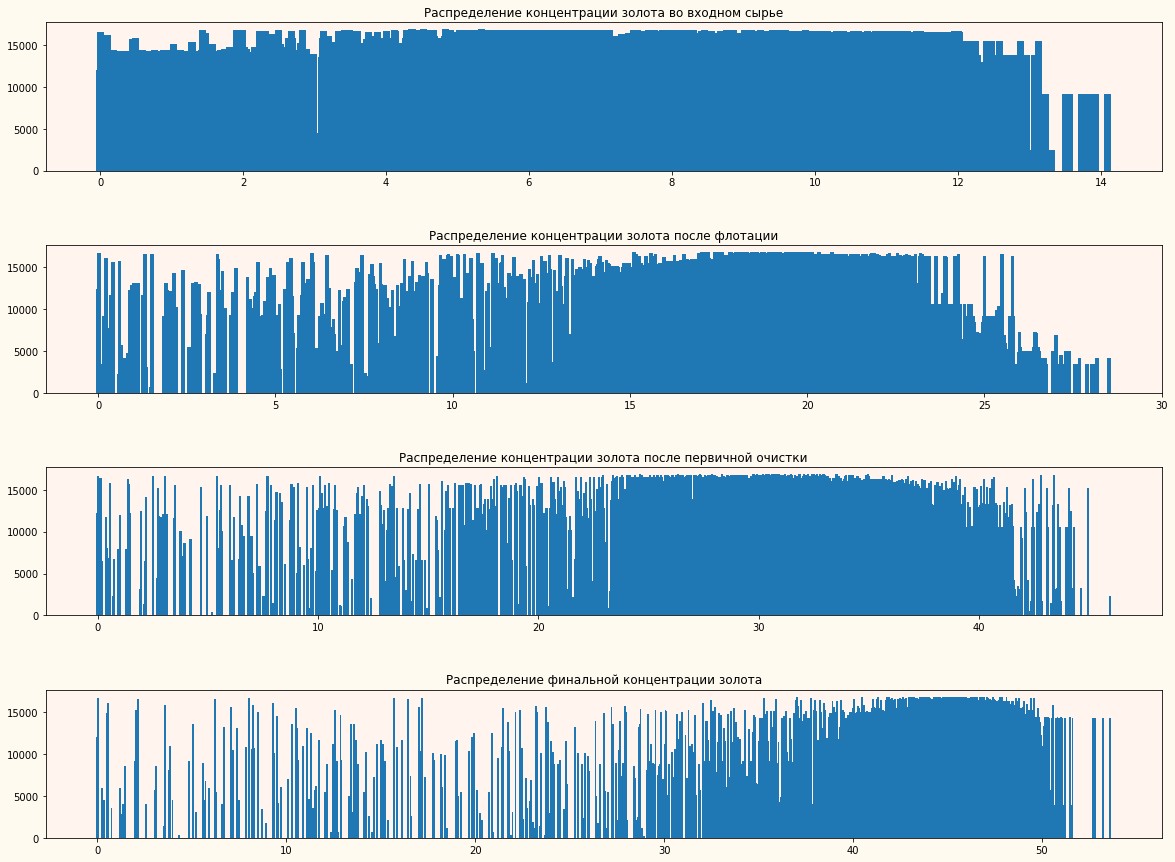

In [173]:
fig, axes = plt.subplots(4,1)#I set the number of areas for plotting
#I set a data set and line width for each plot area
axes[0].bar(data_train_1['rougher.input.feed_au'], data_train_1.index, width = 0.1)
axes[1].bar(data_train_1['rougher.output.concentrate_au'], data_train_1.index, width = 0.1)
axes[2].bar(data_train_1['primary_cleaner.output.concentrate_au'], data_train_1.index, width = 0.1)
axes[3].bar(data_train_1['final.output.concentrate_au'], data_train_1.index, width = 0.1)
axes[0].set_title('Distribution of gold concentration in the input raw material')
axes[1].set_title('Distribution of gold concentration after flotation')
axes[2].set_title('Distribution of gold concentration after primary purification')
axes[3].set_title('Distribution of final gold concentration')
axes[0].set_facecolor('seashell')
axes[1].set_facecolor('seashell')
axes[2].set_facecolor('seashell')
axes[3].set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  figure width
fig.set_figheight(15)    #  figure height
plt.subplots_adjust(hspace=0.5)

plt.show()

On the graphs, we can observe the obvious fact: in each subsequent stage of processing, the concentration of gold increases.

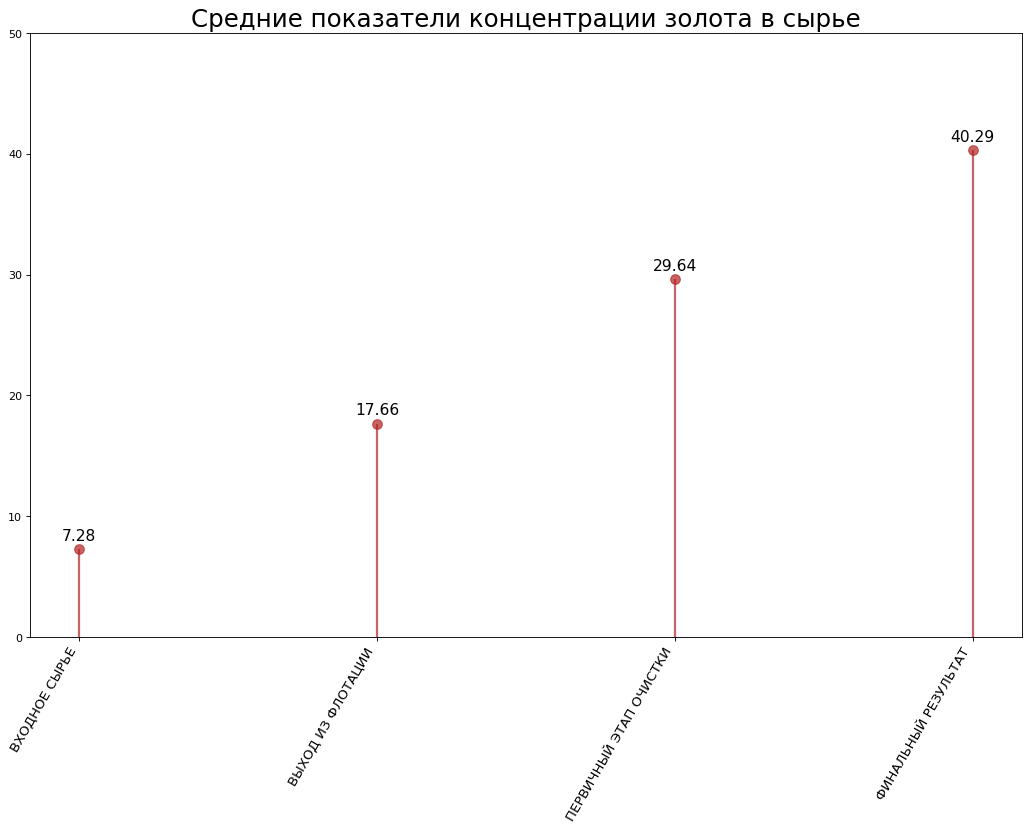

In [174]:
#I build a lolipop graph showing the average gold concentration at each stage
df = pd.DataFrame([[data_train_1['rougher.input.feed_au'].mean(), 'входное сырье'], [data_train_1['rougher.output.concentrate_au'].mean(), 'выход из флотации'], [data_train_1['primary_cleaner.output.concentrate_au'].mean(), 'первичный этап очистки'], [data_train_1['final.output.concentrate_au'].mean(), 'финальный результат']], columns=['a','b'])


fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.a, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=df.index, y=df.a, s=75, color='firebrick', alpha=0.7)

# I set the name of the graph and the limits of plotting
ax.set_title('Average concentrations of gold in raw materials', fontdict={'size':22})
ax.set_xticks(df.index)
ax.set_xticklabels(df.b.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 50)

# annotation
for row in df.itertuples():
    ax.text(row.Index, row.a+.5, s=round(row.a, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

Each stage increases the concentration of gold approximately equally, only the primary stage of purification makes the largest contribution to the purification.

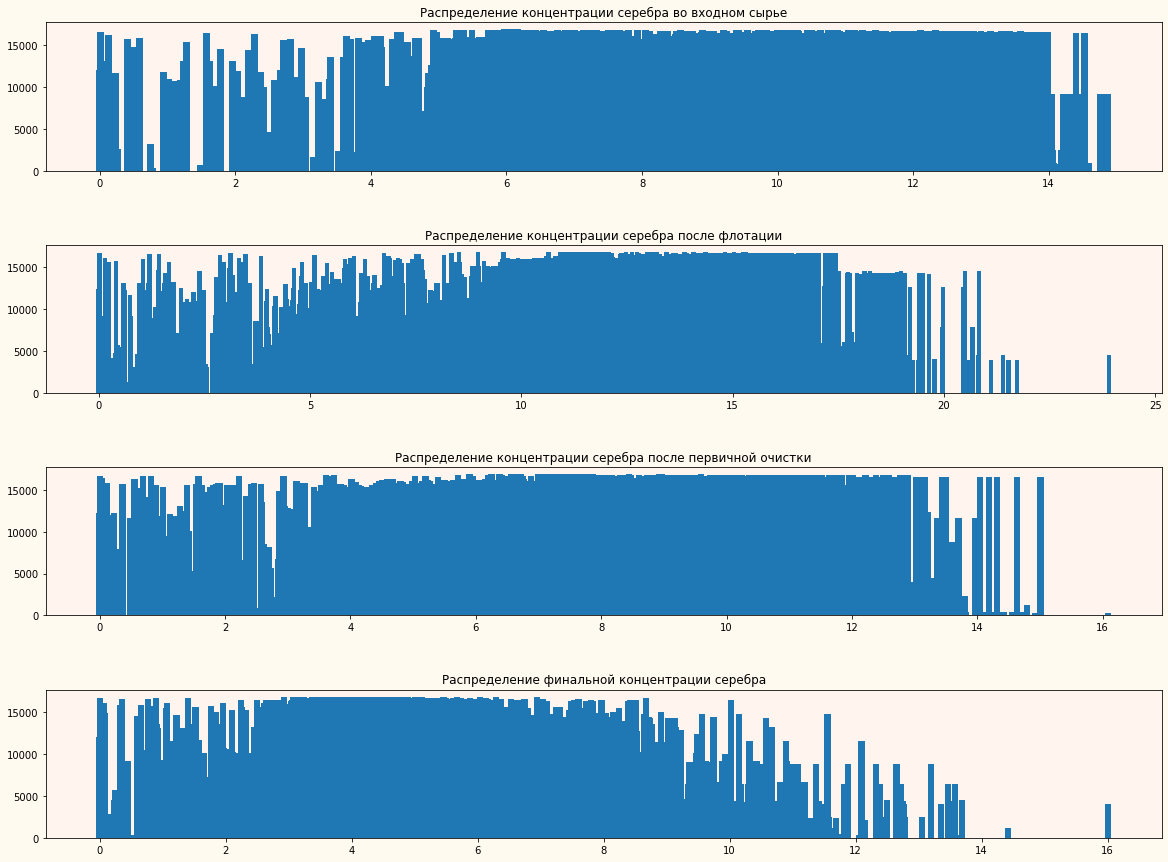

In [175]:
#I build the distribution of silver concentration at the stages of purification
fig, axes = plt.subplots(4,1)

axes[0].bar(data_train_1['rougher.input.feed_ag'], data_train_1.index, width = 0.1)
axes[1].bar(data_train_1['rougher.output.concentrate_ag'], data_train_1.index, width = 0.1)
axes[2].bar(data_train_1['primary_cleaner.output.concentrate_ag'], data_train_1.index, width = 0.1)
axes[3].bar(data_train_1['final.output.concentrate_ag'], data_train_1.index, width = 0.1)
axes[0].set_title('Distribution of silver concentration in the input raw material')
axes[1].set_title('Silver concentration distribution after flotation')
axes[2].set_title('Distribution of silver concentration after primary purification')
axes[3].set_title('Distribution of final silver concentration')
axes[0].set_facecolor('seashell')
axes[1].set_facecolor('seashell')
axes[2].set_facecolor('seashell')
axes[3].set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  figure width
fig.set_figheight(15)    #  figure height
plt.subplots_adjust(hspace=0.5)

plt.show()

But the distribution of silver concentration by purification stages does not look like that of gold. After flotation, the concentration of silver increases, and in the remaining stages it gradually decreases.

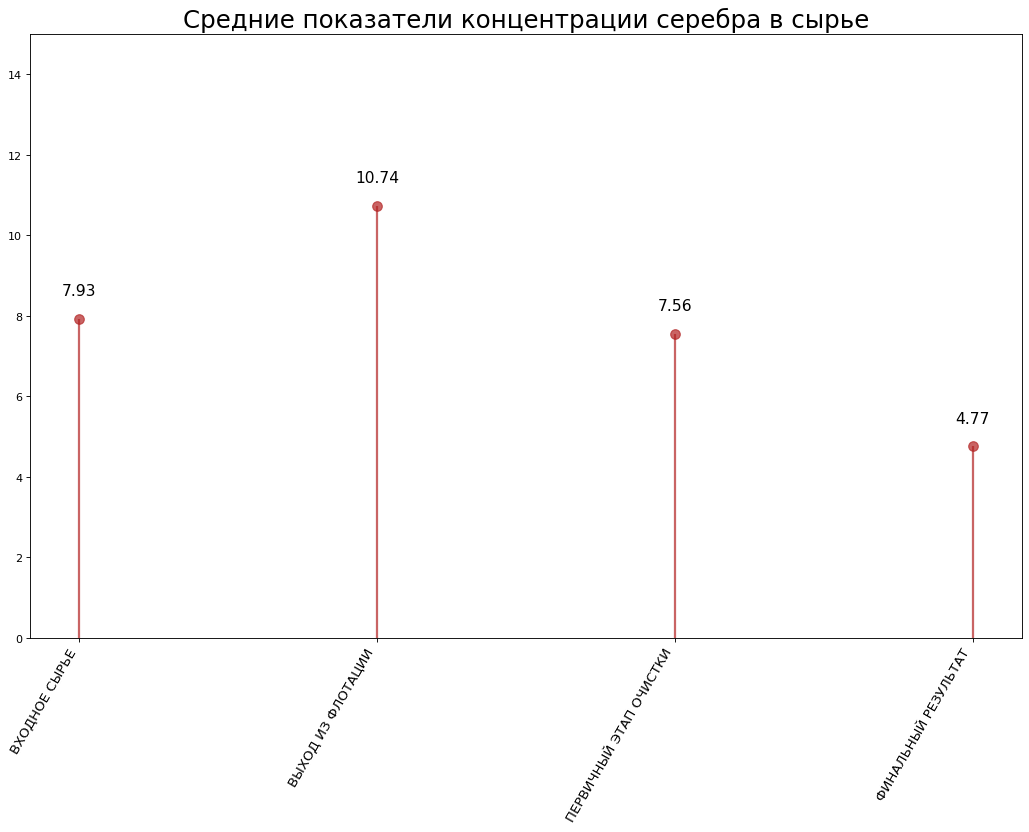

In [176]:
#Lolipop medium concentration of silver on the stages
df = pd.DataFrame([[data_train_1['rougher.input.feed_ag'].mean(), 'входное сырье'], [data_train_1['rougher.output.concentrate_ag'].mean(), 'выход из флотации'], [data_train_1['primary_cleaner.output.concentrate_ag'].mean(), 'первичный этап очистки'], [data_train_1['final.output.concentrate_ag'].mean(), 'финальный результат']], columns=['a','b'])


fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.a, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=df.index, y=df.a, s=75, color='firebrick', alpha=0.7)


ax.set_title('Average concentrations of silver in raw materials', fontdict={'size':22})
ax.set_xticks(df.index)
ax.set_xticklabels(df.b.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 15)


for row in df.itertuples():
    ax.text(row.Index, row.a+.5, s=round(row.a, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

Averages are more visible.

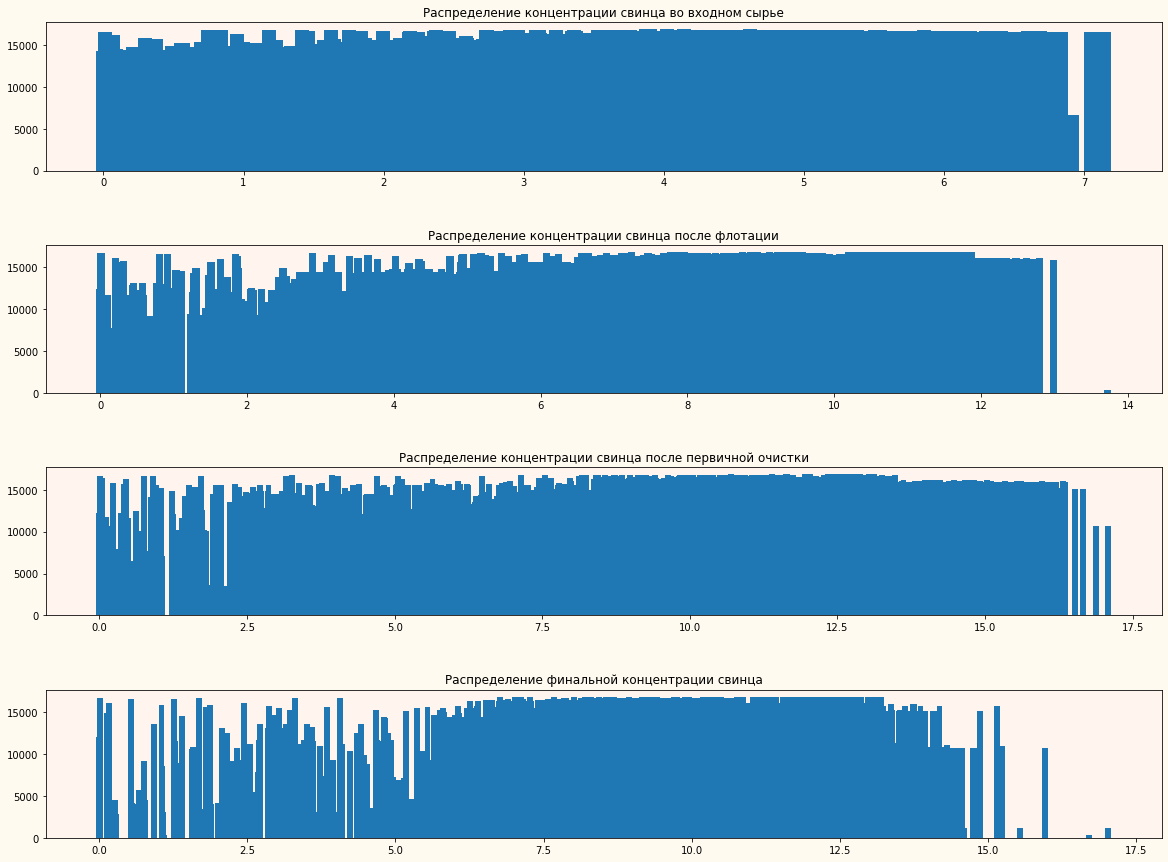

In [177]:
#I build the same distributions for lead
fig, axes = plt.subplots(4,1)

axes[0].bar(data_train_1['rougher.input.feed_pb'], data_train_1.index, width = 0.1)
axes[1].bar(data_train_1['rougher.output.concentrate_pb'], data_train_1.index, width = 0.1)
axes[2].bar(data_train_1['primary_cleaner.output.concentrate_pb'], data_train_1.index, width = 0.1)
axes[3].bar(data_train_1['final.output.concentrate_pb'], data_train_1.index, width = 0.1)
axes[0].set_title('Распределение концентрации свинца во входном сырье')
axes[1].set_title('Распределение концентрации свинца после флотации')
axes[2].set_title('Распределение концентрации свинца после первичной очистки')
axes[3].set_title('Распределение финальной концентрации свинца')
axes[0].set_facecolor('seashell')
axes[1].set_facecolor('seashell')
axes[2].set_facecolor('seashell')
axes[3].set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  figure width
fig.set_figheight(15)    #  figure height
plt.subplots_adjust(hspace=0.5)

plt.show()

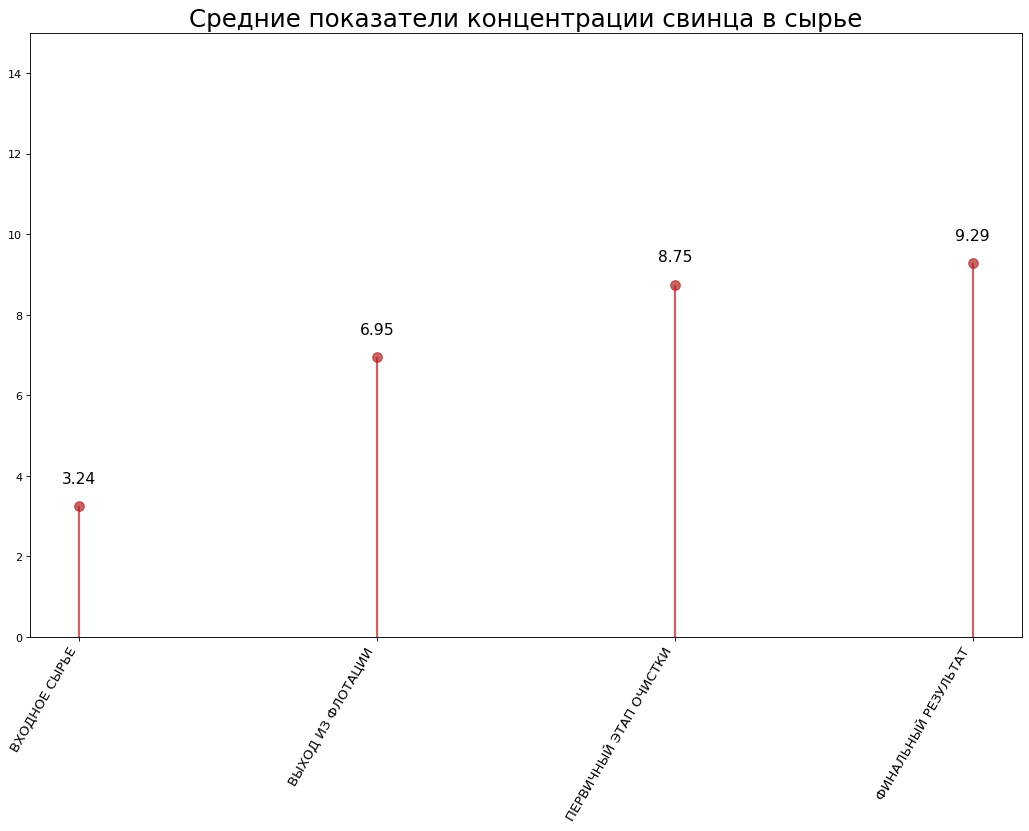

In [178]:
#Average values for lead at various stages
df = pd.DataFrame([[data_train_1['rougher.input.feed_pb'].mean(), 'входное сырье'], [data_train_1['rougher.output.concentrate_pb'].mean(), 'выход из флотации'], [data_train_1['primary_cleaner.output.concentrate_pb'].mean(), 'первичный этап очистки'], [data_train_1['final.output.concentrate_pb'].mean(), 'финальный результат']], columns=['a','b'])


fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.a, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=df.index, y=df.a, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Average concentrations of lead in raw materials', fontdict={'size':22})
ax.set_xticks(df.index)
ax.set_xticklabels(df.b.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 15)

# Annotate
for row in df.itertuples():
    ax.text(row.Index, row.a+.5, s=round(row.a, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

But lead in concentration is inversely proportional to gold - it grows with each stage, the only thing that is not much.

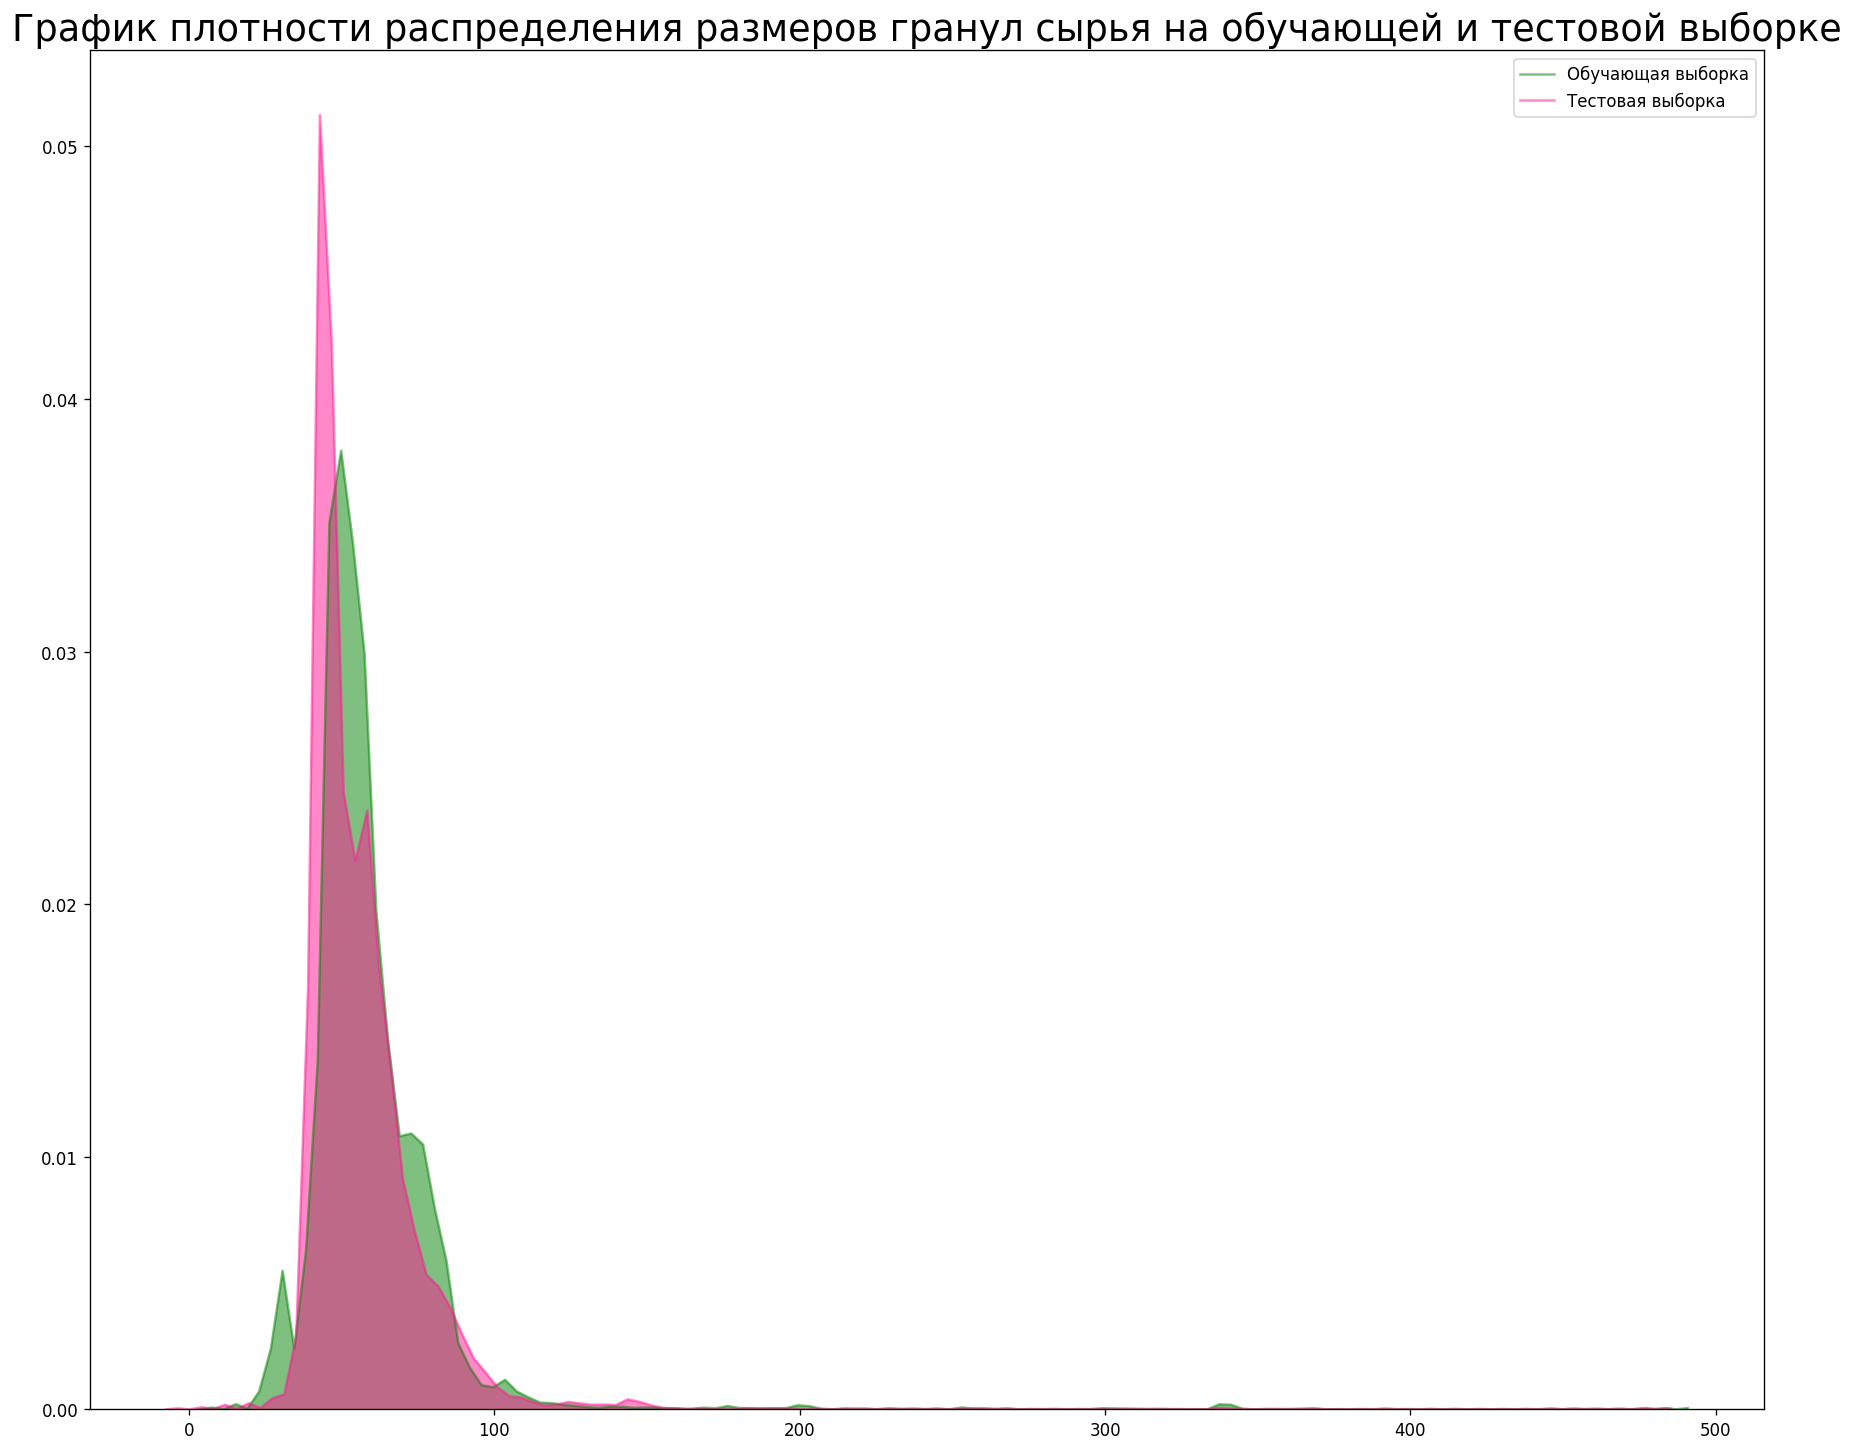

In [179]:
#I build a graph of the density distribution of the sizes of granules of raw materials

plt.figure(figsize=(18,15), dpi= 120)
sns.kdeplot(data_train_1["rougher.input.feed_size"], shade=True, color="g", label="Training set", alpha=.5)
sns.kdeplot(data_test_1["rougher.input.feed_size"], shade=True, color="deeppink", label="test sample", alpha=.5)


plt.title('Graph of the density distribution of the sizes of granules of raw materials on the training and test samples', fontsize=22)

plt.legend()
plt.show()

Judging by the graph, the distribution of granule sizes in both samples is approximately equal. In my opinion, there are no significant differences.

In [180]:
#For a stacked chart, I select a dataset with the necessary columns
df = pd.DataFrame([[data_train_1['rougher.input.feed_pb'].mean(), data_train_1['rougher.input.feed_ag'].mean(), 
                    data_train_1['rougher.input.feed_sol'].mean(), data_train_1['rougher.input.feed_au'].mean(),
                    'input raw material'], [data_train_1['rougher.output.concentrate_pb'].mean(), 
                                      data_train_1['rougher.output.concentrate_ag'].mean(), 
                                       data_train_1['rougher.output.concentrate_sol'].mean(), 
                                       data_train_1['rougher.output.concentrate_au'].mean(), 'exit from flotation'],
                   [data_train_1['primary_cleaner.output.concentrate_pb'].mean(), 
                    data_train_1['primary_cleaner.output.concentrate_ag'].mean(),
                    data_train_1['primary_cleaner.output.concentrate_sol'].mean(),
                    data_train_1['primary_cleaner.output.concentrate_au'].mean(),'primary cleaning step'], 
                   [data_train_1['final.output.concentrate_pb'].mean(), 
                    data_train_1['final.output.concentrate_ag'].mean(),
                    data_train_1['final.output.concentrate_sol'].mean(),
                    data_train_1['final.output.concentrate_au'].mean(),'final result']], columns=['pb','ag','sol','au','name'])

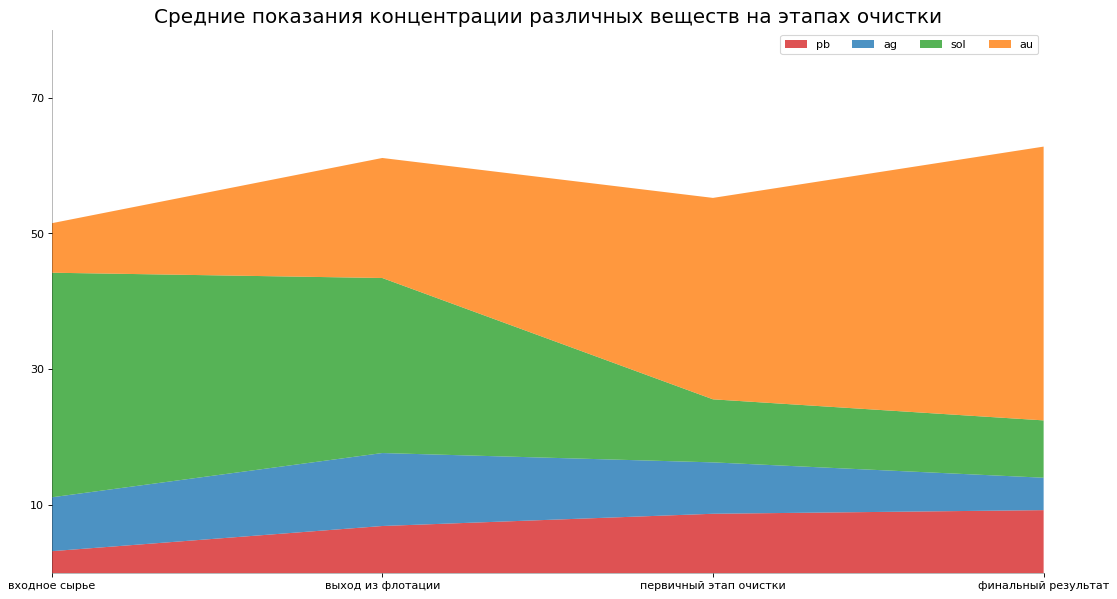

In [181]:
#I build a chart with accumulation by the total concentration of all substances in the raw material
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      

fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[:4]
labs = columns.values.tolist()

# Data preparation
x  = df['name'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])

# building columns
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Scenery
ax.set_title('Average readings of the concentration of various substances in the purification steps', fontsize=18)
ax.set(ylim=[0, 80])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 90, 20), fontsize=10)
plt.xlim(x[0], x[-1])

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

As you can see, the average indicators are approximately the same as they were previously on the distribution diagrams, according to this graph, we can conclude that the concentration of gold increases to a greater extent due to a decrease in the concentration of other impurities that do not fall under the main categories.

In [182]:
#I will build the same graph for the sums of concentrations
df = pd.DataFrame([[data_train_1['rougher.input.feed_pb'].sum(), data_train_1['rougher.input.feed_ag'].sum(), 
                    data_train_1['rougher.input.feed_sol'].sum(), data_train_1['rougher.input.feed_au'].sum(),
                    'input raw material'], [data_train_1['rougher.output.concentrate_pb'].sum(), 
                                      data_train_1['rougher.output.concentrate_ag'].sum(), 
                                       data_train_1['rougher.output.concentrate_sol'].sum(), 
                                       data_train_1['rougher.output.concentrate_au'].sum(), 'exit from flotation'],
                   [data_train_1['primary_cleaner.output.concentrate_pb'].sum(), 
                    data_train_1['primary_cleaner.output.concentrate_ag'].sum(),
                    data_train_1['primary_cleaner.output.concentrate_sol'].sum(),
                    data_train_1['primary_cleaner.output.concentrate_au'].sum(),'primary cleaning step'], 
                   [data_train_1['final.output.concentrate_pb'].sum(), 
                    data_train_1['final.output.concentrate_ag'].sum(),
                    data_train_1['final.output.concentrate_sol'].sum(),
                    data_train_1['final.output.concentrate_au'].sum(),'final result']], columns=['pb','ag','sol','au','name'])

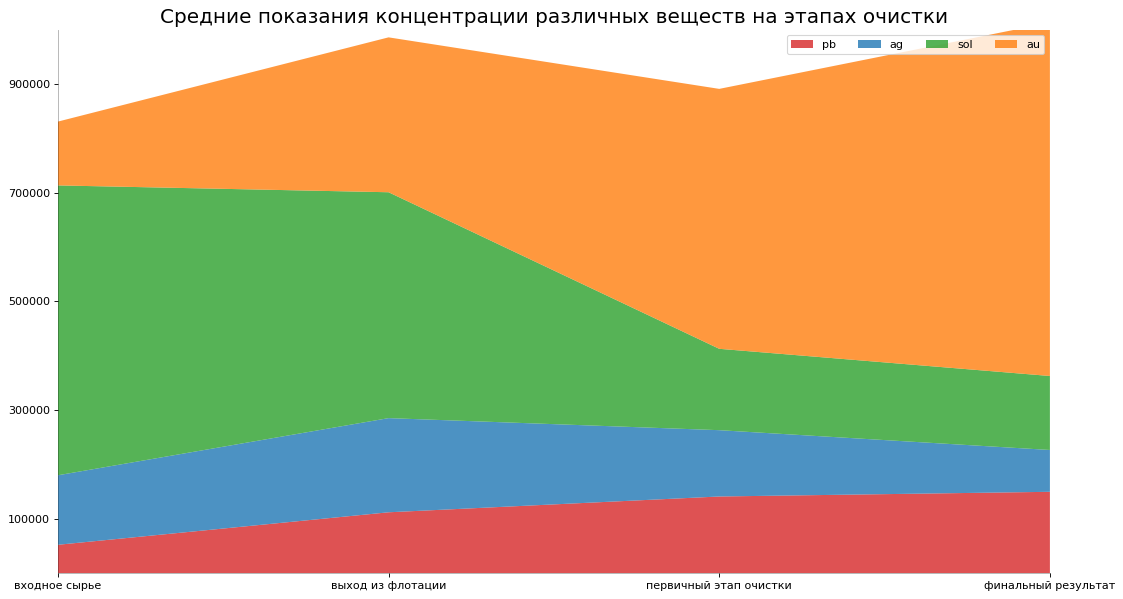

In [183]:
#Graph for concentration totals
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      

fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[:4]
labs = columns.values.tolist()

x  = df['name'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])

labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

ax.set_title('Average readings of the concentration of various substances in the purification steps', fontsize=18)
ax.set(ylim=[0, 1000000])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(100000, 1000000, 200000), fontsize=10)
plt.xlim(x[0], x[-1])

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

As you can see, the averages are also interpretable and the conclusions on this chart differ little from the previous ones.

In [184]:
#I create a dataset to build the total concentration distribution
df = pd.DataFrame(data_full.loc[:,['rougher.input.feed_pb', 'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.output.concentrate_pb',
                               'rougher.output.concentrate_ag', 'rougher.output.concentrate_sol',
                               'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_pb',
                               'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_sol',
                               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_pb',
                               'final.output.concentrate_ag', 'final.output.concentrate_sol',
                               'final.output.concentrate_au']])

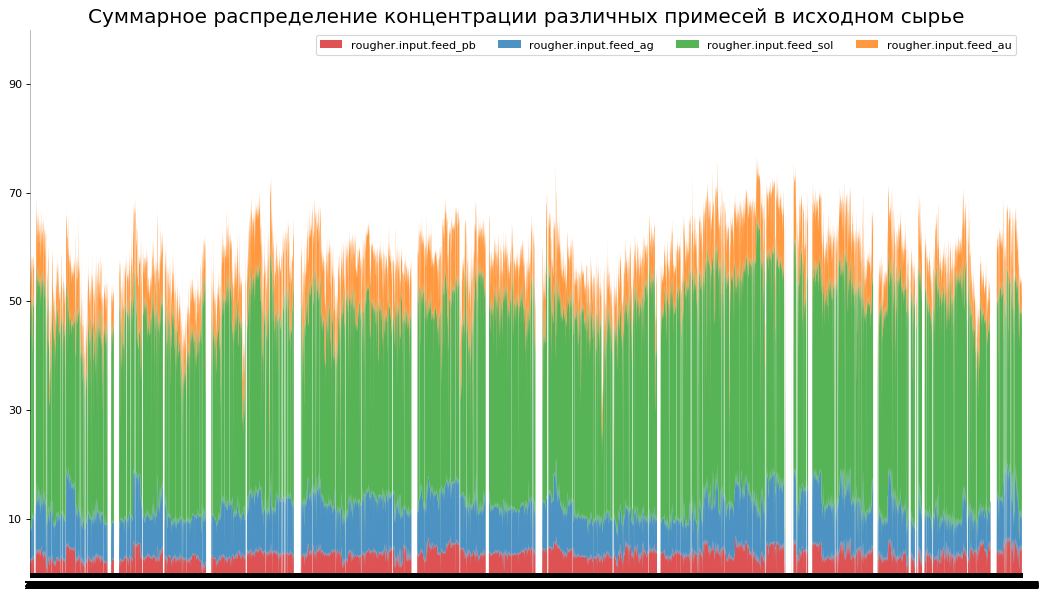

In [185]:
#Graph of the total concentration distribution
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[:4]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities in the feedstock', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

I do the same operations with the rest of the columns.

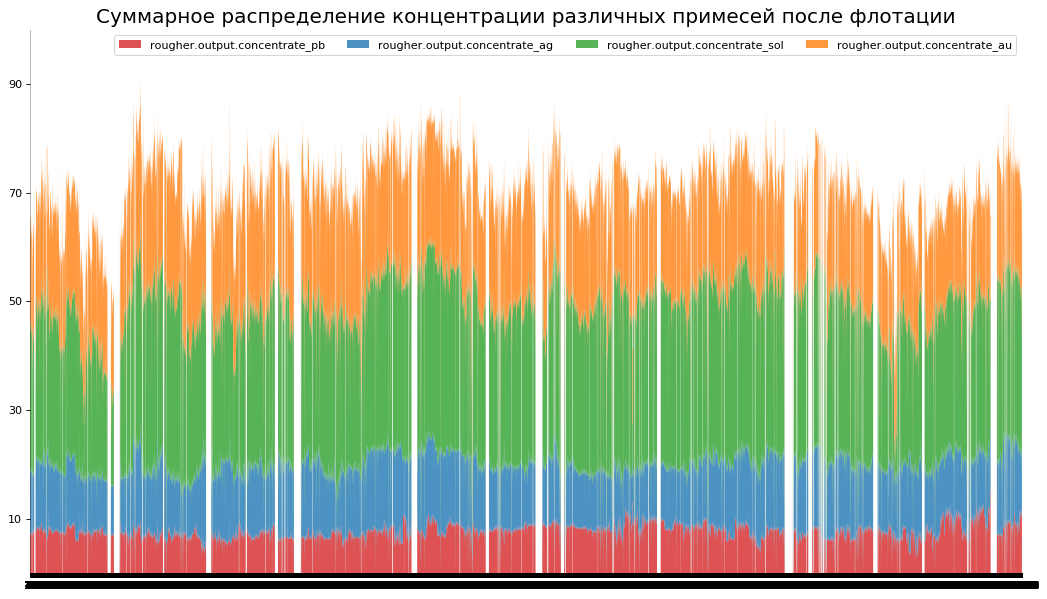

In [186]:

mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[4:8]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities after flotation', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

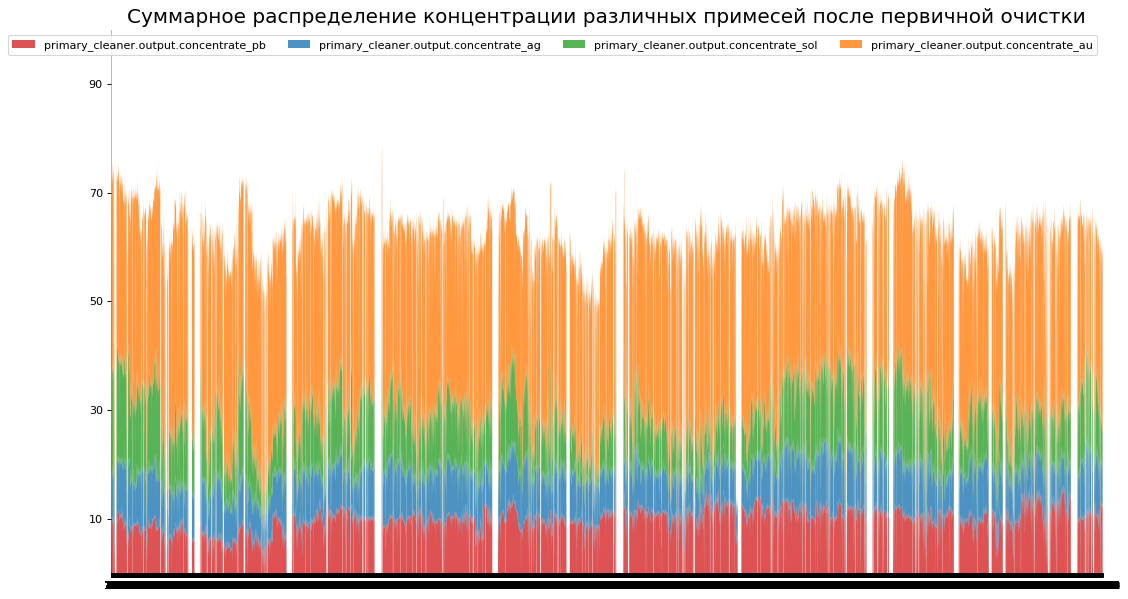

In [187]:
 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[8:12]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities after primary purification', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

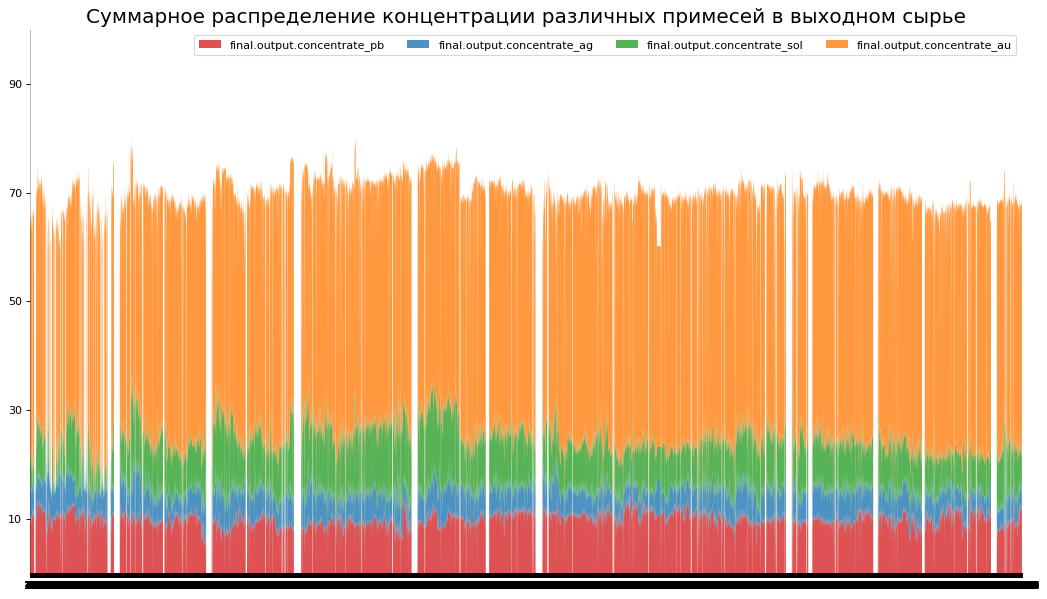

In [188]:
 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[12:16]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities in the output raw material', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

In my opinion, the work of the linear regression model will be strongly influenced by rows with zero values ​​for the concentration of all substances. Therefore, I will delete them on the training and test samples, and when creating a production model, it will be necessary to take into account that the model will not be able to work at zero concentrations, therefore, comparison operators with zero at the condition will need to be added to the model function, at zero concentrations in the input raw materials.

I will delete zero values in the samples for the model.

In [189]:
#I allocate indices at zero values of substances contained in raw materials
index = features_train.loc[(features_train['rougher.input.feed_pb']==0)&(features_train['rougher.input.feed_ag']==0)&
                          (features_train['rougher.input.feed_sol']==0)&(features_train['rougher.input.feed_au']==0)].index

In [190]:
#I delete lines
features_train = features_train.drop(index)
target_train = target_train.drop(index)

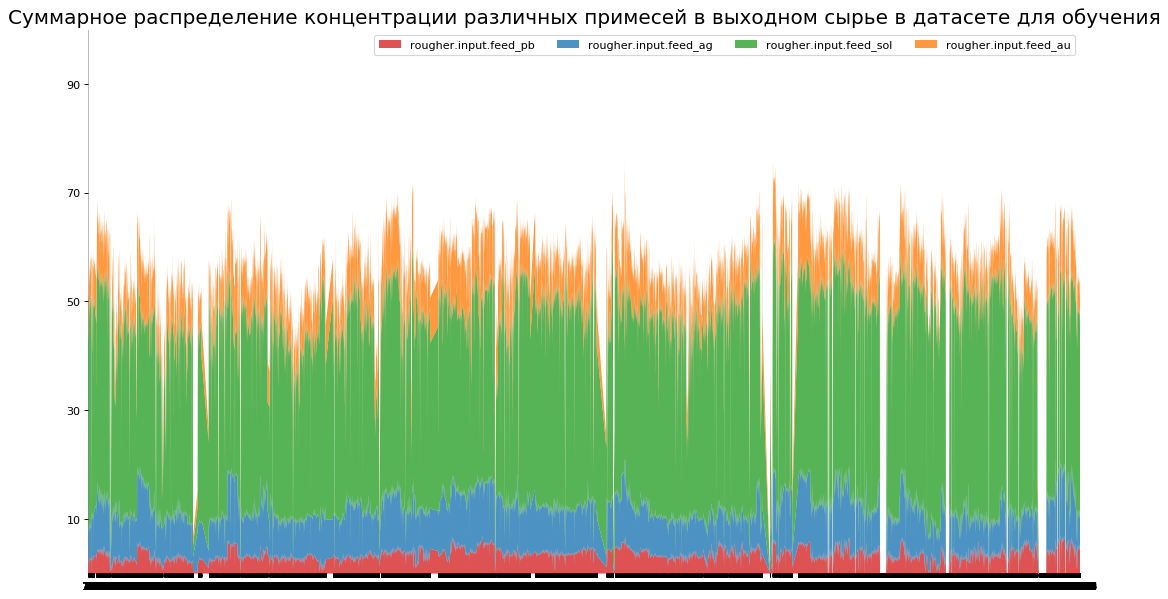

In [191]:
#I create a dataset for plotting a graph and build a graph
df = pd.DataFrame(features_train.loc[:,['rougher.input.feed_pb', 'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.feed_au']])
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[0:4]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities in the output raw material in the training dataset', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

Judging by the graph, there are still about zero values, which we also do not need, we will delete lines with a concentration of substances less than 0.3

In [192]:
#Allocate indexes
index = features_train.loc[(features_train['rougher.input.feed_pb']<0.3)&(features_train['rougher.input.feed_ag']<0.3)&
                          (features_train['rougher.input.feed_sol']<0.3)&(features_train['rougher.input.feed_au']<0.3)].index

In [193]:
#I delete
features_train = features_train.drop(index)
target_train = target_train.drop(index)

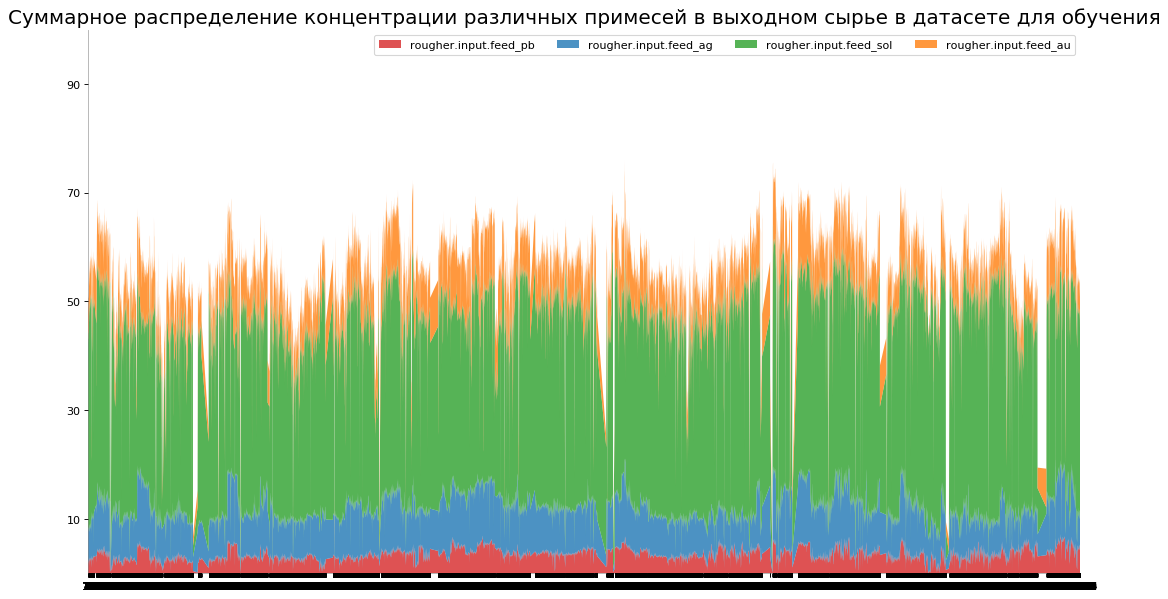

In [194]:
#I'm building a graph
df = pd.DataFrame(features_train.loc[:,['rougher.input.feed_pb', 'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.feed_au']])
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[0:4]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities in the output raw material in the training dataset', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

Already much better, I'm doing the same with the test sample.

In [195]:
index = features_test.loc[(features_test['rougher.input.feed_pb']<0.3)&(features_test['rougher.input.feed_ag']<0.3)&
                          (features_test['rougher.input.feed_sol']<0.3)&(features_test['rougher.input.feed_au']<0.3)].index

In [196]:
features_test = features_test.drop(index)
target_test = target_test.drop(index)

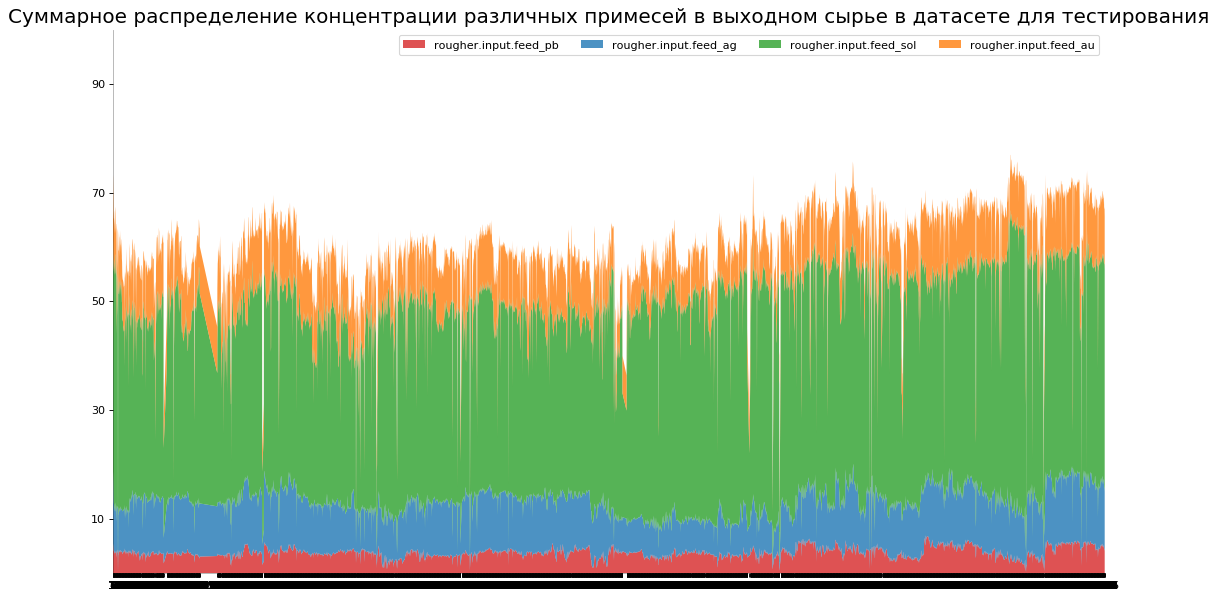

In [197]:
df = pd.DataFrame(features_test.loc[:,['rougher.input.feed_pb', 'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.feed_au']])
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']      


fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[0:4]
labs = columns.values.tolist()


x  = df.index
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()

y = np.vstack([y0, y1, y2, y3])


labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)


ax.set_title('The total distribution of the concentration of various impurities in the output raw material in the dataset for testing', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10, 100, 20), fontsize=10)
plt.xlim(x[0], x[-1])


plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

Since I was working with unscaled samples, I scale them:

In [198]:
# Here I call the standard scalar for feature scaling, then turn the scaled numpy arrays into workable dataframes.
scaler = StandardScaler()
scaler.fit(features_train)
cl = features_train.columns
features_train_1 = scaler.transform(features_train)
features_train_1 = pd.DataFrame(features_train_1, columns = cl)
cl = features_test.columns
features_test_1 = scaler.transform(features_test)
features_test_1 = pd.DataFrame(features_test_1, columns = cl)

The concentrations of substances at various stages of purification were considered, and near-zero values ​​of the concentration of impurities in the raw materials were found. Since these values ​​are too small and they can affect the performance of the model, it was decided to get rid of rows with impurity concentrations in the raw material less than 0.3, since the effect of the purification steps on such a small raw material is very small and can degrade the quality of the model. At the same time, one should not forget that such a model will not give an adequate forecast for such raw materials.

# 3. Model

I create a quality metric function

In [216]:
def final_sMAPE(data1, data2):
    data1 = data1.values#This date is converted into a numpy array for further counting, where the 0th column is the float and the 1st is the final values
    #data2 = data2.values
    sMAPE1 = (((abs((data1[:,0] - data2[:,0]))/(((abs(data1[:,0])+abs(data2[:,0])))/2))*100)).sum()/len(data1)
    sMAPE2 = (((abs((data1[:,1] - data2[:,1]))/(((abs(data1[:,1])+abs(data2[:,1])))/2))*100)).sum()/len(data1)
    final = float(0.25*sMAPE1 + 0.75*sMAPE2)
    return final

In [217]:
#I write the quality metric to a variable so that the grid selection of model parameters would work on it
score = make_scorer(final_sMAPE, greater_is_better=False)#greater_is_better=False because we reduce the target metric to improve the quality of the model

I search for hyperparameters for a random forest model using grid selection of parameters and cross-validation.

In [218]:
model = RandomForestRegressor(random_state=12345)#Random forest model


tuned_parameters = {'n_estimators': np.arange(1,10,1), 'max_depth': np.arange(1,10,1)}#hyperparameter ranges
n_folds = 5#number of splits to check

clf = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = score)
clf.fit(features_train_1, target_train)
ggh = pd.DataFrame(data=clf.cv_results_, columns = clf.cv_results_.keys())#I create a table with the results of the grid selection
ggh.sort_values(by = 'std_test_score', ascending = False).head(3)#I sort the table in descending order of rating and display the first 15 values ​​on the screen

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,0.256262,0.041371,0.002289,0.000080,5,1,"{'max_depth': 5, 'n_estimators': 1}",-16.854065,-10.678979,-13.328642,-14.307787,-13.876148,-13.809118,1.977741,78
47,0.862965,0.047164,0.002733,0.000221,6,3,"{'max_depth': 6, 'n_estimators': 3}",-13.108596,-11.434211,-14.679883,-13.211680,-17.211897,-13.929029,1.936627,79
45,0.274149,0.001919,0.002250,0.000055,6,1,"{'max_depth': 6, 'n_estimators': 1}",-12.680193,-12.168301,-13.481601,-14.116833,-17.625886,-14.014348,1.924819,80


Let's check the quality of the model with the parameters max_depth=3 and n_estimators=7.

In [222]:
model = RandomForestRegressor(n_estimators=1, max_depth=5, random_state=12345)
model.fit(features_train_1, target_train)
print('sMAPE=',final_sMAPE(target_test,model.predict(features_test_1)))
print('MAE=',mean_absolute_error(target_test,model.predict(features_test_1)))

sMAPE= 10.610691390809075
MAE= 9.658965170882741


I would like to double-check the result of the grid, for this I will conduct a graphical analysis of the results.

In [223]:
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#I set an empty list, into which values ​​will then be entered for plotting
a = 0#Cycle counter
for i in range(1,10,1):#I run the model parameters to find the optimal values
    a += 1
    graph.loc[a,'ox'] = i#I set the row index of an empty list
    model_R_F_C = RandomForestRegressor(max_depth=i, n_estimators=1, random_state=1234)#I create a model
    model_R_F_C.fit(features_train_1, target_train)#I teach
    train_predictions1 = model_R_F_C.predict(features_train_1)#I build time data on a test sample
    train_predictions2 = model_R_F_C.predict(features_test_1)#I build the data of the delay on the validation set
    f1_score1 = final_sMAPE(target_train, train_predictions1)#Metric calculation
    f1_score2 = final_sMAPE(target_test, train_predictions2)#Metric calculation
    graph.loc[a, 'oy1'] = f1_score1#Adding a value to a list
    graph.loc[a, 'oy2'] = f1_score2#Adding a value to a list
    print('max_depth=', i)#I display the parameters on the screen
    print('sMAPE for training set: ', f1_score1)#I display the parameters on the screen
    print('sMAPE for test set: ', f1_score2)#I display the parameters on the screen
    print()

max_depth= 1
sMAPE для обучающей выборки:  13.194326377173667
sMAPE для тестовой выборки:  11.969211079792558

max_depth= 2
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  11.777081751926627



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


max_depth= 3
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  11.81747007367915



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


max_depth= 4
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


max_depth= 5
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


max_depth= 6
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


max_depth= 7
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


max_depth= 8
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan

max_depth= 9
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 0, 'max_depth')

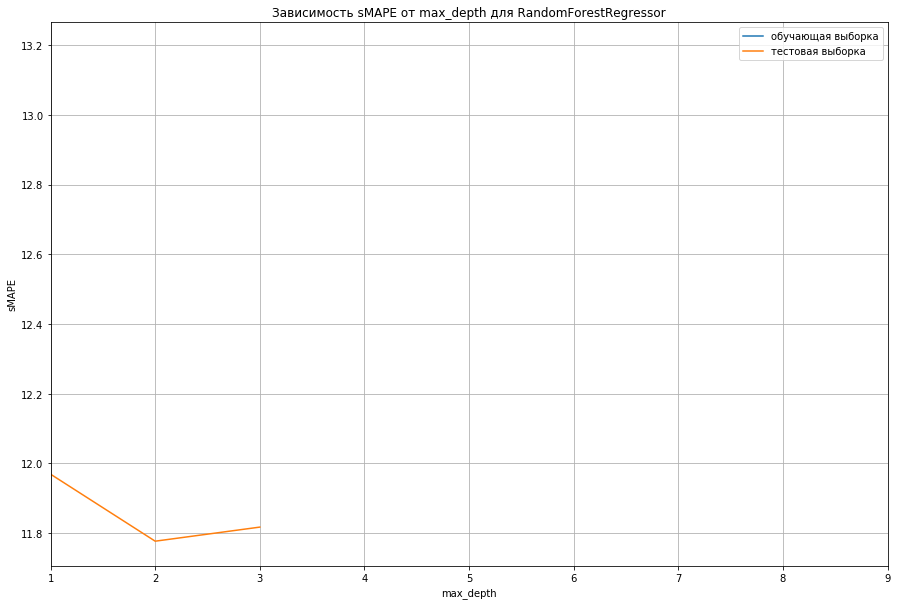

In [224]:
graph['ox'] = graph['ox'].astype('int')#I bring the data in the table to a convenient type for plotting
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'sMAPE dependency on max_depth for RandomForestRegressor',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='training set')#I'm building a graph
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='test set')
ax.set_ylabel('sMAPE')#Axis labels
ax.set_xlabel('max_depth')#Axis labels

Now, with max_depth=6, let's do the same enumeration of the n_estimators parameter.

In [225]:
graph = pd.DataFrame(columns = ['ox', 'oy1', 'oy2'])#I set an empty list, into which values will then be entered for plotting
a = 0#Cycle counter
for i in range(1,20,2):#I run the model parameters to find the optimal values
    a += 1
    graph.loc[a,'ox'] = i#I set the row index of an empty list
    model_R_F_C = RandomForestRegressor(max_depth=6, n_estimators=i, random_state=1234)#I create a model
    model_R_F_C.fit(features_train_1, target_train)#I teach
    train_predictions1 = model_R_F_C.predict(features_train_1)#I build time data on a test sample
    train_predictions2 = model_R_F_C.predict(features_test_1)#I build the data of the delay on the validation set
    f1_score1 = final_sMAPE(target_train, train_predictions1)#Metric calculation
    f1_score2 = final_sMAPE(target_test, train_predictions2)#Metric calculation
    graph.loc[a, 'oy1'] = f1_score1#Adding a value to a list
    graph.loc[a, 'oy2'] = f1_score2#Adding a value to a list
    print('n_estimators=', i)#I display the parameters on the screen
    print('sMAPE for training set: ', f1_score1)#I display the parameters on the screen
    print('sMAPE for test set: ', f1_score2)#I display the parameters on the screen
    print()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


n_estimators= 1
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  nan



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


n_estimators= 3
sMAPE для обучающей выборки:  nan
sMAPE для тестовой выборки:  10.16504469021734

n_estimators= 5
sMAPE для обучающей выборки:  11.644510665374995
sMAPE для тестовой выборки:  10.163614062644434

n_estimators= 7
sMAPE для обучающей выборки:  11.69173325084073
sMAPE для тестовой выборки:  10.076487873872505

n_estimators= 9
sMAPE для обучающей выборки:  11.675994589506152
sMAPE для тестовой выборки:  10.055972238335395

n_estimators= 11
sMAPE для обучающей выборки:  11.65399461937173
sMAPE для тестовой выборки:  10.21374930239659

n_estimators= 13
sMAPE для обучающей выборки:  11.66079005098708
sMAPE для тестовой выборки:  10.66223886768501

n_estimators= 15
sMAPE для обучающей выборки:  11.60637149521416
sMAPE для тестовой выборки:  10.556278273565814

n_estimators= 17
sMAPE для обучающей выборки:  11.596014330805502
sMAPE для тестовой выборки:  10.511242867418888

n_estimators= 19
sMAPE для обучающей выборки:  11.549117546234031
sMAPE для тестовой выборки:  10.42675872

Text(0.5, 0, 'n_estimators')

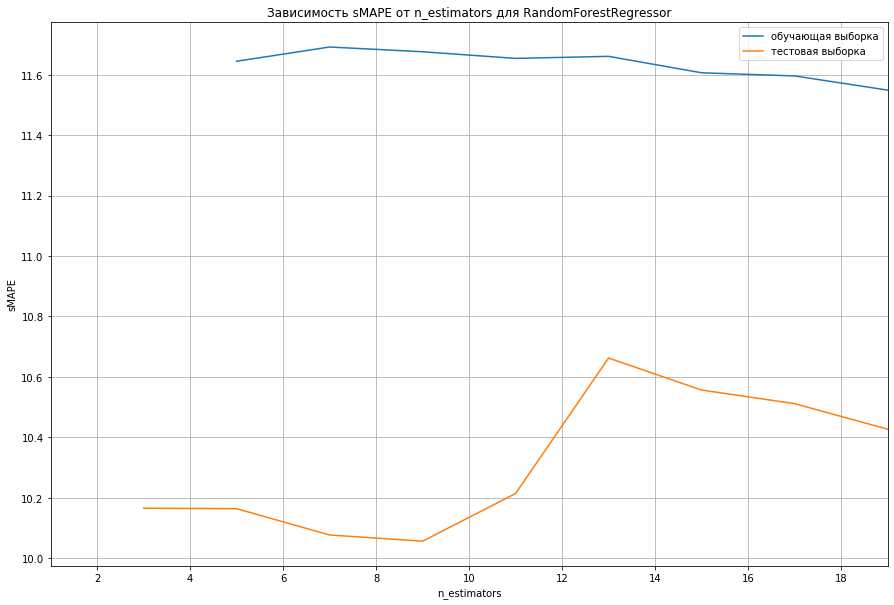

In [226]:
graph['ox'] = graph['ox'].astype('int')#I bring the data in the table to a convenient type for plotting
graph['oy1'] = graph['oy1'].astype('float')
graph['oy2'] = graph['oy2'].astype('float')
ax = graph.plot(title = 'sMAPE dependency on n_estimators for RandomForestRegressor',x = 'ox', y= 'oy1', figsize=(15,10), grid=True, label='training set')#I'm building a graph
graph.plot(x = 'ox', y= 'oy2', ax=ax, grid=True, label='test set')
ax.set_ylabel('sMAPE')#Axis labels
ax.set_xlabel('n_estimators')#Axis labels

With the change in the algorithm of the metric, the graphical method stopped working. The code below was up to date.

In [227]:
model = RandomForestRegressor(n_estimators=3, max_depth=6, random_state=12345)
model.fit(features_train_1, target_train)
print('sMAPE=',final_sMAPE(target_test,model.predict(features_test_1)))
print('MAE=',mean_absolute_error(target_test,model.predict(features_test_1)))

sMAPE= 10.107576364695309
MAE= 7.004229853008065


I'll try to change the number of folds on check to 6.

In [228]:
model = RandomForestRegressor(random_state=12345)


tuned_parameters = {'n_estimators': np.arange(1,10,1), 'max_depth': np.arange(1,10,1)}
n_folds = 6

clf = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = score)
clf.fit(features_train_1, target_train)
ggh = pd.DataFrame(data=clf.cv_results_, columns = clf.cv_results_.keys())#I create a table with the results of the grid selection
ggh.sort_values(by = 'std_test_score', ascending = False).head(3)#I sort the table in descending order of rating and display the first 15 values on the screen

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/cond

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
56,1.039517,0.040853,0.002619,0.000137,7,3,"{'max_depth': 7, 'n_estimators': 3}",-13.635350,-10.488396,-11.530827,-14.240182,-12.346044,-18.024762,-13.377611,2.423029,48
47,0.916410,0.065475,0.002543,0.000108,6,3,"{'max_depth': 6, 'n_estimators': 3}",-13.464693,-10.589034,-10.948242,-14.403460,-12.838467,-17.393028,-13.272834,2.276116,44
48,1.175996,0.011318,0.002735,0.000091,6,4,"{'max_depth': 6, 'n_estimators': 4}",-14.157292,-10.529531,-10.730329,-15.224875,-13.220862,-16.370864,-13.372345,2.164958,47


In [236]:
model = RandomForestRegressor(n_estimators=3, max_depth=7, random_state=12345)
model.fit(features_train_1, target_train)
print('sMAPE=',final_sMAPE(target_test,model.predict(features_test_1)))
print('MAE=',mean_absolute_error(target_test,model.predict(features_test_1)))

sMAPE= 11.666149726263537
MAE= 9.198560093525582


As you can see, the result is worse, let's try to reduce the number of partitions to 4.

In [230]:
model = RandomForestRegressor(random_state=12345)


tuned_parameters = {'n_estimators': np.arange(1,10,1), 'max_depth': np.arange(1,10,1)}
n_folds = 4

clf = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = score)
clf.fit(features_train_1, target_train)
ggh = pd.DataFrame(data=clf.cv_results_, columns = clf.cv_results_.keys())#I create a table with the results of the grid selection
ggh.sort_values(by = 'std_test_score', ascending = False).head(3)#I sort the table in descending order of rating and display the first 15 values ​​on the screen

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
67,1.700970,0.098474,0.003419,0.000192,8,5,"{'max_depth': 8, 'n_estimators': 5}",-13.114794,-11.656131,-23.397528,-14.424050,-15.647954,4.579887,74
66,1.336536,0.043041,0.003128,0.000029,8,4,"{'max_depth': 8, 'n_estimators': 4}",-13.191935,-11.617196,-23.431614,-15.279055,-15.879768,4.549218,77
65,0.984571,0.010950,0.003383,0.000808,8,3,"{'max_depth': 8, 'n_estimators': 3}",-13.577328,-11.591681,-23.555980,-15.837583,-16.140470,4.537040,79


In [238]:
model = RandomForestRegressor(n_estimators=5, max_depth=8, random_state=12345)
model.fit(features_train_1, target_train)
print('sMAPE=',final_sMAPE(target_test,model.predict(features_test_1)))
print('MAE=',mean_absolute_error(target_test,model.predict(features_test_1)))

sMAPE= 11.819652464234784
MAE= 11.923414753499097


With the number of subsamples of the training sample equal to 4, we achieved the best result, we leave these parameters. Next, with the same grid search parameters, let's look at the result of the gradient boosting model.

In [237]:
model = ExtraTreesRegressor(random_state=12345)


tuned_parameters = {'n_estimators': np.arange(1,10,1), 'max_depth': np.arange(1,10,1)}
n_folds = 5

clf = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = score)
clf.fit(features_train_1, target_train)
ggh = pd.DataFrame(data=clf.cv_results_, columns = clf.cv_results_.keys())#I create a table with the results of the grid selection
ggh.sort_values(by = 'std_test_score', ascending = False).head(3)#I sort the table in descending order of rating and display the first 15 values on the screen

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removin

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.039025,0.001080,0.003012,0.000066,1,9,"{'max_depth': 1, 'n_estimators': 9}",-12.503141,-12.652402,-31.219037,-15.665120,-21.592083,-18.725525,7.060649,76
62,0.214090,0.004679,0.003917,0.000110,7,9,"{'max_depth': 7, 'n_estimators': 9}",-13.717390,-13.614425,-29.017884,-13.212236,-17.150612,-17.342012,6.007249,75
71,0.266094,0.036474,0.004374,0.000621,8,9,"{'max_depth': 8, 'n_estimators': 9}",-13.955542,-12.733926,-28.420108,-12.947271,-16.635975,-16.938079,5.906109,73


In [239]:
model = ExtraTreesRegressor(n_estimators=9, max_depth=1, random_state=12345)
model.fit(features_train_1, target_train)
print('sMAPE=',final_sMAPE(target_test,model.predict(features_test_1)))
print('MAE=',mean_absolute_error(target_test,model.predict(features_test_1)))

sMAPE= 12.63550033320221
MAE= 10.574067140588031


As you can see: the random forest at the very beginning gave the best result, so I leave it.( sMAPE= 10.610691390809075 MAE= 9.658965170882741)

The dataset was preprocessed, namely: processing gaps, scaling columns (features) for training. The preparation of data for the model also included the removal of particles with a low concentration of substances. THEREFORE, THE MODEL ITSELF WILL BE NECESSARY TO FILTER LOW CONCENTRATION VALUES (<0.3). An analysis of the data was carried out, during which the coincidence of the distribution of grain sizes in the training and test samples was found out, it turned out that the increase in the concentration of gold to a greater extent occurs due to a decrease in the concentration of impurities (not solid metals). The models were trained and tested, the best result was given by a random forest: sMAPE= sMAPE= 10.610691390809075 MAE= 9.658965170882741.